In [ ]:
from typing import Sequence
from dataclasses import dataclass

import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
import optax
from flax.nnx import split, merge

from lhf import *

seed = 42
key = jax.random.PRNGKey(seed)

In [ ]:
base_p = TaskParams(
    alpha = 0.3,
    beta = 0.2,
    gamma = 1.0
)

target_p = TaskParams(
    alpha = 0.3,
    beta = 2.0,
    gamma = 0.0
)

task_vis = ManifoldVisualizer(ylim=(-1,5))

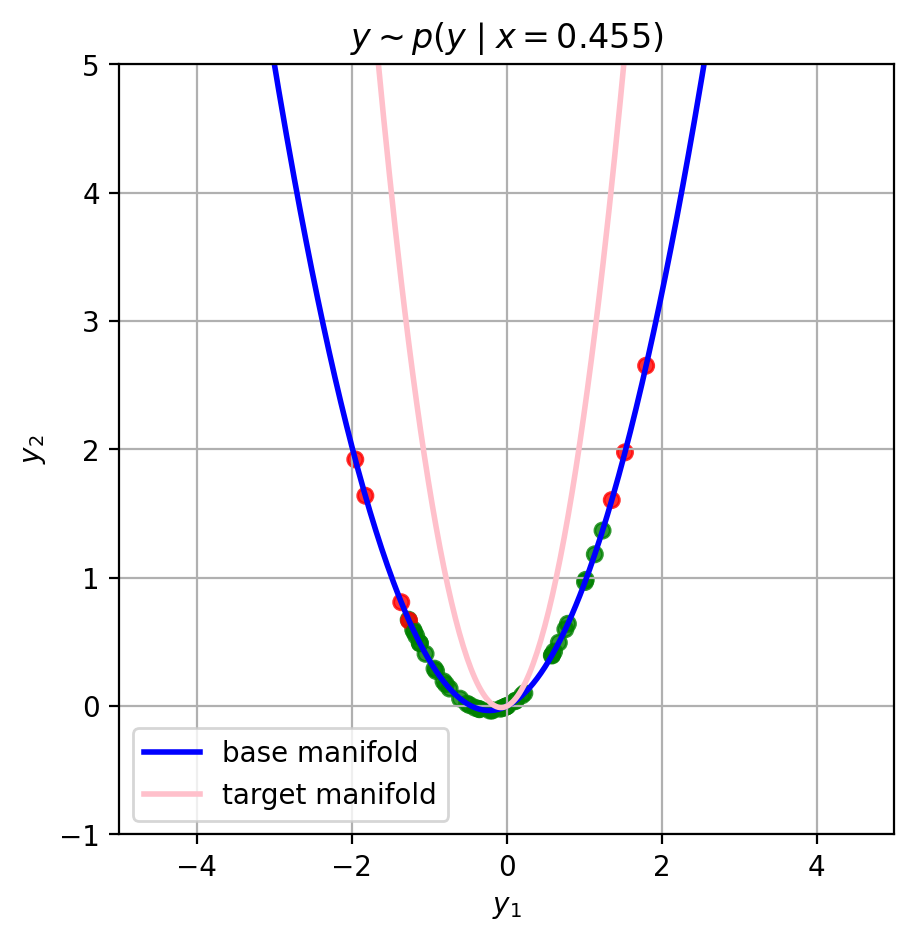

In [ ]:
n_queries = 1024 #256
n_internal = 10000
m = 50
tau = 1.0

(
    key,
    x_key,
    y_key,
    l_key
) = jax.random.split(key, 4)

x = jax.random.uniform(x_key, shape=(n_internal,1), minval=-1, maxval=1)
xs = jnp.broadcast_to(
    x[:,None,:],
    (n_internal, m, 1)
)   # (B,m,1)
vmapped_sample_manifold = jax.vmap(
    sample_manifold,
    in_axes=(0,1,None,None,None),
    out_axes=1
)
y_keys = jax.random.split(y_key, (m,))
ys = vmapped_sample_manifold(
    y_keys,
    xs,
    base_p.alpha,
    base_p.beta,
    base_p.gamma,
)   # (B,m,2)
gt_logits = logpdf_labels(
    xs,
    ys,
    alpha=target_p.alpha,
    beta=target_p.beta,
    gamma=target_p.gamma,
    tau=tau
)
# Sample labels
gt_labels = jax.random.categorical(
    l_key,
    gt_logits,
    axis=-1
)
task_vis.visualize(
    xs[0,0,0],
    ys[0],
    base_manifold=base_p,
    target_manifold=target_p,
    labels=gt_labels[0]
)

In [ ]:
num_iter = 10

# Logging:
gt_u_history = []
y_history = []
ys_tot = None
l_tot = None
l_history = []

# Step 1: Pre-training
pre_train_epochs = 2000
pre_train_lr = 1e-3
pre_train_batch_dim = 256
sigma_y_0 = 1.5
sigma_y_T = 0.05

(
    key,
    x_key,
    y_key,
    init_key,
    ys_key
) = jax.random.split(key, 5)

pre_train_features = [256, 256]
pre_train_n_features = len(pre_train_features)
d_z=1
d_y=2

encoder_mlp = MLP(
    features=pre_train_features,
    output_dim=d_z + (d_z*(d_z+1)) // 2,
    kernel_inits=[jax.nn.initializers.normal(1e-2)] * pre_train_n_features,
    bias_inits=[jax.nn.initializers.zeros] * pre_train_n_features
)
decoder_mlp = MLP(
    features=pre_train_features,
    output_dim=d_y,
    kernel_inits=[jax.nn.initializers.normal(1e-2)] * pre_train_n_features,
    bias_inits=[jax.nn.initializers.zeros] * pre_train_n_features
)

gen_model = ConditionalVAE(
    encoder=encoder_mlp,
    decoder=decoder_mlp,
    d_z=1,
    d_y=2
)
x_batch = xs[:pre_train_batch_dim,0]  # (B,1)
y_batch = ys[:pre_train_batch_dim,0]  # (B,2)

xz_batch = jnp.concatenate(
    [x_batch, jnp.zeros((pre_train_batch_dim,1))],
    axis=-1
)
xy_batch = jnp.concatenate(
    [x_batch, y_batch],
    axis=-1
)

vae_params = {
    "encoder": encoder_mlp.init(init_key, xy_batch),
    "decoder": decoder_mlp.init(init_key, xz_batch)
}

def pre_train_loss_fn(params, step, key, x, y):
        return -jnp.mean(
            gen_model.elbo(
                params,
                x,
                y,
                key,
                sigma_y=sigma_y_0 + (sigma_y_T - sigma_y_0)*(step+1)/pre_train_epochs,
            )
        )

@jax.jit
def pre_train_step(params, step, opt_state, key, x, y):
    loss, grads = jax.value_and_grad(pre_train_loss_fn)(params, step, key, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

def sample_many(params, key, x, m):
    keys = jax.random.split(key, m)
    return jax.vmap(
        lambda k: gen_model.sample(
            params,
            x,                     # (B, 1)
            k,
            sigma_y=sigma_y_T,
            deterministic=False,
        ),
        out_axes=1,
    )(keys)

# Step 2: Learn preference model
pref_lr = 1e-3
pref_batch_dim = 256
pref_train_epochs = 1000

(
    key,
    init_key,
    l_key,
    gt_l_key
) = jax.random.split(key, 4)

mlp = MLP(
    features=[256, 256],
    output_dim=1
)

init_batch = jnp.zeros((pref_batch_dim, m, 2))
pref_params = {
    "y2_fn": mlp.init(init_key, init_batch),
}

y2_learned = lambda p, x, y1: mlp.apply(p, jnp.concatenate([x,y1], axis=2))

pref_model = PrefModel(
    y2_fn = y2_learned
)

def pref_nll(params, x, y, labels):
    logpdf = pref_model.logpdf(params, x, y, tau=tau)      # (B, m, 2)

    # Gather log-probabilities of the observed labels
    logp = jnp.take_along_axis(
        logpdf,
        labels[..., None],     # (B, m, 1)
        axis=-1,
    )[..., 0]                  # (B, m)

    return -jnp.mean(logp)

@jax.jit
def pref_train_step(params, opt_state, x, y, labels):
    loss, grads = jax.value_and_grad(pref_nll)(
        params,
        x,
        y,
        labels,
    )
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Step 3: Improve VAE
align_lr = 1e-3
align_batch_dim = 256
align_epochs = 1000

#beta = 0.01
beta = 0.01

def avg_u(params, key, x, sigma_y):
    y = gen_model.sample(
        params,
        x,
        key,
        sigma_y=sigma_y,
        deterministic=False
    )      # (B, m, 2)

    y1 = y[:, None, 0][...,None]
    y2 = y[:, None, 1][...,None]
    y2_hat = y2_fn(x[:, None, :], y1)
    u = -(y2 - y2_hat)**2

    return jnp.mean(u)

def kl_div(params, base_vae_params, key, x, sigma_y):
    kl = gen_model.d_kl(
        params,
        base_vae_params,
        x,
        key,
        sigma_y=sigma_y
    )

    return jnp.mean(kl)

def align_loss(params, base_vae_params, key, x, sigma_y):
    u_bar = avg_u(
        params,
        key, 
        x,
        sigma_y
    )
    kl = kl_div(
        params,
        base_vae_params,
        key,
        x,
        sigma_y
    )
    
    return -u_bar + beta * kl

@jax.jit
def align_train_step(params, base_vae_params, opt_state, key, x, sigma_y):
    loss, grads = jax.value_and_grad(align_loss)(
        params,
        base_vae_params,
        key,
        x,
        sigma_y
    )
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

vmapped_vae_sample = jax.vmap(
    gen_model.sample,
    in_axes=(None, 1, 0),
    out_axes=1
)

[1/2000] -ELBO = 3.132312059402466
[2/2000] -ELBO = 3.1315174102783203
[3/2000] -ELBO = 3.1306772232055664
[4/2000] -ELBO = 3.129758596420288
[5/2000] -ELBO = 3.1287033557891846
[6/2000] -ELBO = 3.1274538040161133
[7/2000] -ELBO = 3.1260476112365723
[8/2000] -ELBO = 3.1244053840637207
[9/2000] -ELBO = 3.122499465942383
[10/2000] -ELBO = 3.120354413986206
[11/2000] -ELBO = 3.1178994178771973
[12/2000] -ELBO = 3.115088701248169
[13/2000] -ELBO = 3.1119730472564697
[14/2000] -ELBO = 3.1083459854125977
[15/2000] -ELBO = 3.104478359222412
[16/2000] -ELBO = 3.1002511978149414
[17/2000] -ELBO = 3.095534563064575
[18/2000] -ELBO = 3.090439796447754
[19/2000] -ELBO = 3.0850491523742676
[20/2000] -ELBO = 3.079120635986328
[21/2000] -ELBO = 3.073045253753662
[22/2000] -ELBO = 3.0668094158172607
[23/2000] -ELBO = 3.060879707336426
[24/2000] -ELBO = 3.055001974105835
[25/2000] -ELBO = 3.0492260456085205
[26/2000] -ELBO = 3.044257640838623
[27/2000] -ELBO = 3.040379524230957
[28/2000] -ELBO = 3.0378

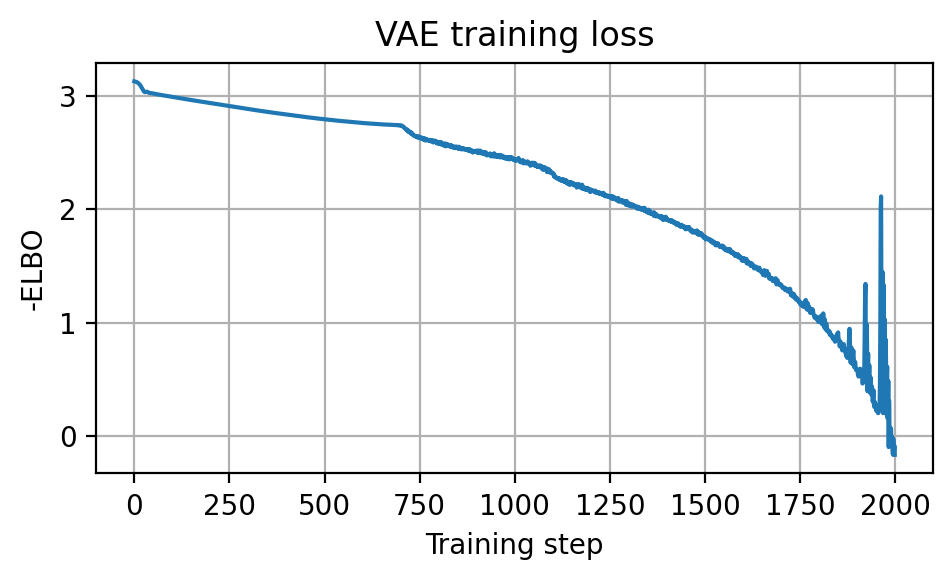

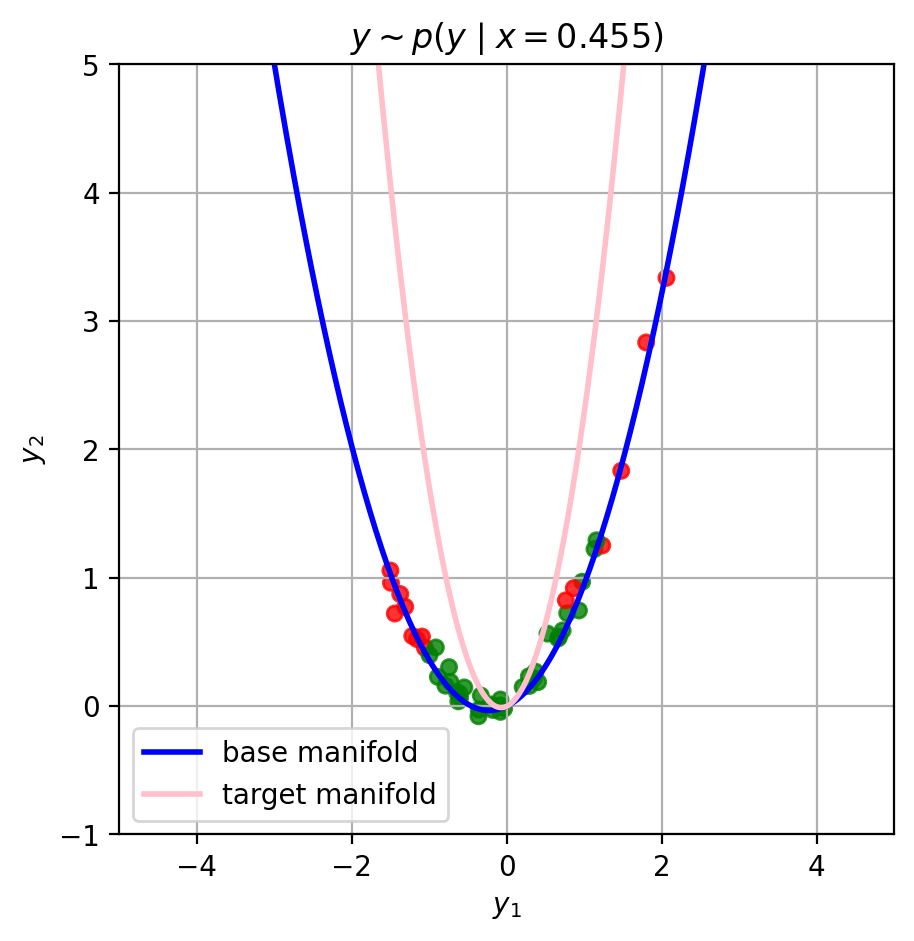

[1/1000] NLL = 0.4957
[2/1000] NLL = 0.4840
[3/1000] NLL = 0.4106
[4/1000] NLL = 0.3978
[5/1000] NLL = 0.3789
[6/1000] NLL = 0.3884
[7/1000] NLL = 0.3955
[8/1000] NLL = 0.3859
[9/1000] NLL = 0.3941
[10/1000] NLL = 0.3843
[11/1000] NLL = 0.3747
[12/1000] NLL = 0.3667
[13/1000] NLL = 0.3469
[14/1000] NLL = 0.3560
[15/1000] NLL = 0.3602
[16/1000] NLL = 0.3341
[17/1000] NLL = 0.3557
[18/1000] NLL = 0.3602
[19/1000] NLL = 0.3489
[20/1000] NLL = 0.3163
[21/1000] NLL = 0.3210
[22/1000] NLL = 0.3331
[23/1000] NLL = 0.3105
[24/1000] NLL = 0.3252
[25/1000] NLL = 0.3024
[26/1000] NLL = 0.3282
[27/1000] NLL = 0.2935
[28/1000] NLL = 0.3056
[29/1000] NLL = 0.3246
[30/1000] NLL = 0.3237
[31/1000] NLL = 0.3201
[32/1000] NLL = 0.2972
[33/1000] NLL = 0.2926
[34/1000] NLL = 0.3258
[35/1000] NLL = 0.3054
[36/1000] NLL = 0.2785
[37/1000] NLL = 0.2937
[38/1000] NLL = 0.2873
[39/1000] NLL = 0.3063
[40/1000] NLL = 0.3058
[41/1000] NLL = 0.3158
[42/1000] NLL = 0.2956
[43/1000] NLL = 0.3362
[44/1000] NLL = 0.32

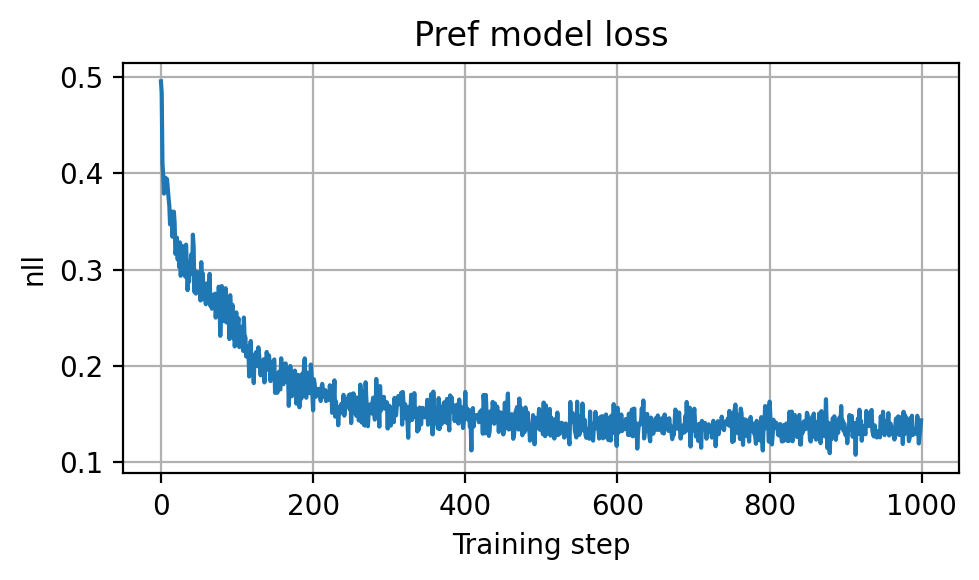

Dataset composition (likes/dislikes):   0.7633519768714905 / 0.23664802312850952
ACC(learned vs GT):   0.9896479845046997 / 0.9197279810905457
y2_learned.shape =  (400,)
y2_learned[190:210] =  [0.19088438 0.19279516 0.19424069 0.19315717 0.19119027 0.19130242
 0.18984035 0.18745252 0.18321466 0.17125416 0.15999833 0.15956745
 0.17226416 0.1951142  0.21477592 0.23854673 0.26465642 0.29350466
 0.31981444 0.34920442]


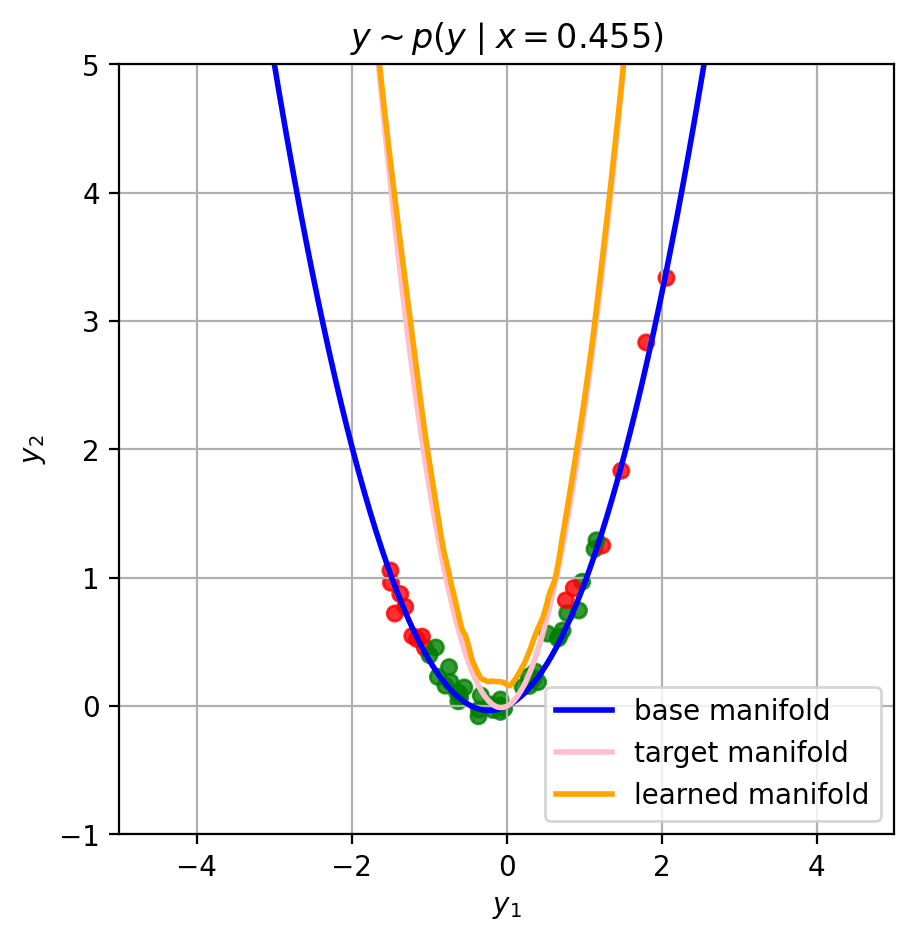

[1/1000] loss = 9.6592
[2/1000] loss = 7.1299
[3/1000] loss = 4.7187
[4/1000] loss = 3.6208
[5/1000] loss = 3.2286
[6/1000] loss = 2.6650
[7/1000] loss = 2.6169
[8/1000] loss = 2.4314
[9/1000] loss = 2.3042
[10/1000] loss = 2.1221
[11/1000] loss = 2.0043
[12/1000] loss = 1.9246
[13/1000] loss = 1.9281
[14/1000] loss = 1.8992
[15/1000] loss = 1.8934
[16/1000] loss = 1.8590
[17/1000] loss = 1.8760
[18/1000] loss = 1.9195
[19/1000] loss = 1.9204
[20/1000] loss = 1.9328
[21/1000] loss = 1.9004
[22/1000] loss = 1.8277
[23/1000] loss = 1.8138
[24/1000] loss = 1.7949
[25/1000] loss = 1.7591
[26/1000] loss = 1.7598
[27/1000] loss = 1.7480
[28/1000] loss = 1.7570
[29/1000] loss = 1.7390
[30/1000] loss = 1.7099
[31/1000] loss = 1.7345
[32/1000] loss = 1.6917
[33/1000] loss = 1.6822
[34/1000] loss = 1.6563
[35/1000] loss = 1.6311
[36/1000] loss = 1.6479
[37/1000] loss = 1.6535
[38/1000] loss = 1.5992
[39/1000] loss = 1.6372
[40/1000] loss = 1.5698
[41/1000] loss = 1.6110
[42/1000] loss = 1.5437
[

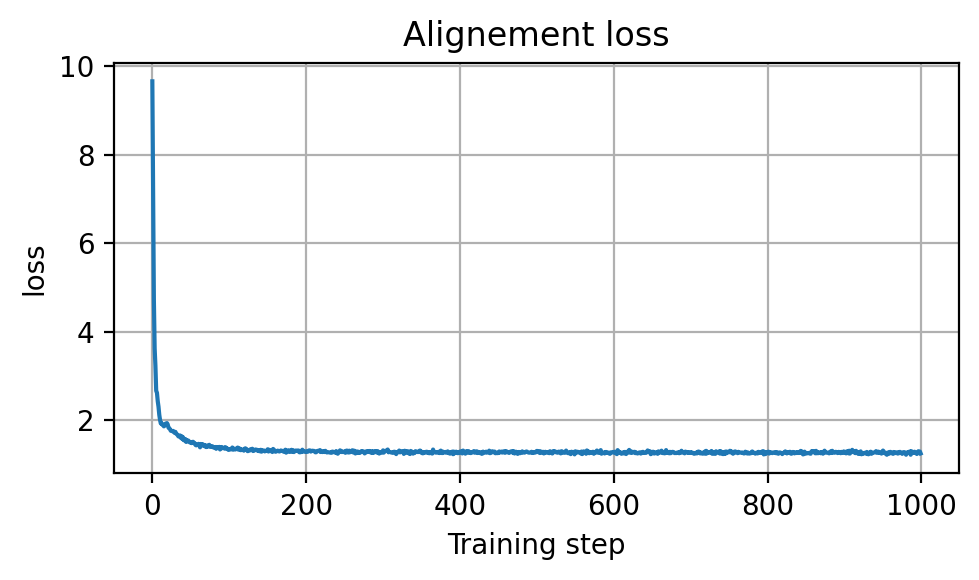

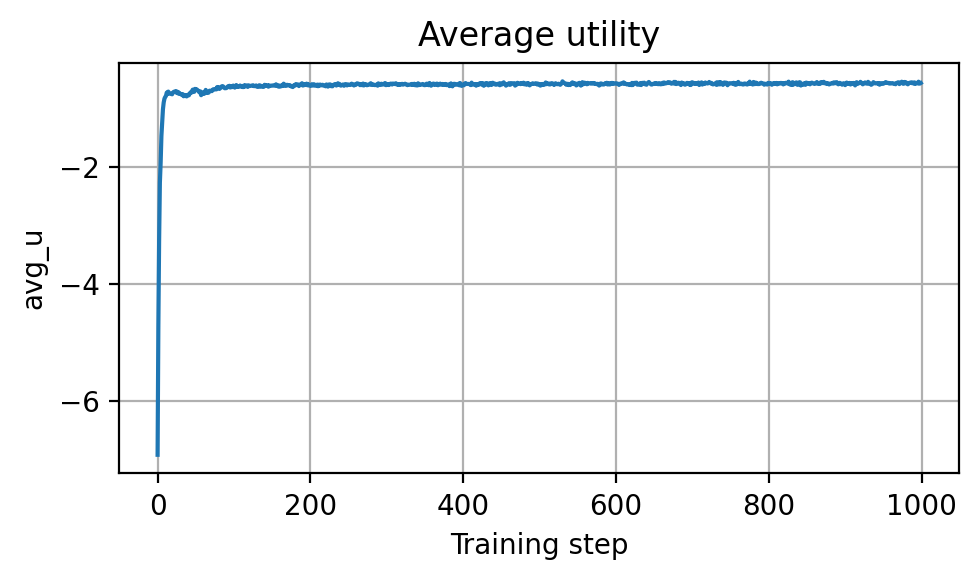

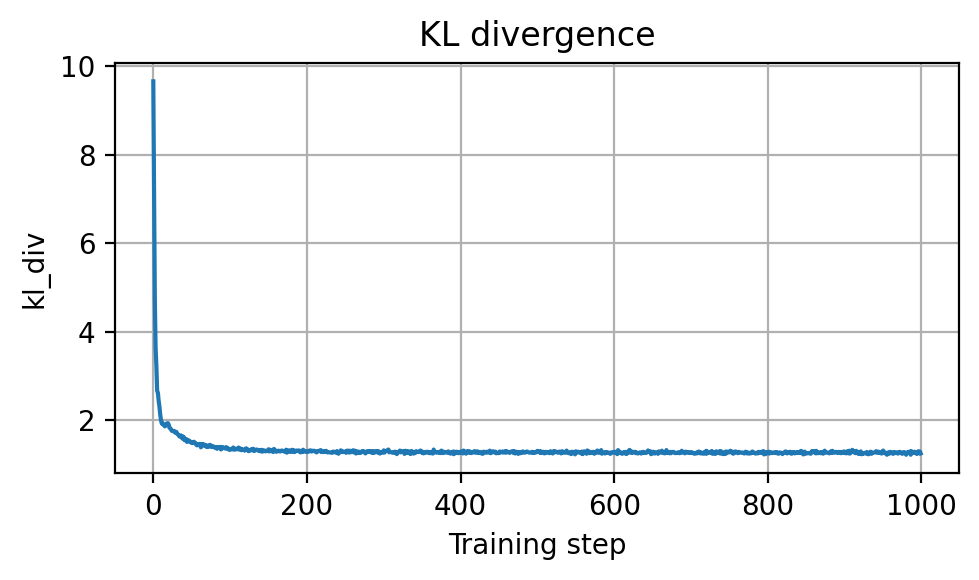

y2_learned.shape =  (400,)
y2_learned[190:210] =  [0.19088438 0.19279516 0.19424069 0.19315717 0.19119027 0.19130242
 0.18984035 0.18745252 0.18321466 0.17125416 0.15999833 0.15956745
 0.17226416 0.1951142  0.21477592 0.23854673 0.26465642 0.29350466
 0.31981444 0.34920442]


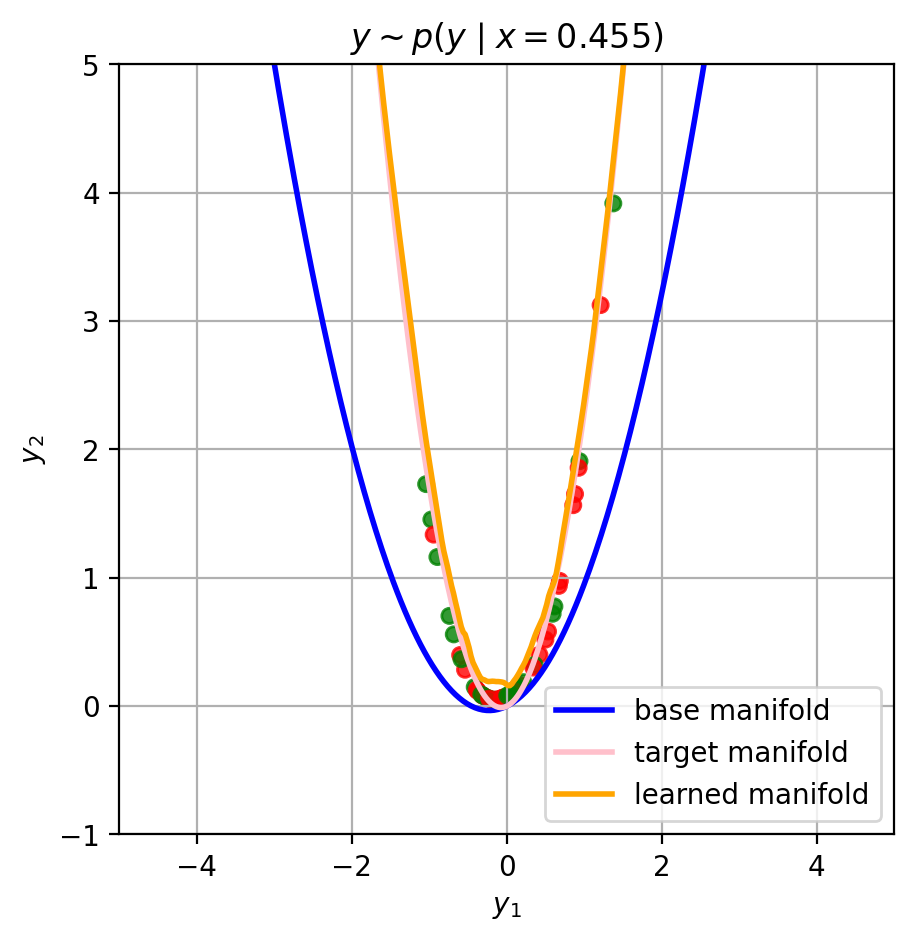

[1/2000] -ELBO = 5.53461217880249
[2/2000] -ELBO = 5.436673164367676
[3/2000] -ELBO = 5.347114086151123
[4/2000] -ELBO = 5.2608771324157715
[5/2000] -ELBO = 5.177349090576172
[6/2000] -ELBO = 5.097022533416748
[7/2000] -ELBO = 5.018501281738281
[8/2000] -ELBO = 4.941352367401123
[9/2000] -ELBO = 4.8659234046936035
[10/2000] -ELBO = 4.792575836181641
[11/2000] -ELBO = 4.721045017242432
[12/2000] -ELBO = 4.650678634643555
[13/2000] -ELBO = 4.584394454956055
[14/2000] -ELBO = 4.517967700958252
[15/2000] -ELBO = 4.45406436920166
[16/2000] -ELBO = 4.393862247467041
[17/2000] -ELBO = 4.33376407623291
[18/2000] -ELBO = 4.2725114822387695
[19/2000] -ELBO = 4.219161033630371
[20/2000] -ELBO = 4.164811611175537
[21/2000] -ELBO = 4.111861228942871
[22/2000] -ELBO = 4.062016487121582
[23/2000] -ELBO = 4.014298915863037
[24/2000] -ELBO = 3.966430425643921
[25/2000] -ELBO = 3.9189460277557373
[26/2000] -ELBO = 3.8754849433898926
[27/2000] -ELBO = 3.831225633621216
[28/2000] -ELBO = 3.792672157287597

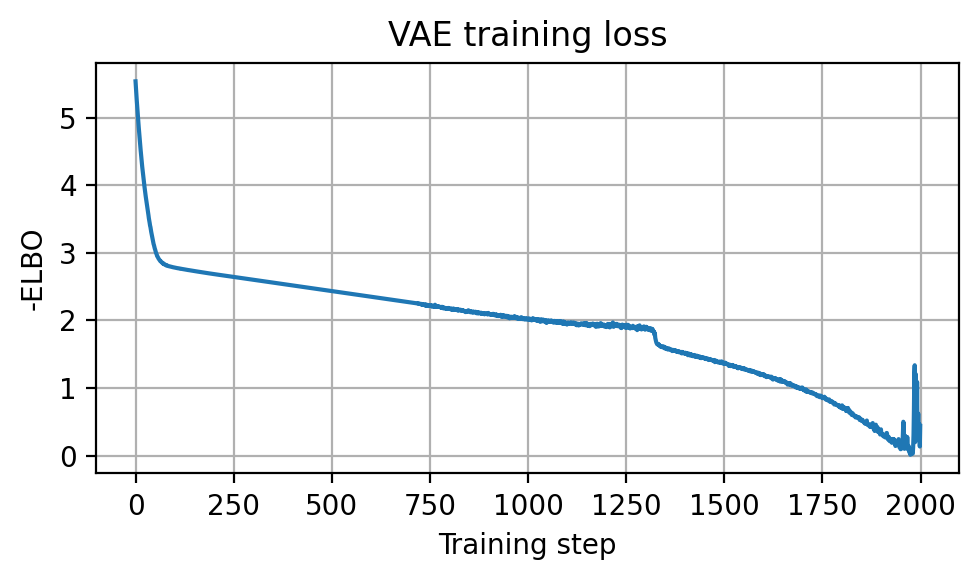

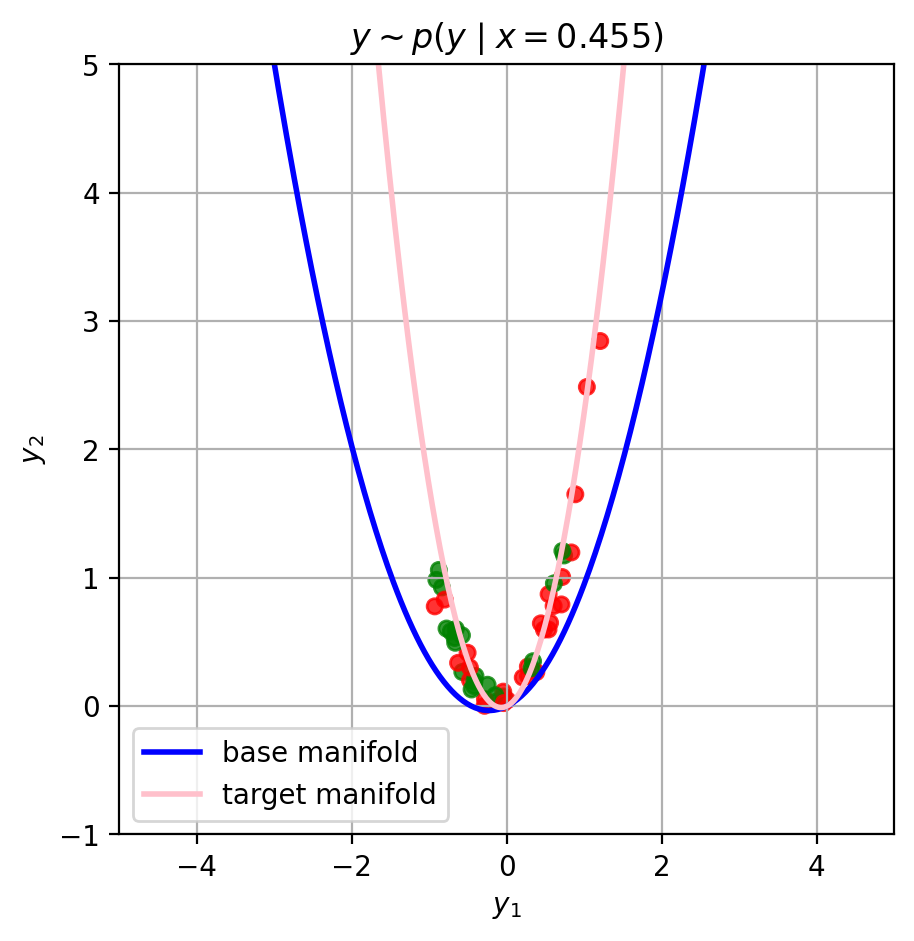

[1/1000] NLL = 0.4198
[2/1000] NLL = 0.4583
[3/1000] NLL = 0.4105
[4/1000] NLL = 0.4531
[5/1000] NLL = 0.4175
[6/1000] NLL = 0.4057
[7/1000] NLL = 0.4311
[8/1000] NLL = 0.4462
[9/1000] NLL = 0.4175
[10/1000] NLL = 0.3993
[11/1000] NLL = 0.4201
[12/1000] NLL = 0.3923
[13/1000] NLL = 0.3833
[14/1000] NLL = 0.3985
[15/1000] NLL = 0.4330
[16/1000] NLL = 0.4037
[17/1000] NLL = 0.3800
[18/1000] NLL = 0.4104
[19/1000] NLL = 0.3908
[20/1000] NLL = 0.4012
[21/1000] NLL = 0.4315
[22/1000] NLL = 0.4100
[23/1000] NLL = 0.3950
[24/1000] NLL = 0.4103
[25/1000] NLL = 0.4191
[26/1000] NLL = 0.4302
[27/1000] NLL = 0.4362
[28/1000] NLL = 0.4084
[29/1000] NLL = 0.4370
[30/1000] NLL = 0.4216
[31/1000] NLL = 0.4086
[32/1000] NLL = 0.4141
[33/1000] NLL = 0.4102
[34/1000] NLL = 0.3892
[35/1000] NLL = 0.4038
[36/1000] NLL = 0.3739
[37/1000] NLL = 0.3981
[38/1000] NLL = 0.4190
[39/1000] NLL = 0.3638
[40/1000] NLL = 0.3692
[41/1000] NLL = 0.3906
[42/1000] NLL = 0.4054
[43/1000] NLL = 0.3889
[44/1000] NLL = 0.40

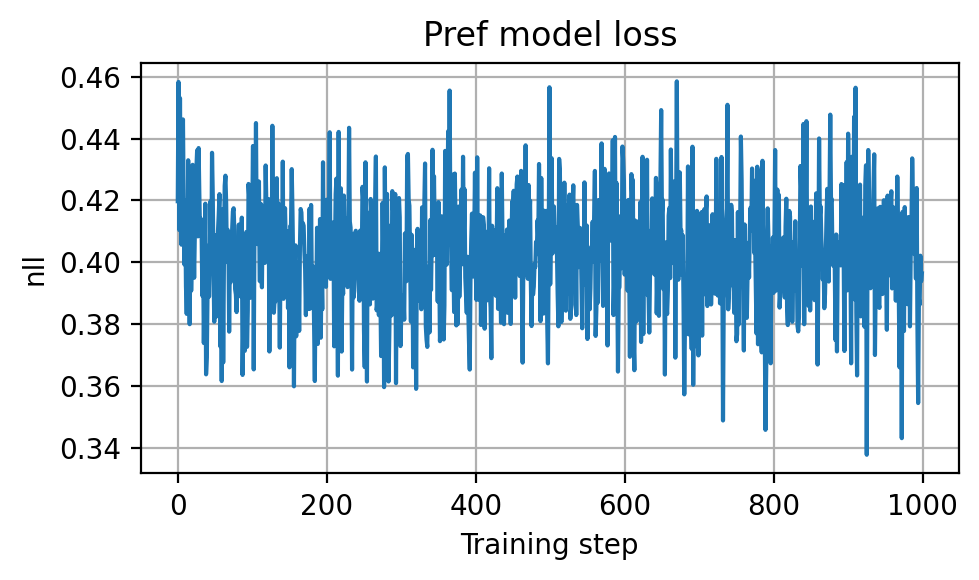

Dataset composition (likes/dislikes):   0.5068100094795227 / 0.4931899905204773
ACC(learned vs GT):   0.9898599982261658 / 0.5204460024833679
y2_learned.shape =  (400,)
y2_learned[190:210] =  [-0.34602863 -0.34224635 -0.3371478  -0.3332426  -0.33101153 -0.32696438
 -0.32094753 -0.31576917 -0.31346956 -0.30578458 -0.29224086 -0.27194947
 -0.24759275 -0.22253719 -0.19680193 -0.16532767 -0.12540919 -0.07080805
 -0.01047982  0.05632958]


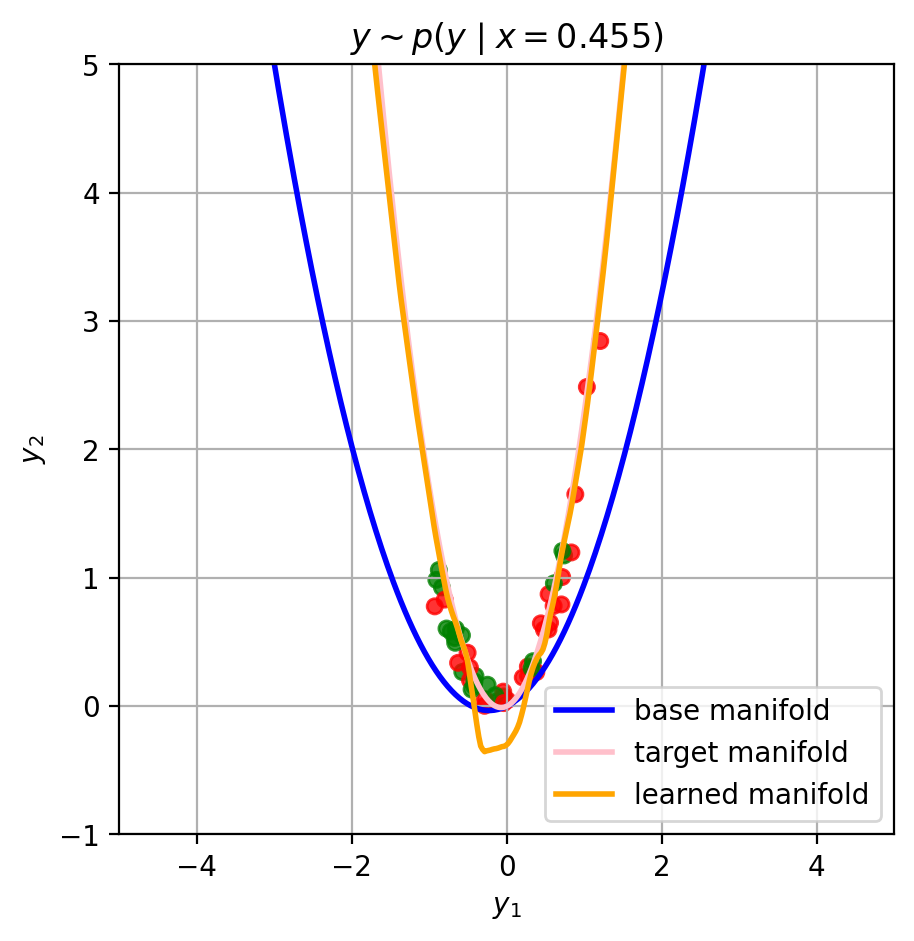

[1/1000] loss = 0.6190
[2/1000] loss = 0.5198
[3/1000] loss = 0.4873
[4/1000] loss = 0.4514
[5/1000] loss = 0.4294
[6/1000] loss = 0.4255
[7/1000] loss = 0.4240
[8/1000] loss = 0.4171
[9/1000] loss = 0.4287
[10/1000] loss = 0.4408
[11/1000] loss = 0.4315
[12/1000] loss = 0.4232
[13/1000] loss = 0.4122
[14/1000] loss = 0.4138
[15/1000] loss = 0.4078
[16/1000] loss = 0.4025
[17/1000] loss = 0.3930
[18/1000] loss = 0.3966
[19/1000] loss = 0.3952
[20/1000] loss = 0.4016
[21/1000] loss = 0.3995
[22/1000] loss = 0.3977
[23/1000] loss = 0.4001
[24/1000] loss = 0.3955
[25/1000] loss = 0.3965
[26/1000] loss = 0.3825
[27/1000] loss = 0.3840
[28/1000] loss = 0.3891
[29/1000] loss = 0.3809
[30/1000] loss = 0.3863
[31/1000] loss = 0.3873
[32/1000] loss = 0.3823
[33/1000] loss = 0.3881
[34/1000] loss = 0.3893
[35/1000] loss = 0.3952
[36/1000] loss = 0.3884
[37/1000] loss = 0.3902
[38/1000] loss = 0.3949
[39/1000] loss = 0.3947
[40/1000] loss = 0.3835
[41/1000] loss = 0.3918
[42/1000] loss = 0.3871
[

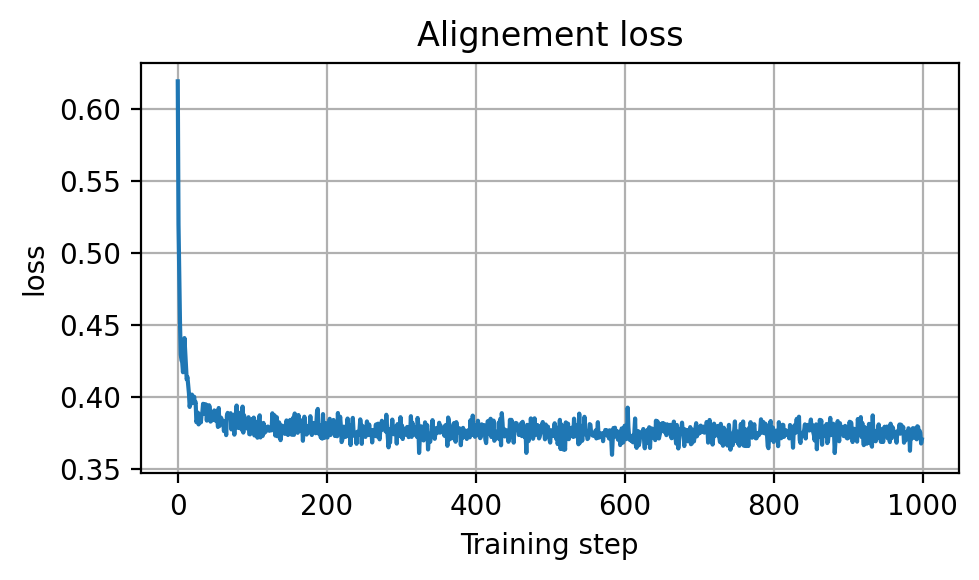

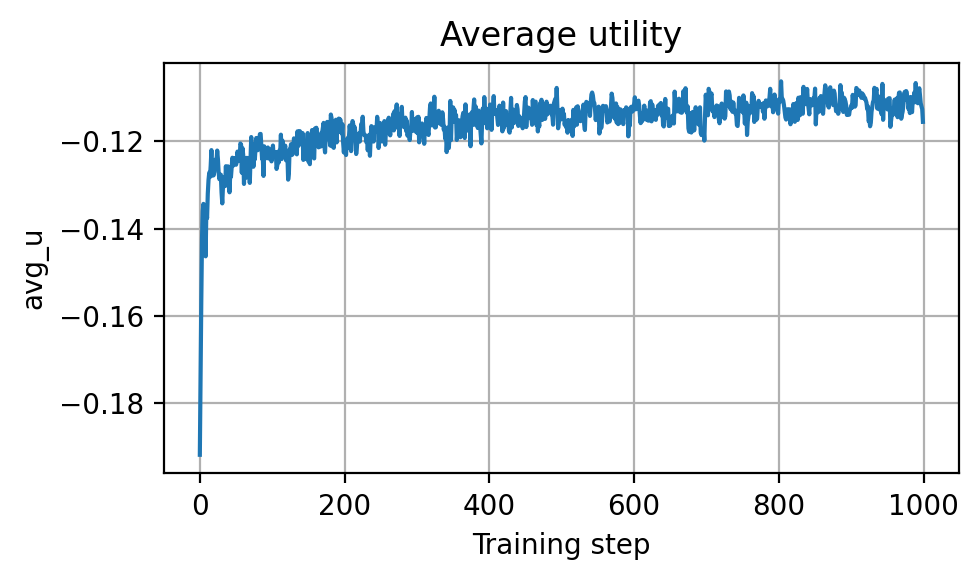

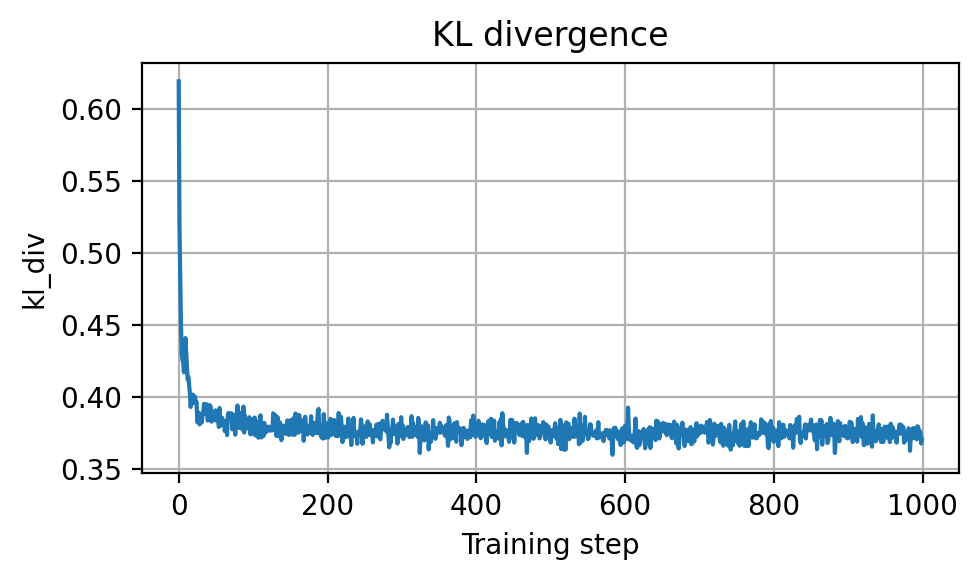

y2_learned.shape =  (400,)
y2_learned[190:210] =  [-0.34602863 -0.34224635 -0.3371478  -0.3332426  -0.33101153 -0.32696438
 -0.32094753 -0.31576917 -0.31346956 -0.30578458 -0.29224086 -0.27194947
 -0.24759275 -0.22253719 -0.19680193 -0.16532767 -0.12540919 -0.07080805
 -0.01047982  0.05632958]


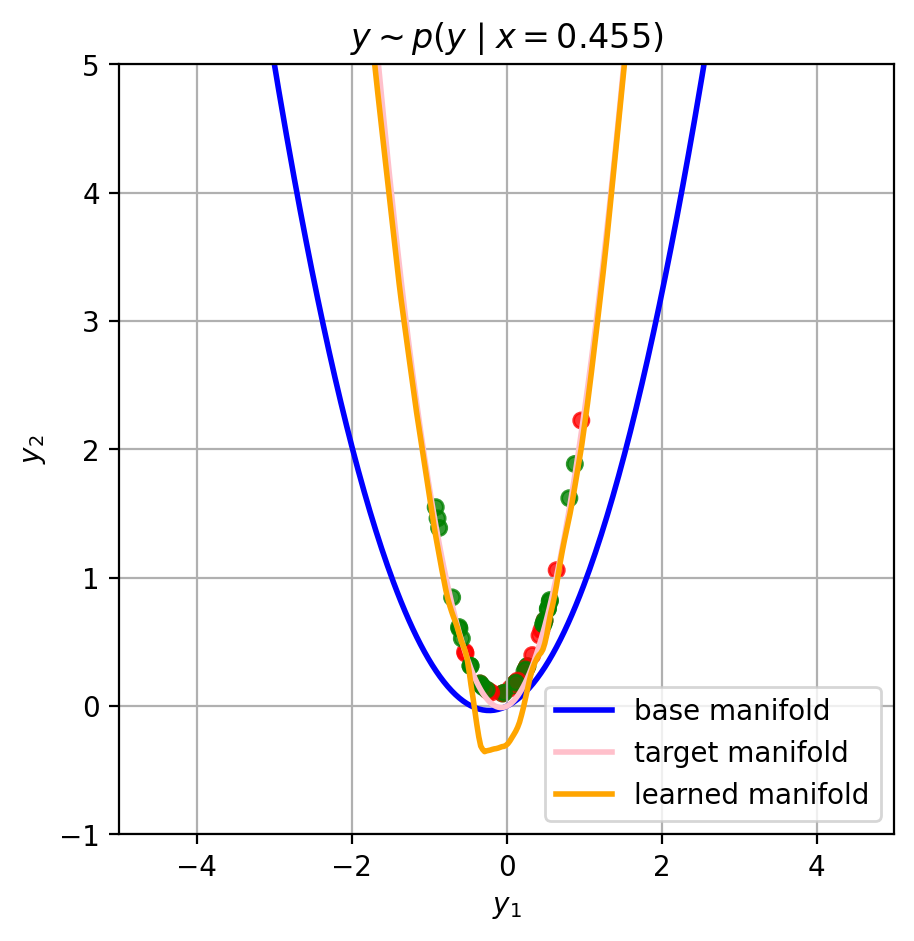

[1/2000] -ELBO = 5.344629764556885
[2/2000] -ELBO = 5.240566730499268
[3/2000] -ELBO = 5.1407246589660645
[4/2000] -ELBO = 5.043243885040283
[5/2000] -ELBO = 4.9483795166015625
[6/2000] -ELBO = 4.855760097503662
[7/2000] -ELBO = 4.765517711639404
[8/2000] -ELBO = 4.677337169647217
[9/2000] -ELBO = 4.591677188873291
[10/2000] -ELBO = 4.508373737335205
[11/2000] -ELBO = 4.42731237411499
[12/2000] -ELBO = 4.34849739074707
[13/2000] -ELBO = 4.271629810333252
[14/2000] -ELBO = 4.196938991546631
[15/2000] -ELBO = 4.12434196472168
[16/2000] -ELBO = 4.055543422698975
[17/2000] -ELBO = 3.98620343208313
[18/2000] -ELBO = 3.9207162857055664
[19/2000] -ELBO = 3.857062816619873
[20/2000] -ELBO = 3.7967116832733154
[21/2000] -ELBO = 3.737201452255249
[22/2000] -ELBO = 3.679331064224243
[23/2000] -ELBO = 3.624337911605835
[24/2000] -ELBO = 3.5761990547180176
[25/2000] -ELBO = 3.522583484649658
[26/2000] -ELBO = 3.4711742401123047
[27/2000] -ELBO = 3.4285366535186768
[28/2000] -ELBO = 3.38354611396789

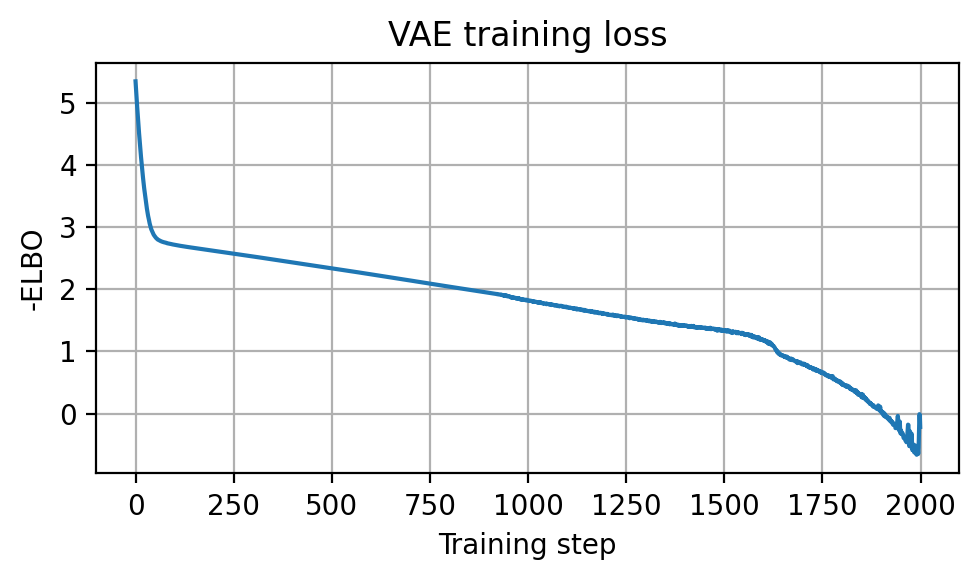

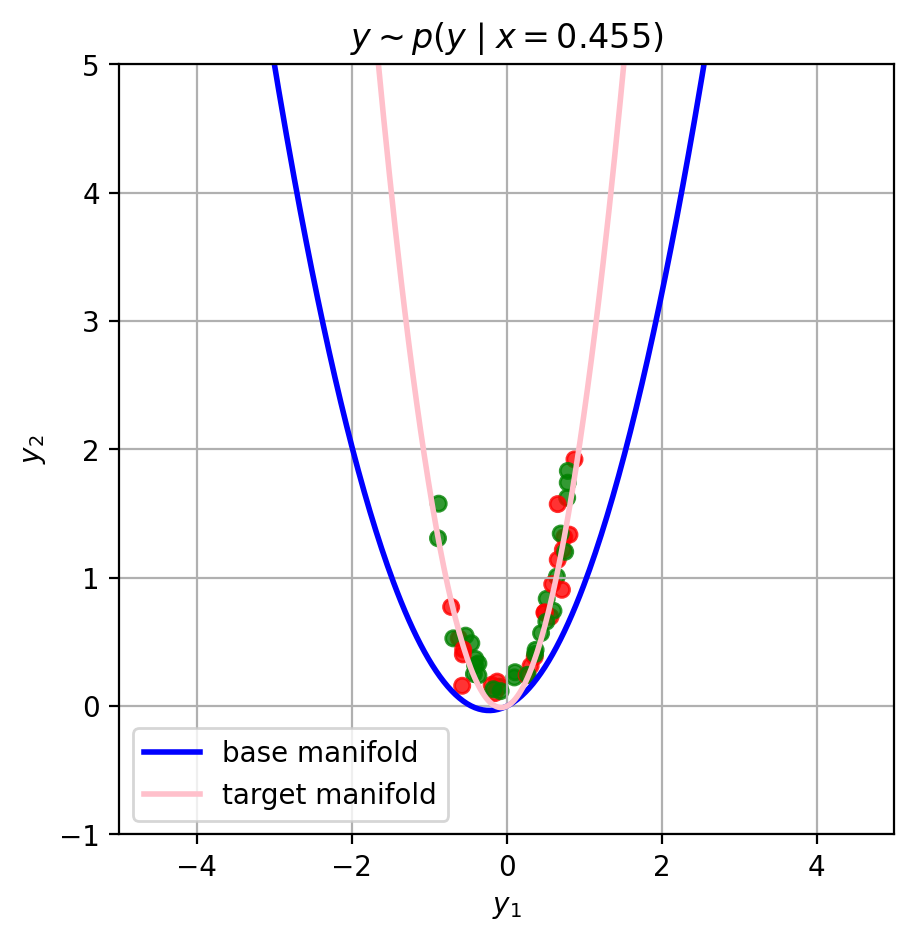

[1/1000] NLL = 0.5089
[2/1000] NLL = 0.5570
[3/1000] NLL = 0.5101
[4/1000] NLL = 0.5192
[5/1000] NLL = 0.5446
[6/1000] NLL = 0.5239
[7/1000] NLL = 0.5202
[8/1000] NLL = 0.5115
[9/1000] NLL = 0.4991
[10/1000] NLL = 0.5239
[11/1000] NLL = 0.5179
[12/1000] NLL = 0.4800
[13/1000] NLL = 0.5157
[14/1000] NLL = 0.5010
[15/1000] NLL = 0.5127
[16/1000] NLL = 0.5378
[17/1000] NLL = 0.5148
[18/1000] NLL = 0.4997
[19/1000] NLL = 0.5129
[20/1000] NLL = 0.5037
[21/1000] NLL = 0.4836
[22/1000] NLL = 0.5149
[23/1000] NLL = 0.4773
[24/1000] NLL = 0.5018
[25/1000] NLL = 0.5253
[26/1000] NLL = 0.5111
[27/1000] NLL = 0.4866
[28/1000] NLL = 0.5111
[29/1000] NLL = 0.5061
[30/1000] NLL = 0.4813
[31/1000] NLL = 0.5338
[32/1000] NLL = 0.4982
[33/1000] NLL = 0.5123
[34/1000] NLL = 0.4730
[35/1000] NLL = 0.4786
[36/1000] NLL = 0.5009
[37/1000] NLL = 0.5092
[38/1000] NLL = 0.5059
[39/1000] NLL = 0.5099
[40/1000] NLL = 0.4819
[41/1000] NLL = 0.5057
[42/1000] NLL = 0.5087
[43/1000] NLL = 0.4636
[44/1000] NLL = 0.49

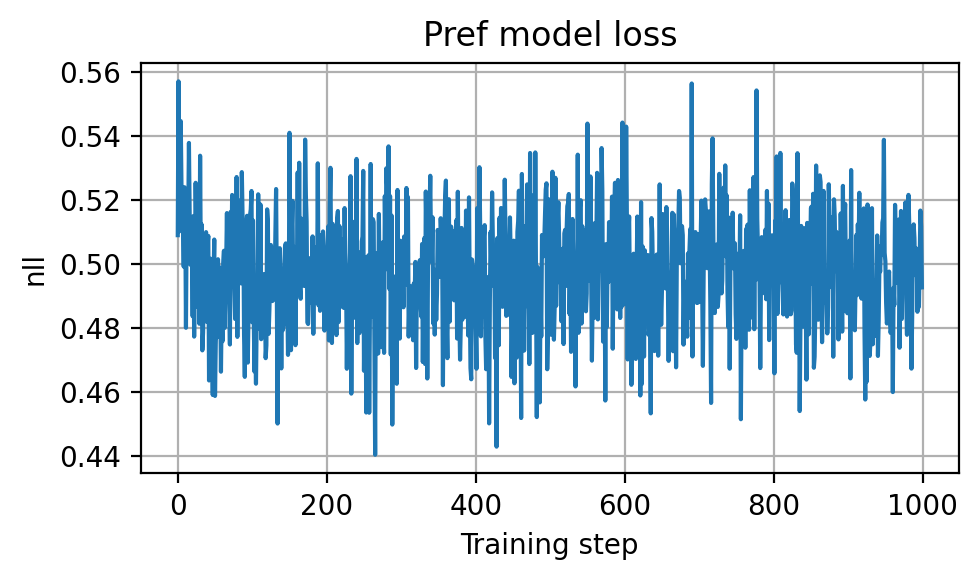

Dataset composition (likes/dislikes):   0.4995819926261902 / 0.5004180073738098
ACC(learned vs GT):   0.9868879914283752 / 0.5038440227508545
y2_learned.shape =  (400,)
y2_learned[190:210] =  [ 0.08239765  0.07186808  0.05762732  0.03468077  0.01163599 -0.011416
 -0.03513767 -0.0489708  -0.06181848 -0.0688884  -0.06233895 -0.05304302
 -0.03967489 -0.01167013  0.01176699  0.02765159  0.05130048  0.08376168
  0.11562388  0.14016299]


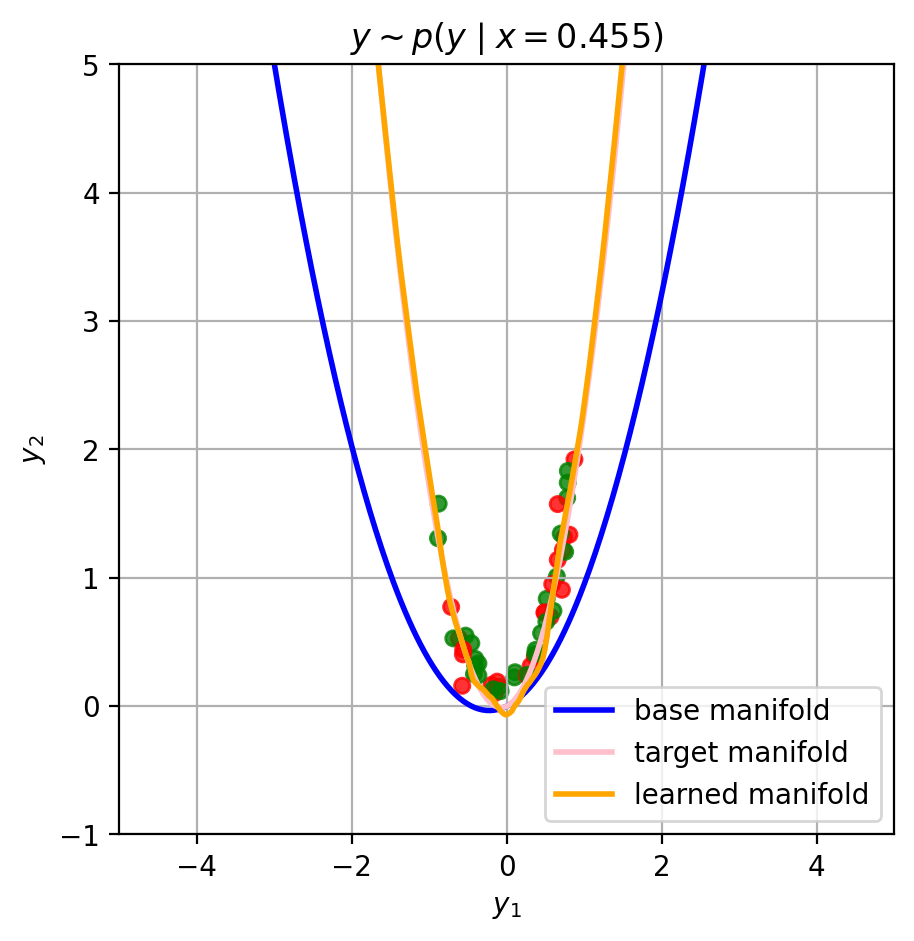

[1/1000] loss = 0.2304
[2/1000] loss = 0.2007
[3/1000] loss = 0.1788
[4/1000] loss = 0.1733
[5/1000] loss = 0.1687
[6/1000] loss = 0.1764
[7/1000] loss = 0.1778
[8/1000] loss = 0.1735
[9/1000] loss = 0.1739
[10/1000] loss = 0.1708
[11/1000] loss = 0.1648
[12/1000] loss = 0.1643
[13/1000] loss = 0.1627
[14/1000] loss = 0.1612
[15/1000] loss = 0.1631
[16/1000] loss = 0.1662
[17/1000] loss = 0.1625
[18/1000] loss = 0.1592
[19/1000] loss = 0.1601
[20/1000] loss = 0.1603
[21/1000] loss = 0.1610
[22/1000] loss = 0.1584
[23/1000] loss = 0.1579
[24/1000] loss = 0.1578
[25/1000] loss = 0.1584
[26/1000] loss = 0.1588
[27/1000] loss = 0.1559
[28/1000] loss = 0.1619
[29/1000] loss = 0.1588
[30/1000] loss = 0.1583
[31/1000] loss = 0.1610
[32/1000] loss = 0.1561
[33/1000] loss = 0.1585
[34/1000] loss = 0.1571
[35/1000] loss = 0.1543
[36/1000] loss = 0.1576
[37/1000] loss = 0.1574
[38/1000] loss = 0.1598
[39/1000] loss = 0.1587
[40/1000] loss = 0.1582
[41/1000] loss = 0.1555
[42/1000] loss = 0.1567
[

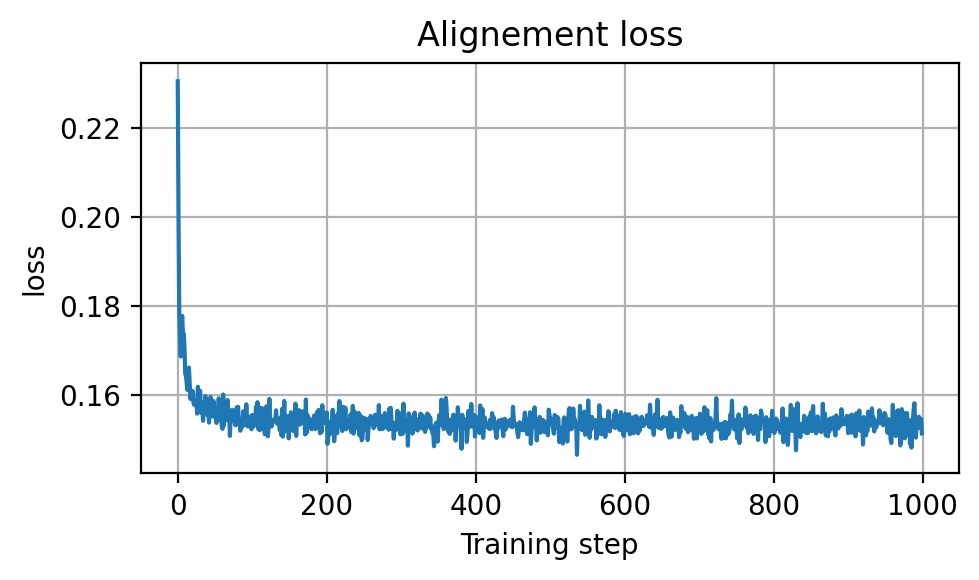

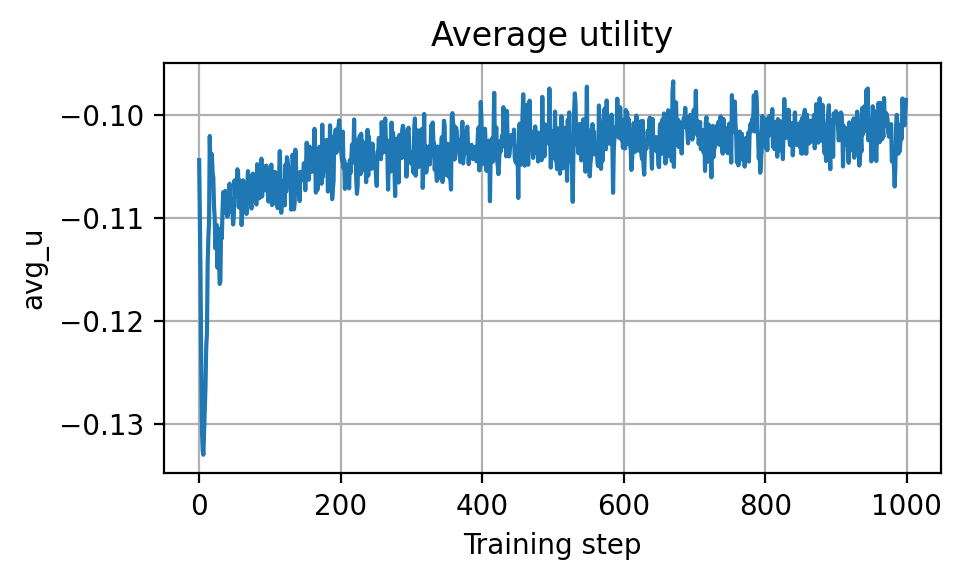

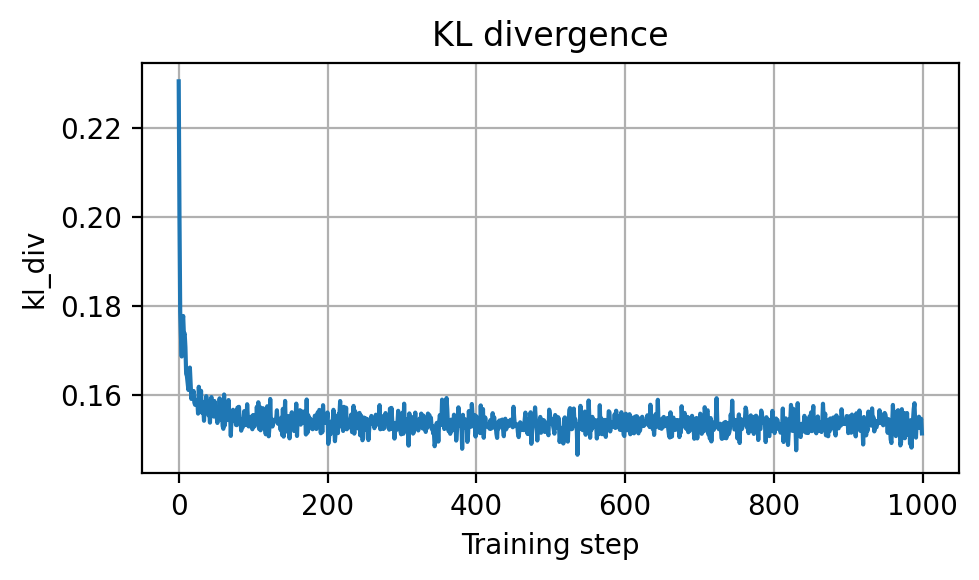

y2_learned.shape =  (400,)
y2_learned[190:210] =  [ 0.08239765  0.07186808  0.05762732  0.03468077  0.01163599 -0.011416
 -0.03513767 -0.0489708  -0.06181848 -0.0688884  -0.06233895 -0.05304302
 -0.03967489 -0.01167013  0.01176699  0.02765159  0.05130048  0.08376168
  0.11562388  0.14016299]


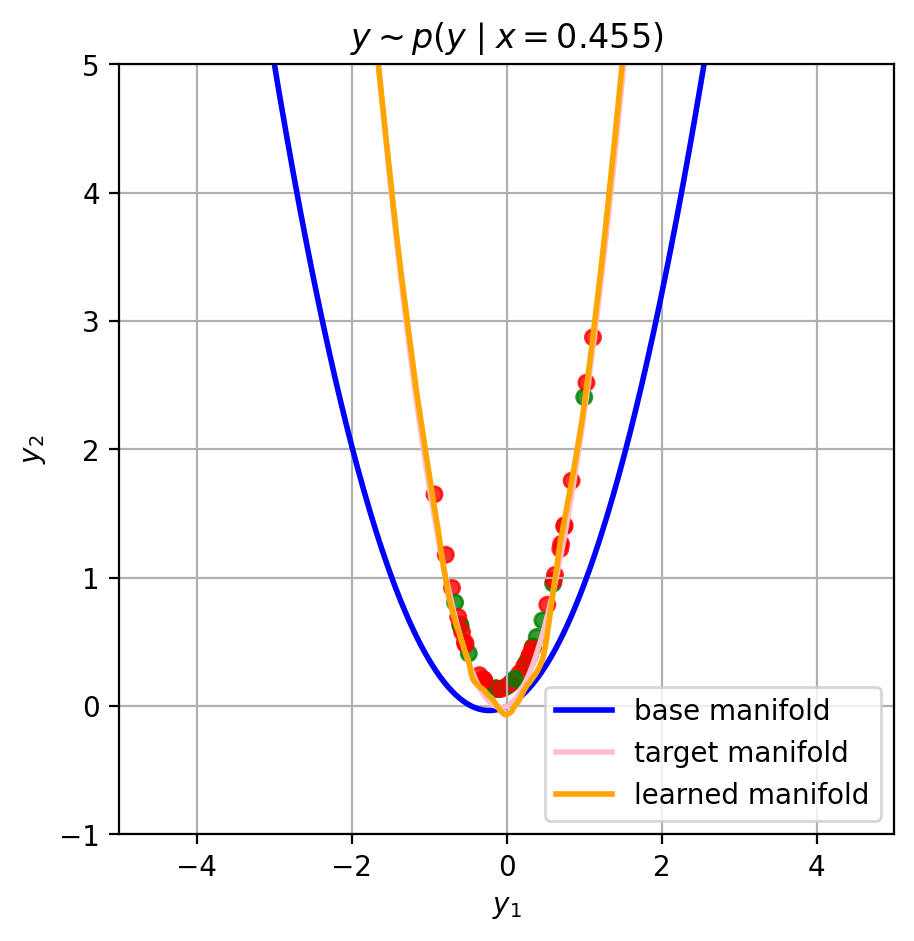

[1/2000] -ELBO = 5.258176803588867
[2/2000] -ELBO = 5.145342826843262
[3/2000] -ELBO = 5.036048889160156
[4/2000] -ELBO = 4.930488109588623
[5/2000] -ELBO = 4.828540325164795
[6/2000] -ELBO = 4.729741096496582
[7/2000] -ELBO = 4.6343302726745605
[8/2000] -ELBO = 4.54202938079834
[9/2000] -ELBO = 4.45303201675415
[10/2000] -ELBO = 4.36647891998291
[11/2000] -ELBO = 4.2825140953063965
[12/2000] -ELBO = 4.201479434967041
[13/2000] -ELBO = 4.122924327850342
[14/2000] -ELBO = 4.047443866729736
[15/2000] -ELBO = 3.973153829574585
[16/2000] -ELBO = 3.902083396911621
[17/2000] -ELBO = 3.833101749420166
[18/2000] -ELBO = 3.7667453289031982
[19/2000] -ELBO = 3.7031447887420654
[20/2000] -ELBO = 3.640902280807495
[21/2000] -ELBO = 3.5821545124053955
[22/2000] -ELBO = 3.526956558227539
[23/2000] -ELBO = 3.4754672050476074
[24/2000] -ELBO = 3.4240453243255615
[25/2000] -ELBO = 3.3729288578033447
[26/2000] -ELBO = 3.3247904777526855
[27/2000] -ELBO = 3.2807888984680176
[28/2000] -ELBO = 3.2382900714

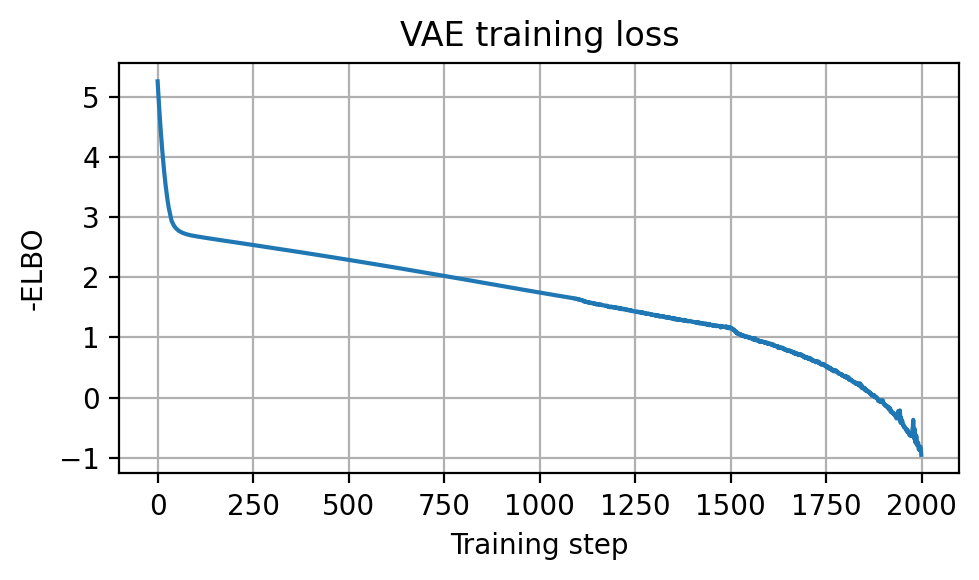

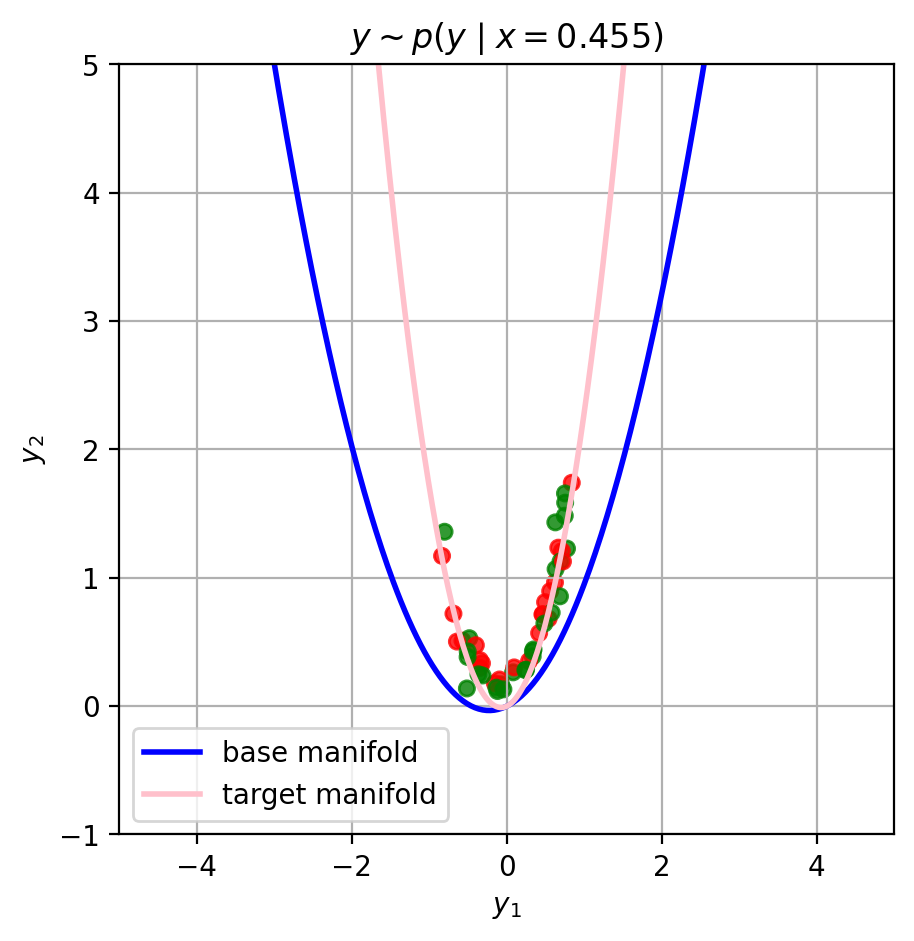

[1/1000] NLL = 0.5351
[2/1000] NLL = 0.5418
[3/1000] NLL = 0.5446
[4/1000] NLL = 0.5457
[5/1000] NLL = 0.5817
[6/1000] NLL = 0.5594
[7/1000] NLL = 0.5487
[8/1000] NLL = 0.5372
[9/1000] NLL = 0.5681
[10/1000] NLL = 0.5416
[11/1000] NLL = 0.5332
[12/1000] NLL = 0.5450
[13/1000] NLL = 0.5355
[14/1000] NLL = 0.5159
[15/1000] NLL = 0.5600
[16/1000] NLL = 0.5817
[17/1000] NLL = 0.5207
[18/1000] NLL = 0.5184
[19/1000] NLL = 0.5442
[20/1000] NLL = 0.5422
[21/1000] NLL = 0.5354
[22/1000] NLL = 0.5492
[23/1000] NLL = 0.5613
[24/1000] NLL = 0.5395
[25/1000] NLL = 0.5470
[26/1000] NLL = 0.5365
[27/1000] NLL = 0.5342
[28/1000] NLL = 0.5682
[29/1000] NLL = 0.5349
[30/1000] NLL = 0.5360
[31/1000] NLL = 0.5708
[32/1000] NLL = 0.5611
[33/1000] NLL = 0.5450
[34/1000] NLL = 0.5496
[35/1000] NLL = 0.5237
[36/1000] NLL = 0.5294
[37/1000] NLL = 0.5703
[38/1000] NLL = 0.5292
[39/1000] NLL = 0.5467
[40/1000] NLL = 0.5389
[41/1000] NLL = 0.5519
[42/1000] NLL = 0.5030
[43/1000] NLL = 0.5427
[44/1000] NLL = 0.53

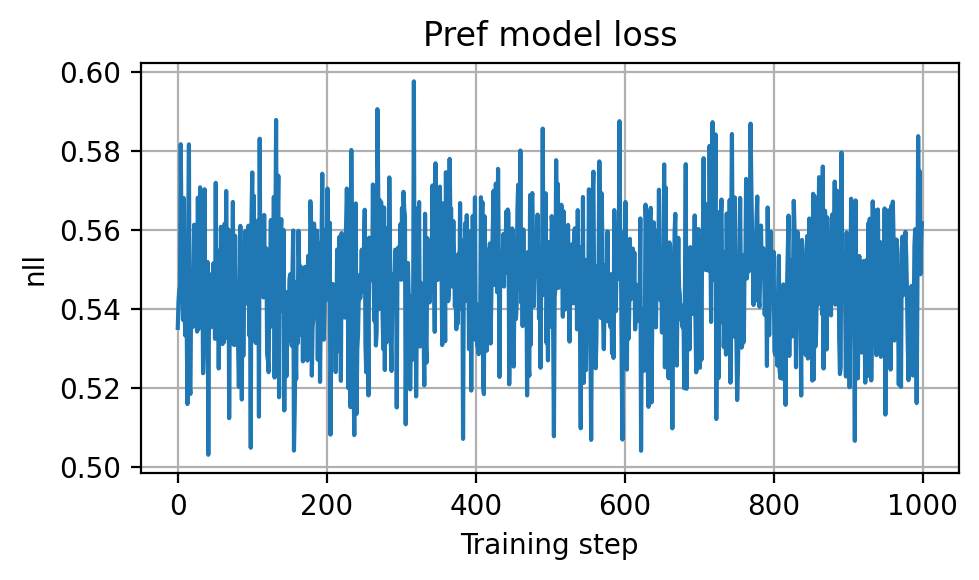

Dataset composition (likes/dislikes):   0.5013779997825623 / 0.49862200021743774
ACC(learned vs GT):   0.9932399988174438 / 0.505374014377594
y2_learned.shape =  (400,)
y2_learned[190:210] =  [-6.70929626e-02 -7.61806667e-02 -8.31466317e-02 -9.52015072e-02
 -1.03710622e-01 -1.00696914e-01 -9.25724134e-02 -7.80559108e-02
 -5.85632995e-02 -3.15196738e-02 -4.21330333e-05  3.30873951e-02
  6.42517284e-02  1.02086879e-01  1.38602495e-01  1.63207859e-01
  1.83264077e-01  2.05207437e-01  2.24720210e-01  2.39404231e-01]


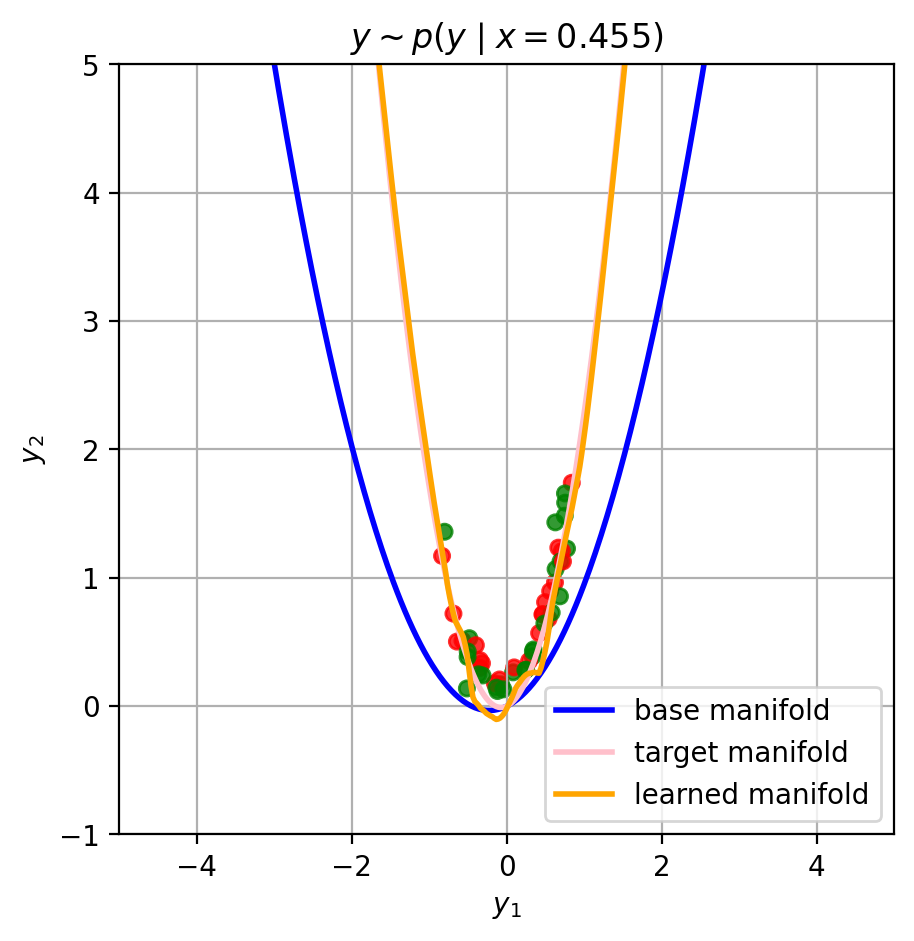

[1/1000] loss = 0.1030
[2/1000] loss = 0.1009
[3/1000] loss = 0.0801
[4/1000] loss = 0.0832
[5/1000] loss = 0.0885
[6/1000] loss = 0.0860
[7/1000] loss = 0.0833
[8/1000] loss = 0.0841
[9/1000] loss = 0.0817
[10/1000] loss = 0.0791
[11/1000] loss = 0.0770
[12/1000] loss = 0.0773
[13/1000] loss = 0.0778
[14/1000] loss = 0.0789
[15/1000] loss = 0.0766
[16/1000] loss = 0.0764
[17/1000] loss = 0.0776
[18/1000] loss = 0.0772
[19/1000] loss = 0.0758
[20/1000] loss = 0.0770
[21/1000] loss = 0.0752
[22/1000] loss = 0.0745
[23/1000] loss = 0.0768
[24/1000] loss = 0.0752
[25/1000] loss = 0.0742
[26/1000] loss = 0.0742
[27/1000] loss = 0.0732
[28/1000] loss = 0.0736
[29/1000] loss = 0.0751
[30/1000] loss = 0.0738
[31/1000] loss = 0.0722
[32/1000] loss = 0.0715
[33/1000] loss = 0.0747
[34/1000] loss = 0.0731
[35/1000] loss = 0.0741
[36/1000] loss = 0.0737
[37/1000] loss = 0.0717
[38/1000] loss = 0.0737
[39/1000] loss = 0.0724
[40/1000] loss = 0.0738
[41/1000] loss = 0.0734
[42/1000] loss = 0.0742
[

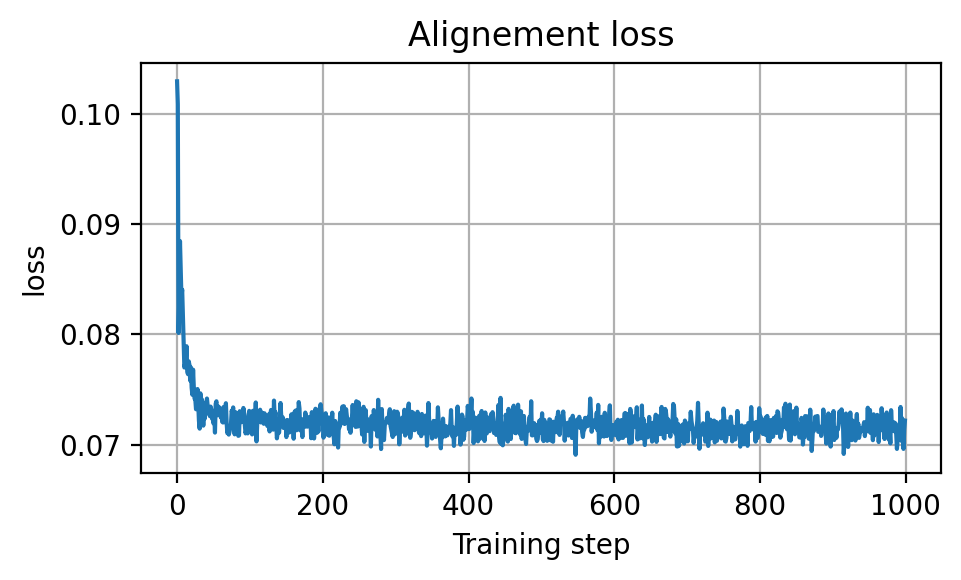

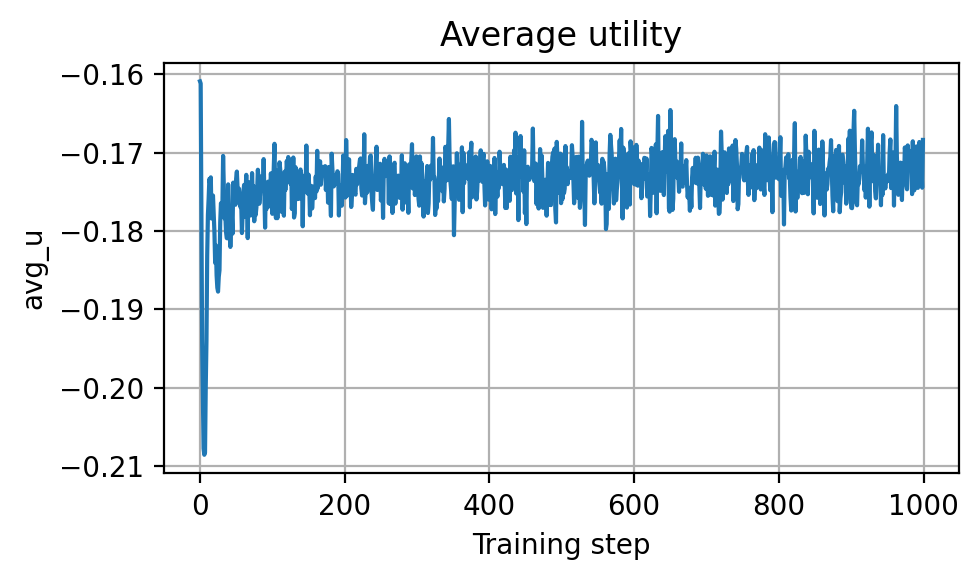

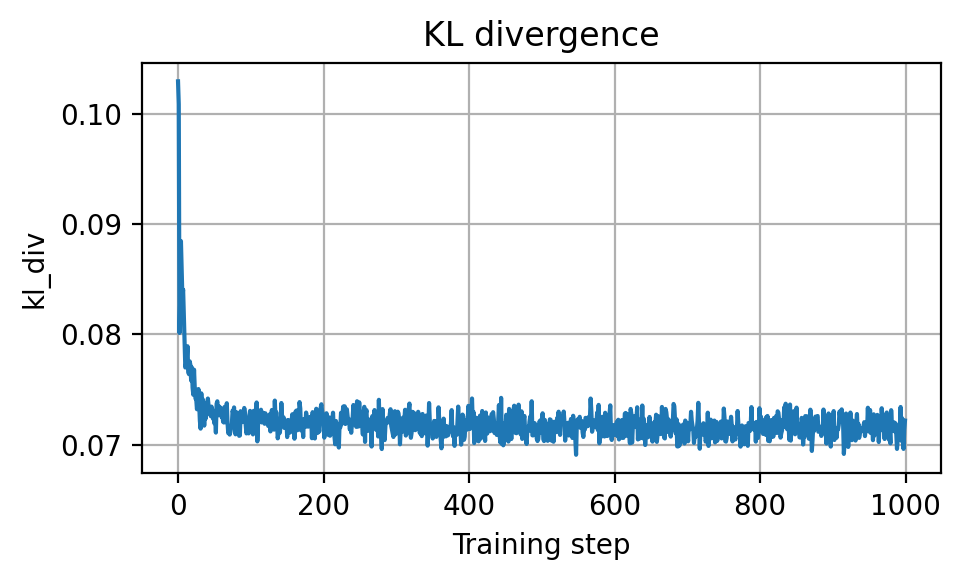

y2_learned.shape =  (400,)
y2_learned[190:210] =  [-6.70929626e-02 -7.61806667e-02 -8.31466317e-02 -9.52015072e-02
 -1.03710622e-01 -1.00696914e-01 -9.25724134e-02 -7.80559108e-02
 -5.85632995e-02 -3.15196738e-02 -4.21330333e-05  3.30873951e-02
  6.42517284e-02  1.02086879e-01  1.38602495e-01  1.63207859e-01
  1.83264077e-01  2.05207437e-01  2.24720210e-01  2.39404231e-01]


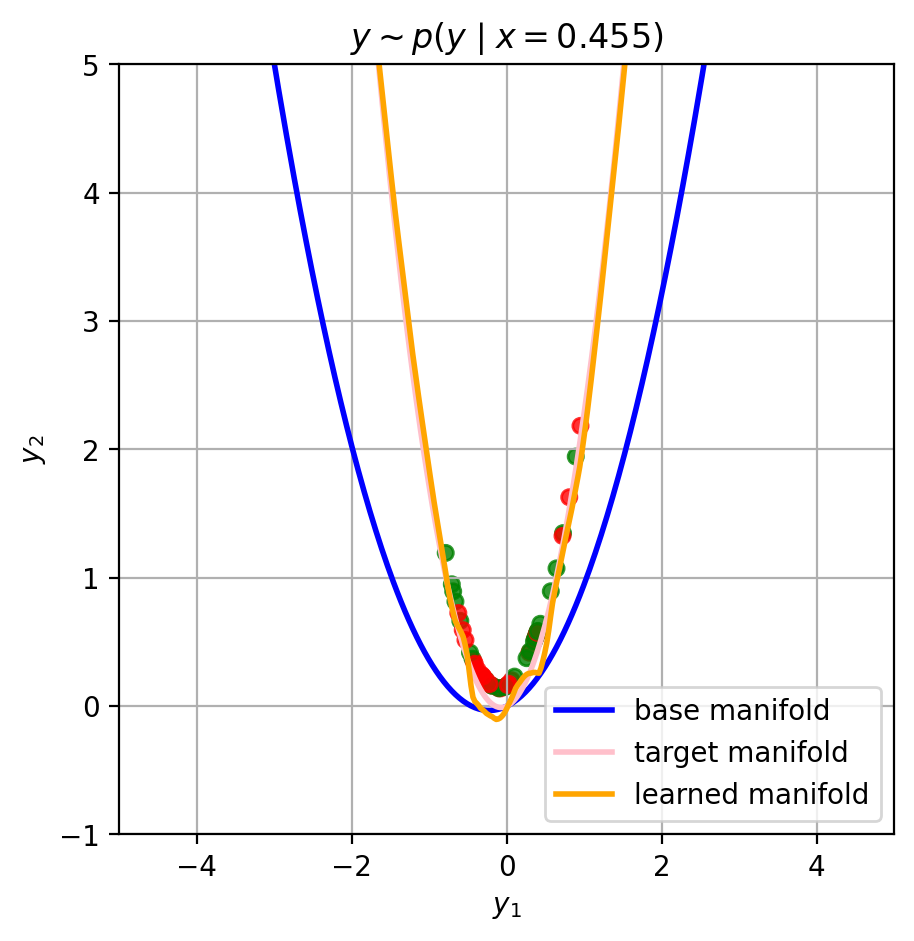

[1/2000] -ELBO = 5.152241230010986
[2/2000] -ELBO = 5.0453782081604
[3/2000] -ELBO = 4.942142963409424
[4/2000] -ELBO = 4.842257022857666
[5/2000] -ELBO = 4.745739936828613
[6/2000] -ELBO = 4.652340412139893
[7/2000] -ELBO = 4.561832904815674
[8/2000] -ELBO = 4.4741668701171875
[9/2000] -ELBO = 4.388820648193359
[10/2000] -ELBO = 4.3060526847839355
[11/2000] -ELBO = 4.225971221923828
[12/2000] -ELBO = 4.1480255126953125
[13/2000] -ELBO = 4.072815895080566
[14/2000] -ELBO = 3.999624490737915
[15/2000] -ELBO = 3.9280552864074707
[16/2000] -ELBO = 3.8600432872772217
[17/2000] -ELBO = 3.7933990955352783
[18/2000] -ELBO = 3.729468584060669
[19/2000] -ELBO = 3.6664042472839355
[20/2000] -ELBO = 3.605891704559326
[21/2000] -ELBO = 3.5490682125091553
[22/2000] -ELBO = 3.4935381412506104
[23/2000] -ELBO = 3.439502239227295
[24/2000] -ELBO = 3.387653112411499
[25/2000] -ELBO = 3.3407459259033203
[26/2000] -ELBO = 3.292811632156372
[27/2000] -ELBO = 3.248703718185425
[28/2000] -ELBO = 3.207066774

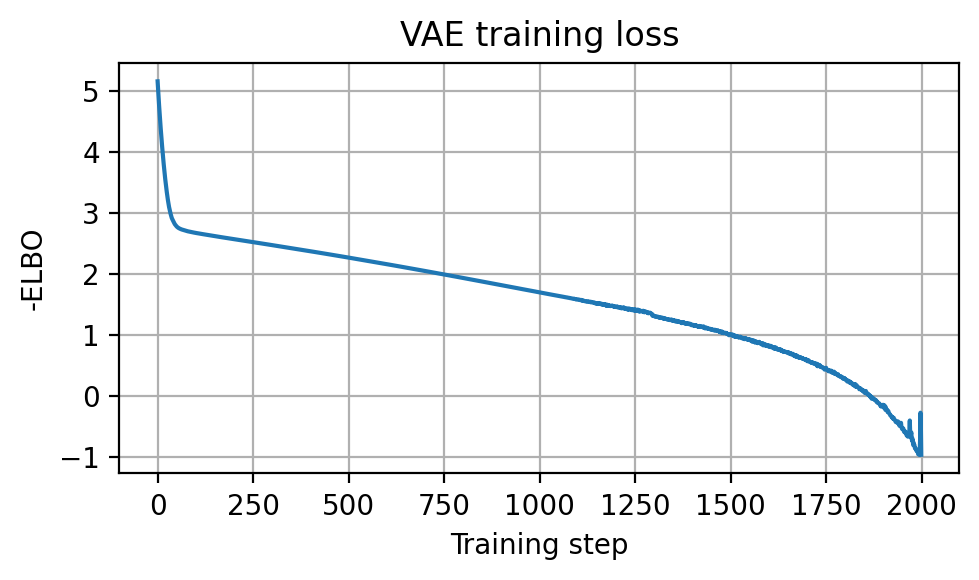

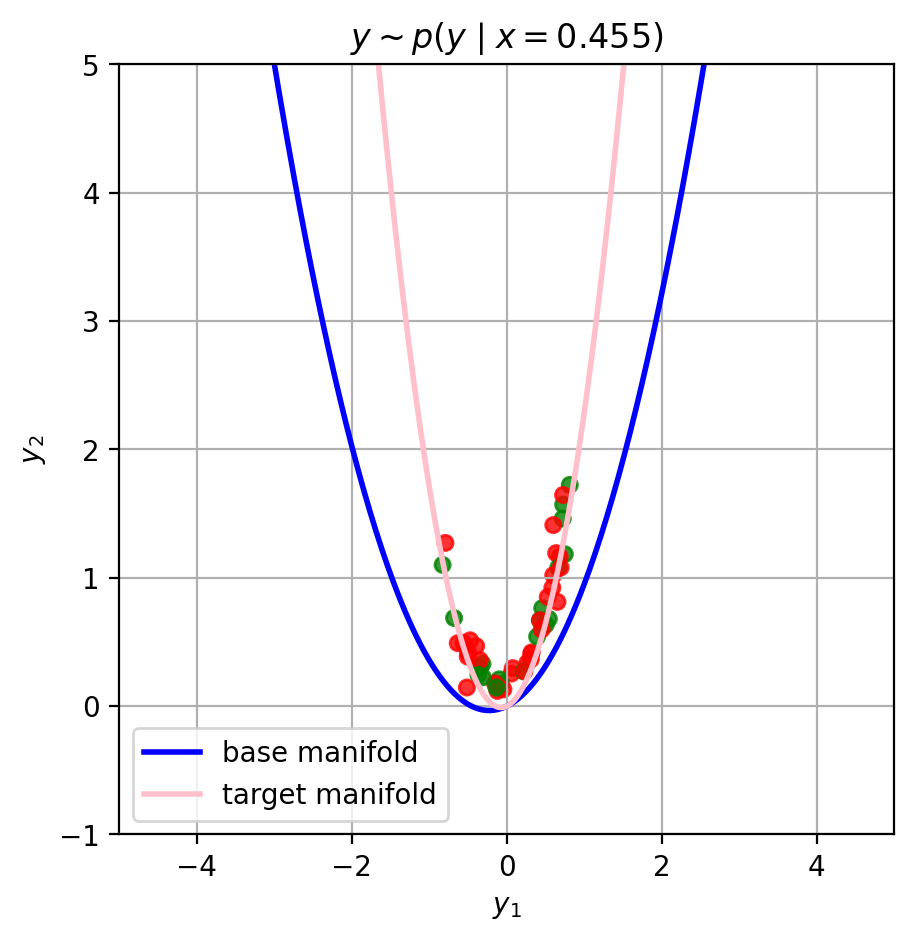

[1/1000] NLL = 0.5416
[2/1000] NLL = 0.5812
[3/1000] NLL = 0.5850
[4/1000] NLL = 0.5763
[5/1000] NLL = 0.5529
[6/1000] NLL = 0.5735
[7/1000] NLL = 0.5795
[8/1000] NLL = 0.5666
[9/1000] NLL = 0.5647
[10/1000] NLL = 0.5819
[11/1000] NLL = 0.5637
[12/1000] NLL = 0.5812
[13/1000] NLL = 0.5492
[14/1000] NLL = 0.5664
[15/1000] NLL = 0.5702
[16/1000] NLL = 0.5964
[17/1000] NLL = 0.5817
[18/1000] NLL = 0.5574
[19/1000] NLL = 0.5788
[20/1000] NLL = 0.5703
[21/1000] NLL = 0.5731
[22/1000] NLL = 0.5790
[23/1000] NLL = 0.5661
[24/1000] NLL = 0.5675
[25/1000] NLL = 0.5788
[26/1000] NLL = 0.5537
[27/1000] NLL = 0.5831
[28/1000] NLL = 0.5832
[29/1000] NLL = 0.5669
[30/1000] NLL = 0.5614
[31/1000] NLL = 0.5501
[32/1000] NLL = 0.5771
[33/1000] NLL = 0.5824
[34/1000] NLL = 0.5873
[35/1000] NLL = 0.5532
[36/1000] NLL = 0.5606
[37/1000] NLL = 0.5803
[38/1000] NLL = 0.5837
[39/1000] NLL = 0.5734
[40/1000] NLL = 0.6004
[41/1000] NLL = 0.5674
[42/1000] NLL = 0.5824
[43/1000] NLL = 0.5665
[44/1000] NLL = 0.57

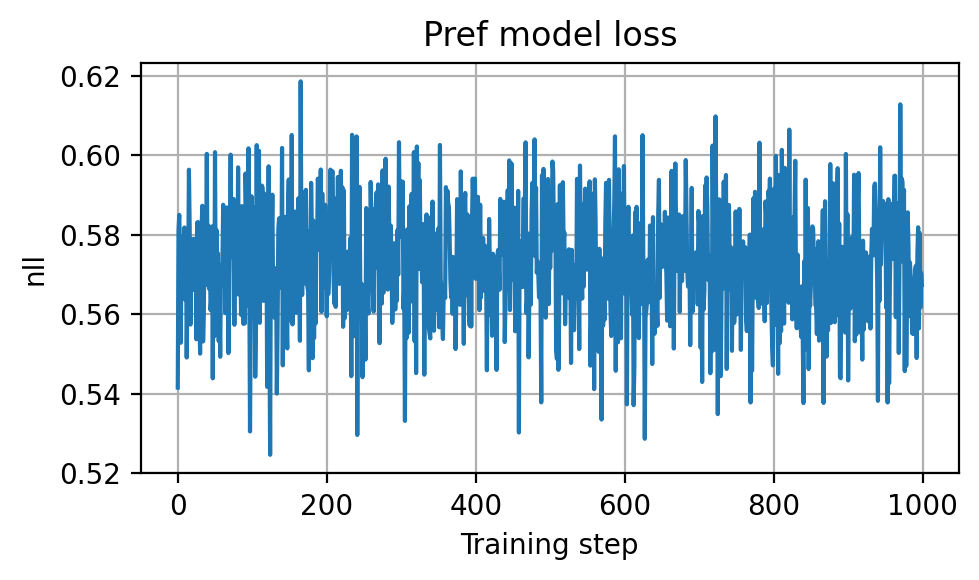

Dataset composition (likes/dislikes):   0.500652015209198 / 0.499347984790802
ACC(learned vs GT):   0.9895939826965332 / 0.5083460211753845
y2_learned.shape =  (400,)
y2_learned[190:210] =  [-0.1567221  -0.17099488 -0.18762645 -0.1978372  -0.20623156 -0.22399557
 -0.23476851 -0.23428553 -0.23006704 -0.21749261 -0.19917792 -0.18177755
 -0.15980804 -0.13287492 -0.10392579 -0.07792711 -0.05092378 -0.02523118
  0.00049048  0.02309401]


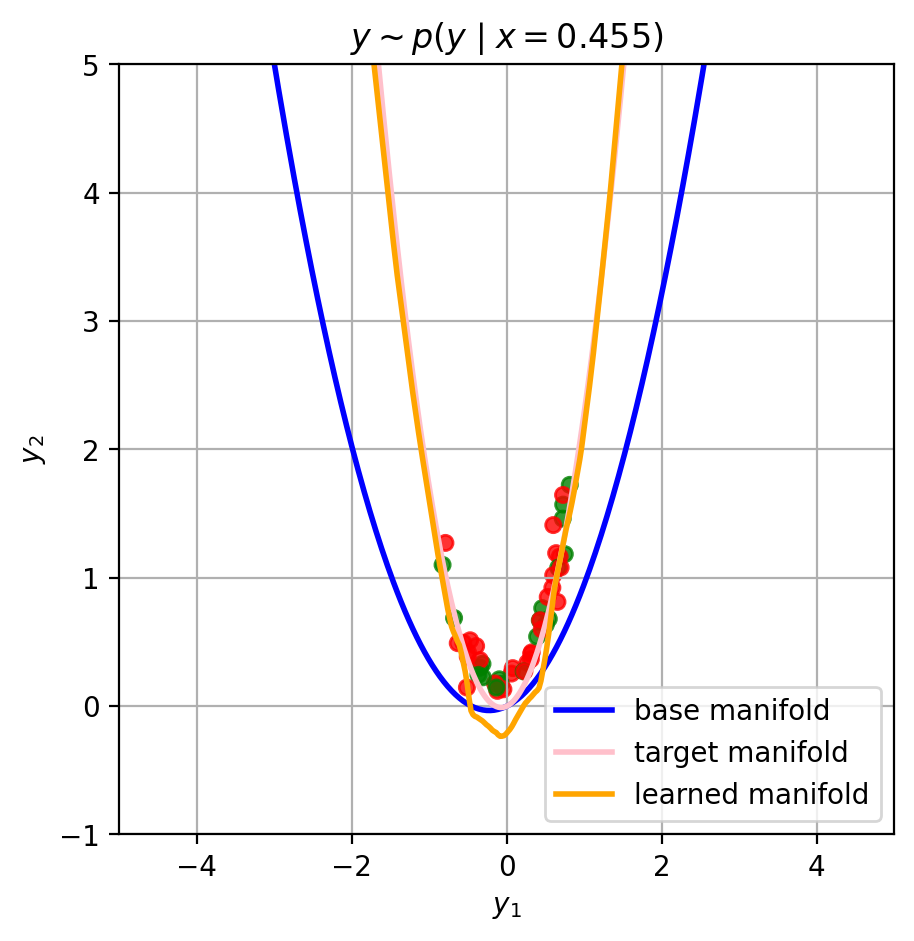

[1/1000] loss = 0.0529
[2/1000] loss = 0.0483
[3/1000] loss = 0.0415
[4/1000] loss = 0.0452
[5/1000] loss = 0.0455
[6/1000] loss = 0.0429
[7/1000] loss = 0.0418
[8/1000] loss = 0.0415
[9/1000] loss = 0.0397
[10/1000] loss = 0.0398
[11/1000] loss = 0.0405
[12/1000] loss = 0.0419
[13/1000] loss = 0.0396
[14/1000] loss = 0.0400
[15/1000] loss = 0.0385
[16/1000] loss = 0.0376
[17/1000] loss = 0.0386
[18/1000] loss = 0.0385
[19/1000] loss = 0.0382
[20/1000] loss = 0.0384
[21/1000] loss = 0.0390
[22/1000] loss = 0.0386
[23/1000] loss = 0.0378
[24/1000] loss = 0.0379
[25/1000] loss = 0.0388
[26/1000] loss = 0.0384
[27/1000] loss = 0.0376
[28/1000] loss = 0.0375
[29/1000] loss = 0.0377
[30/1000] loss = 0.0372
[31/1000] loss = 0.0380
[32/1000] loss = 0.0374
[33/1000] loss = 0.0378
[34/1000] loss = 0.0379
[35/1000] loss = 0.0379
[36/1000] loss = 0.0375
[37/1000] loss = 0.0370
[38/1000] loss = 0.0380
[39/1000] loss = 0.0374
[40/1000] loss = 0.0367
[41/1000] loss = 0.0374
[42/1000] loss = 0.0371
[

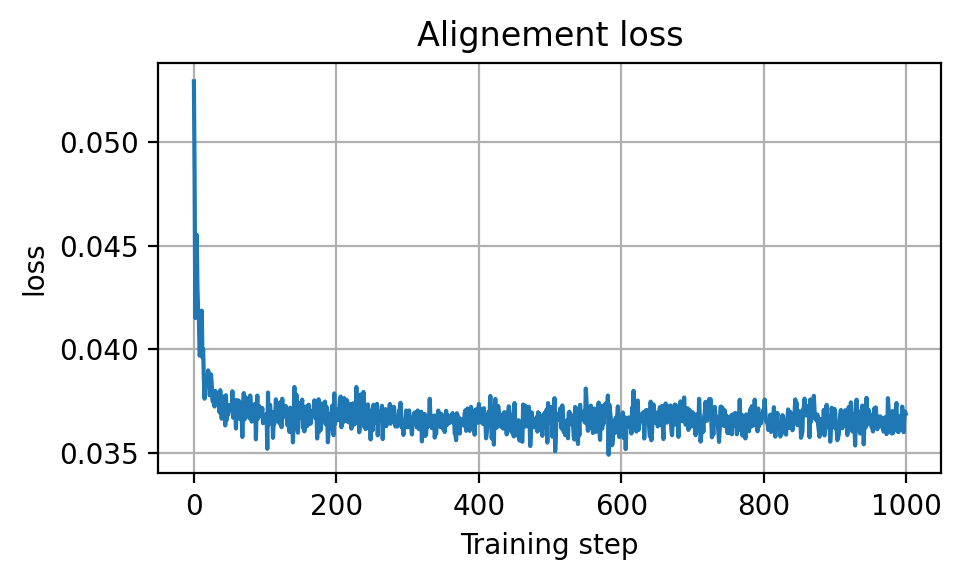

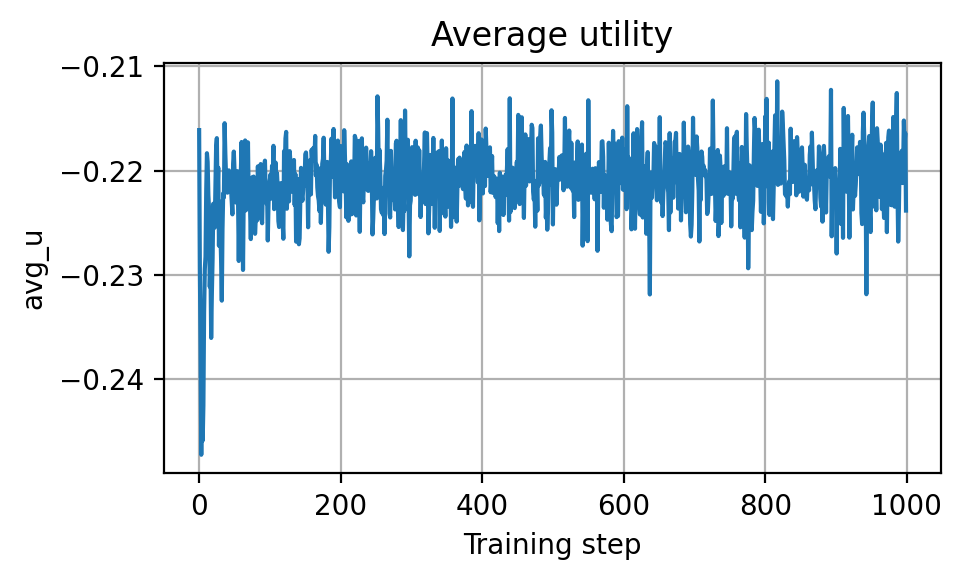

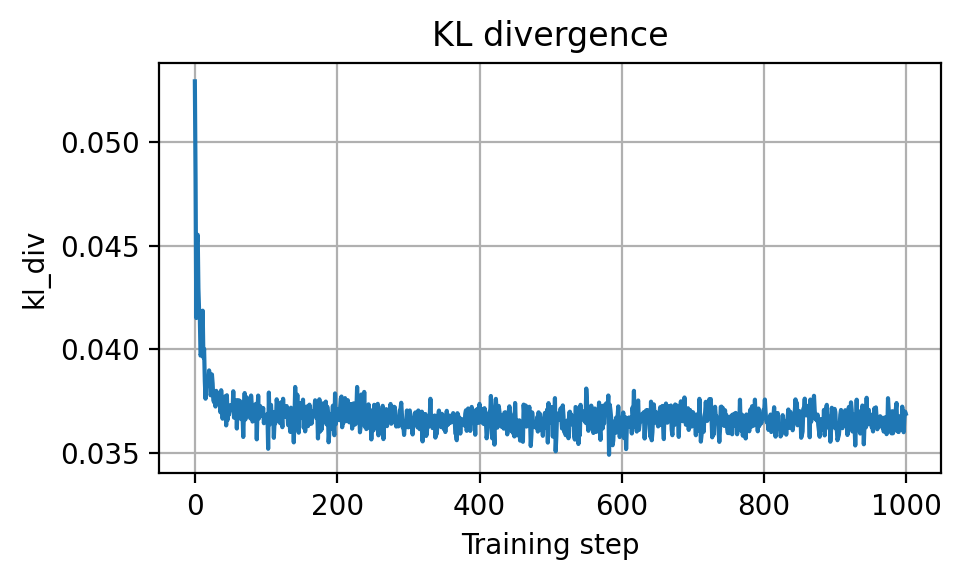

y2_learned.shape =  (400,)
y2_learned[190:210] =  [-0.1567221  -0.17099488 -0.18762645 -0.1978372  -0.20623156 -0.22399557
 -0.23476851 -0.23428553 -0.23006704 -0.21749261 -0.19917792 -0.18177755
 -0.15980804 -0.13287492 -0.10392579 -0.07792711 -0.05092378 -0.02523118
  0.00049048  0.02309401]


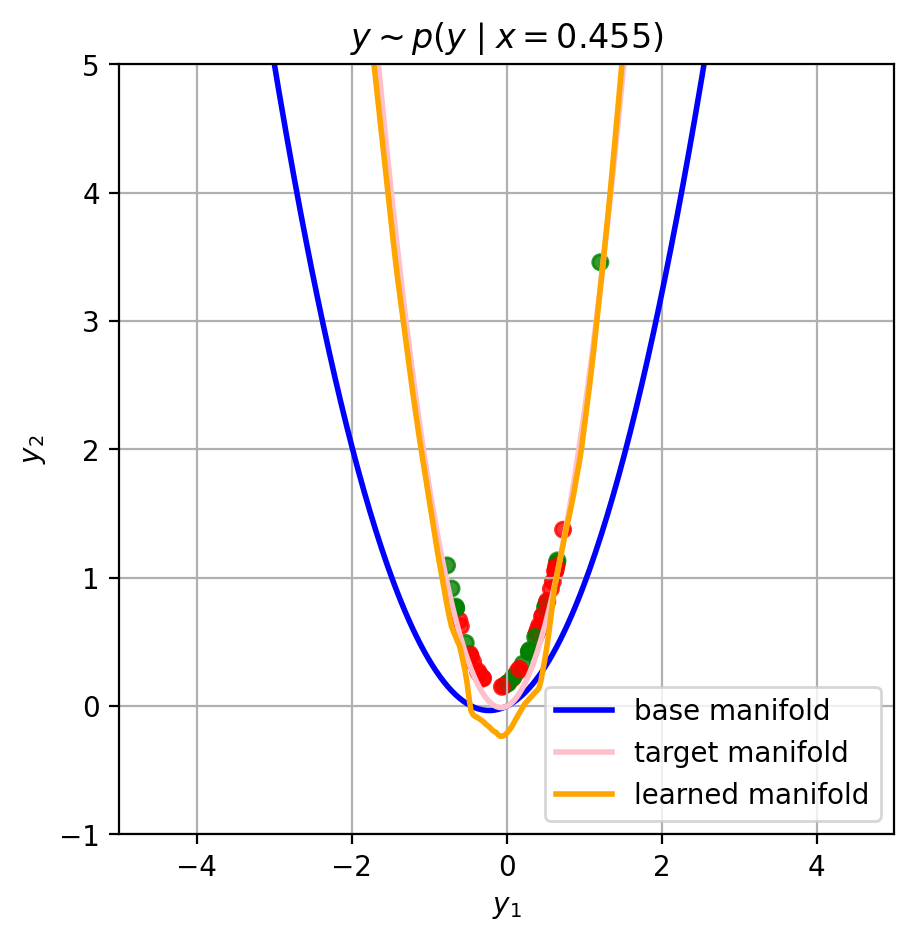

[1/2000] -ELBO = 5.074638843536377
[2/2000] -ELBO = 4.97031307220459
[3/2000] -ELBO = 4.869007110595703
[4/2000] -ELBO = 4.7702155113220215
[5/2000] -ELBO = 4.673945903778076
[6/2000] -ELBO = 4.580012321472168
[7/2000] -ELBO = 4.488483428955078
[8/2000] -ELBO = 4.399207592010498
[9/2000] -ELBO = 4.312167644500732
[10/2000] -ELBO = 4.227174758911133
[11/2000] -ELBO = 4.1450514793396
[12/2000] -ELBO = 4.064155578613281
[13/2000] -ELBO = 3.986422061920166
[14/2000] -ELBO = 3.910242795944214
[15/2000] -ELBO = 3.8366053104400635
[16/2000] -ELBO = 3.766008138656616
[17/2000] -ELBO = 3.6967787742614746
[18/2000] -ELBO = 3.630141258239746
[19/2000] -ELBO = 3.5657503604888916
[20/2000] -ELBO = 3.503859281539917
[21/2000] -ELBO = 3.4451334476470947
[22/2000] -ELBO = 3.3887741565704346
[23/2000] -ELBO = 3.3348569869995117
[24/2000] -ELBO = 3.284475326538086
[25/2000] -ELBO = 3.2379417419433594
[26/2000] -ELBO = 3.1931912899017334
[27/2000] -ELBO = 3.1547625064849854
[28/2000] -ELBO = 3.1170988082

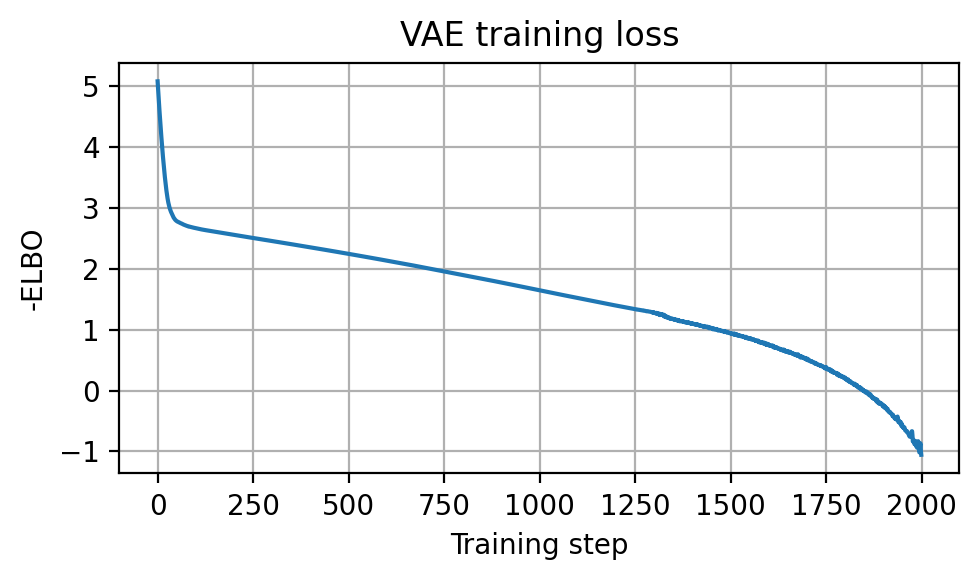

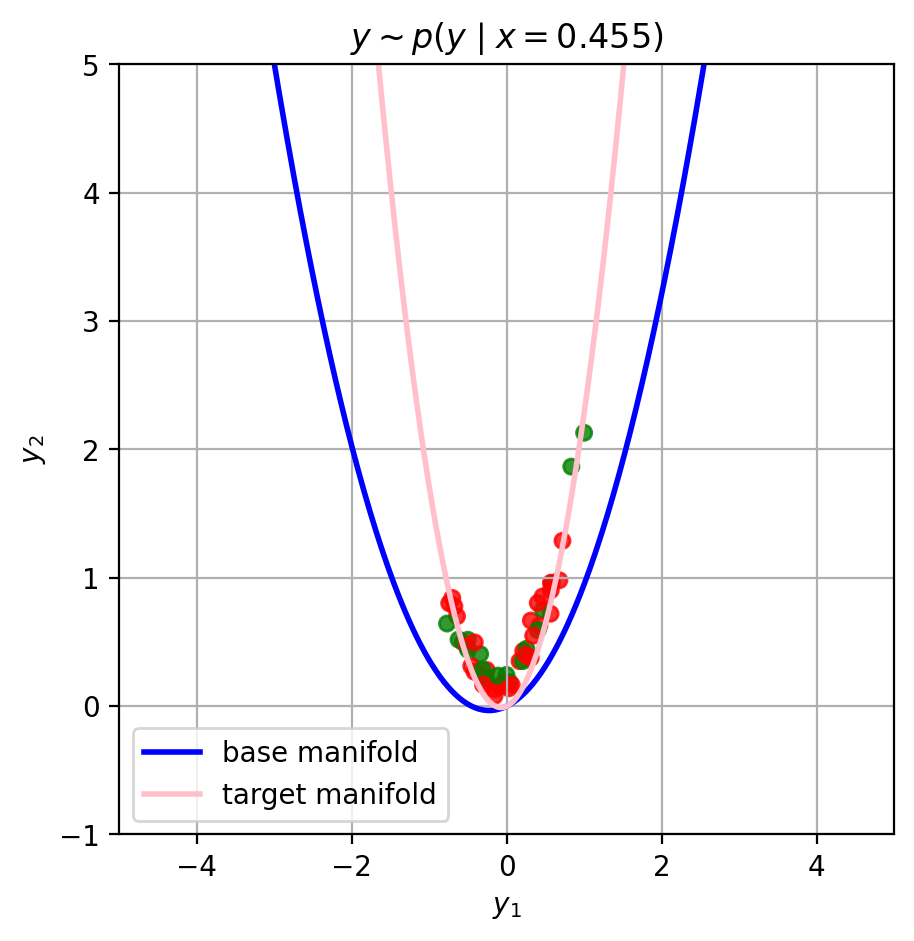

[1/1000] NLL = 0.6201
[2/1000] NLL = 0.5991
[3/1000] NLL = 0.5641
[4/1000] NLL = 0.6014
[5/1000] NLL = 0.5947
[6/1000] NLL = 0.5810
[7/1000] NLL = 0.5911
[8/1000] NLL = 0.6093
[9/1000] NLL = 0.5945
[10/1000] NLL = 0.5978
[11/1000] NLL = 0.5951
[12/1000] NLL = 0.5578
[13/1000] NLL = 0.5893
[14/1000] NLL = 0.6051
[15/1000] NLL = 0.5732
[16/1000] NLL = 0.5952
[17/1000] NLL = 0.6112
[18/1000] NLL = 0.5917
[19/1000] NLL = 0.5496
[20/1000] NLL = 0.5920
[21/1000] NLL = 0.5846
[22/1000] NLL = 0.5938
[23/1000] NLL = 0.6075
[24/1000] NLL = 0.5963
[25/1000] NLL = 0.5793
[26/1000] NLL = 0.5724
[27/1000] NLL = 0.5837
[28/1000] NLL = 0.5700
[29/1000] NLL = 0.5906
[30/1000] NLL = 0.5808
[31/1000] NLL = 0.5943
[32/1000] NLL = 0.5928
[33/1000] NLL = 0.5856
[34/1000] NLL = 0.5889
[35/1000] NLL = 0.5839
[36/1000] NLL = 0.5816
[37/1000] NLL = 0.5932
[38/1000] NLL = 0.5937
[39/1000] NLL = 0.6025
[40/1000] NLL = 0.5783
[41/1000] NLL = 0.5812
[42/1000] NLL = 0.6107
[43/1000] NLL = 0.6051
[44/1000] NLL = 0.59

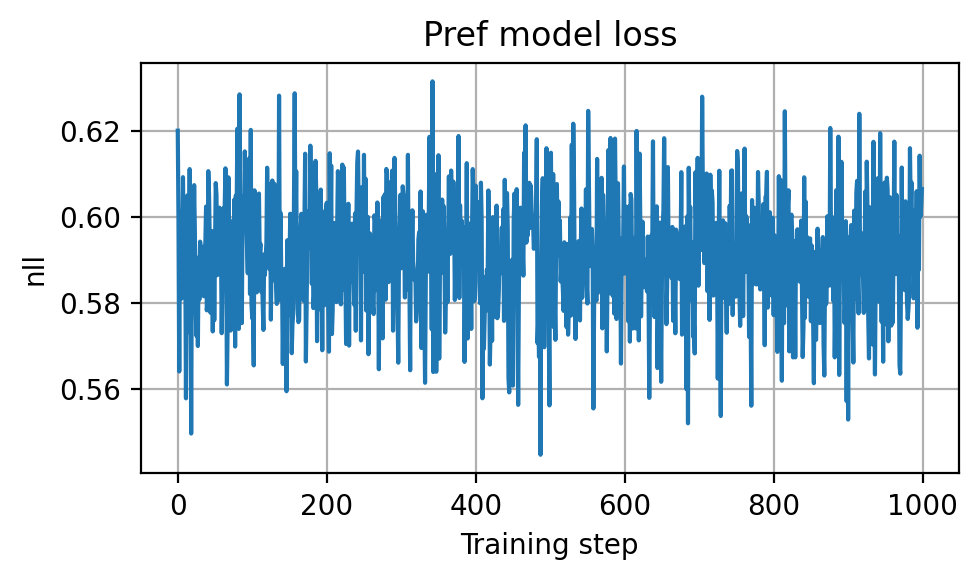

Dataset composition (likes/dislikes):   0.5007619857788086 / 0.4992380142211914
ACC(learned vs GT):   0.9925280213356018 / 0.5079939961433411
y2_learned.shape =  (400,)
y2_learned[190:210] =  [ 0.01669248 -0.01084204 -0.03085304 -0.05040716 -0.06801356 -0.08492115
 -0.11129566 -0.11600411 -0.11412182 -0.10003221 -0.08153992 -0.06386991
 -0.04579173 -0.02393384 -0.00136582  0.01871293  0.03817112  0.06027798
  0.08459412  0.10780594]


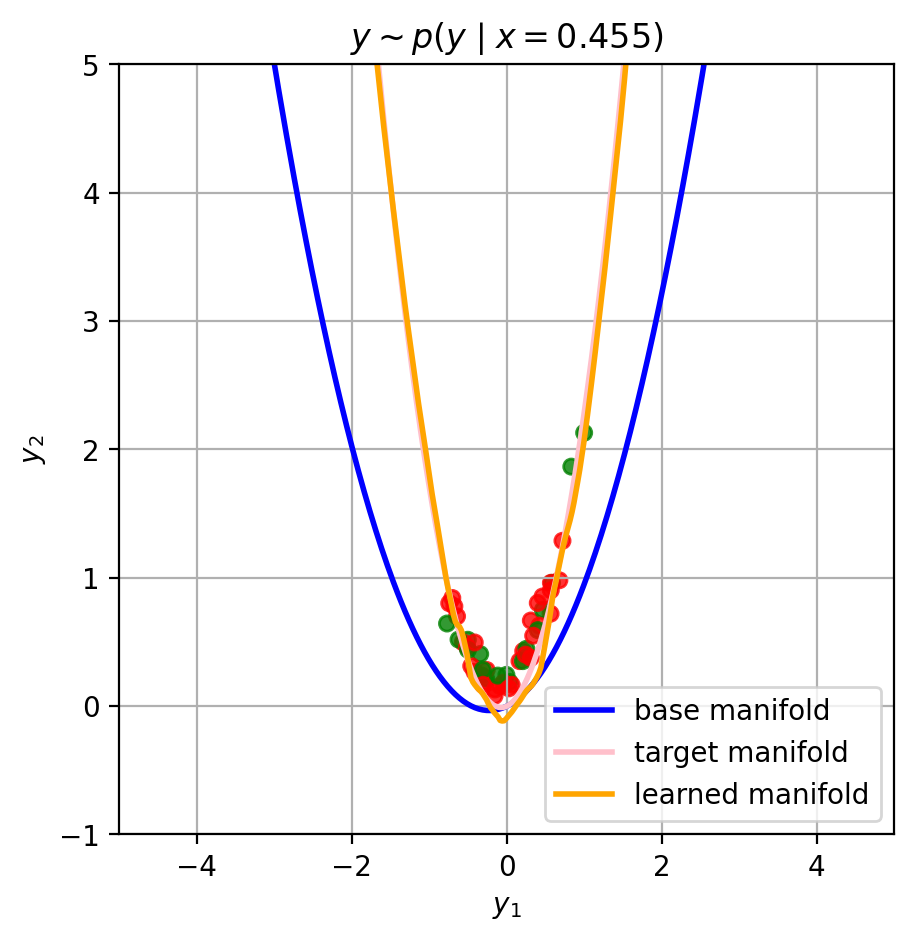

[1/1000] loss = 0.0315
[2/1000] loss = 0.0310
[3/1000] loss = 0.0278
[4/1000] loss = 0.0291
[5/1000] loss = 0.0292
[6/1000] loss = 0.0284
[7/1000] loss = 0.0262
[8/1000] loss = 0.0261
[9/1000] loss = 0.0262
[10/1000] loss = 0.0267
[11/1000] loss = 0.0262
[12/1000] loss = 0.0263
[13/1000] loss = 0.0242
[14/1000] loss = 0.0241
[15/1000] loss = 0.0248
[16/1000] loss = 0.0258
[17/1000] loss = 0.0263
[18/1000] loss = 0.0250
[19/1000] loss = 0.0246
[20/1000] loss = 0.0244
[21/1000] loss = 0.0256
[22/1000] loss = 0.0243
[23/1000] loss = 0.0250
[24/1000] loss = 0.0252
[25/1000] loss = 0.0248
[26/1000] loss = 0.0249
[27/1000] loss = 0.0241
[28/1000] loss = 0.0241
[29/1000] loss = 0.0243
[30/1000] loss = 0.0247
[31/1000] loss = 0.0241
[32/1000] loss = 0.0240
[33/1000] loss = 0.0243
[34/1000] loss = 0.0246
[35/1000] loss = 0.0243
[36/1000] loss = 0.0249
[37/1000] loss = 0.0239
[38/1000] loss = 0.0249
[39/1000] loss = 0.0235
[40/1000] loss = 0.0250
[41/1000] loss = 0.0240
[42/1000] loss = 0.0242
[

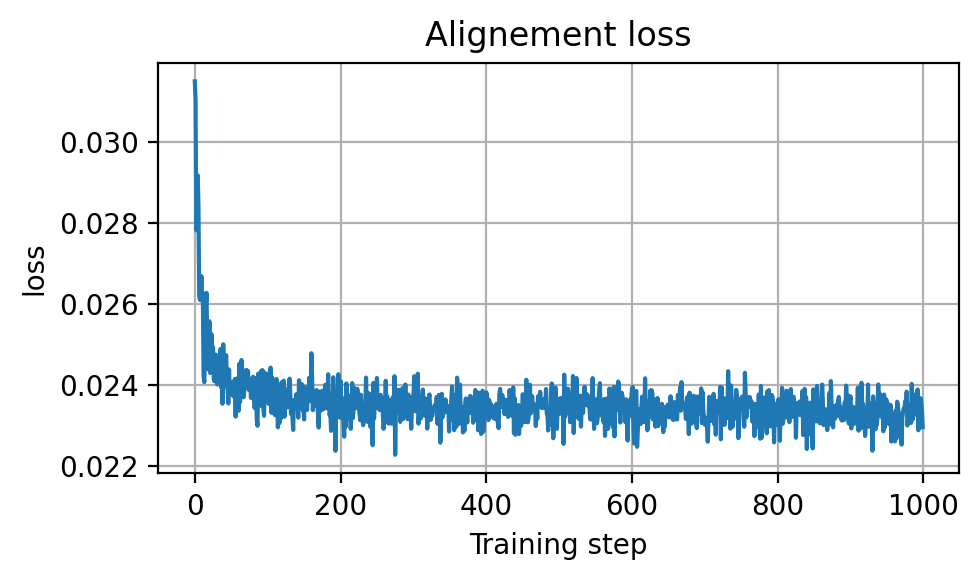

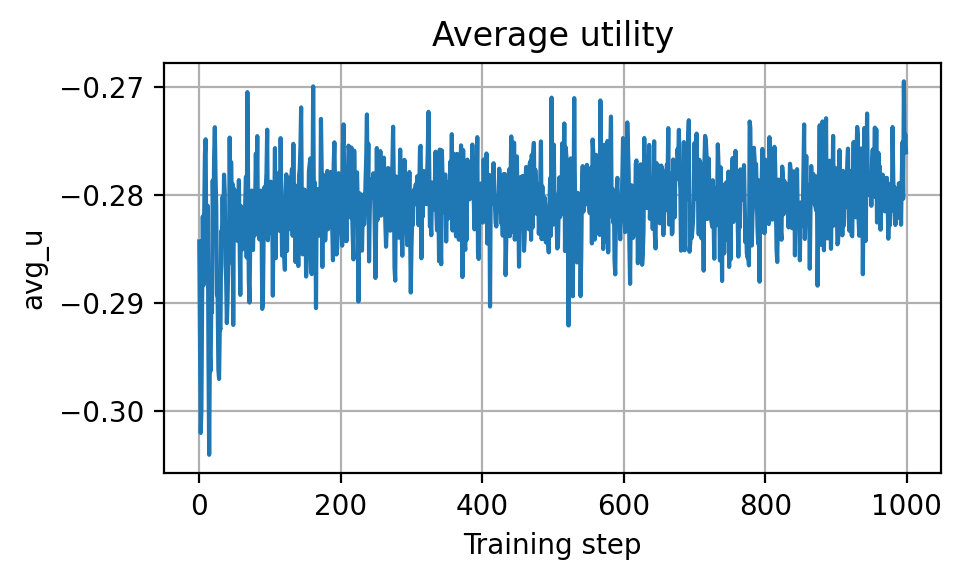

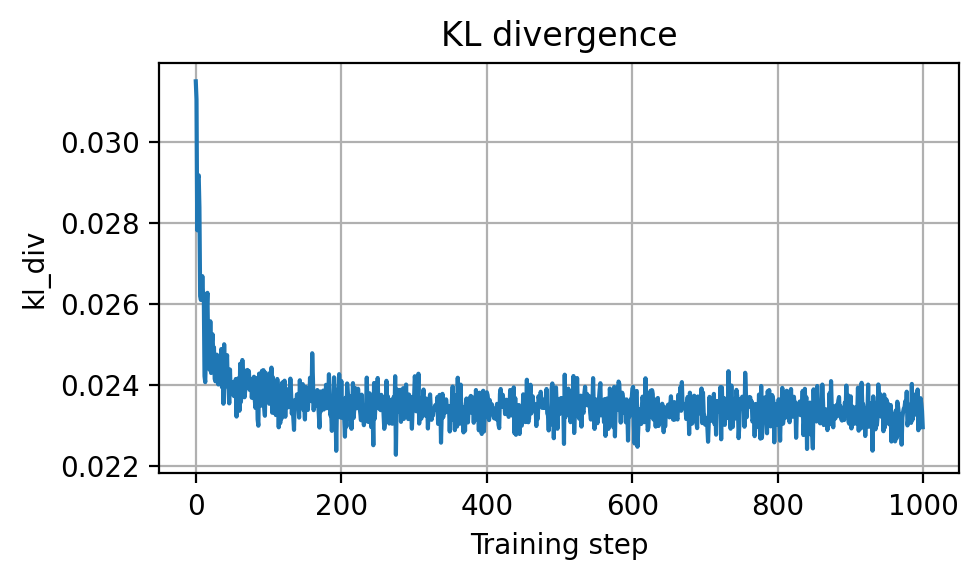

y2_learned.shape =  (400,)
y2_learned[190:210] =  [ 0.01669248 -0.01084204 -0.03085304 -0.05040716 -0.06801356 -0.08492115
 -0.11129566 -0.11600411 -0.11412182 -0.10003221 -0.08153992 -0.06386991
 -0.04579173 -0.02393384 -0.00136582  0.01871293  0.03817112  0.06027798
  0.08459412  0.10780594]


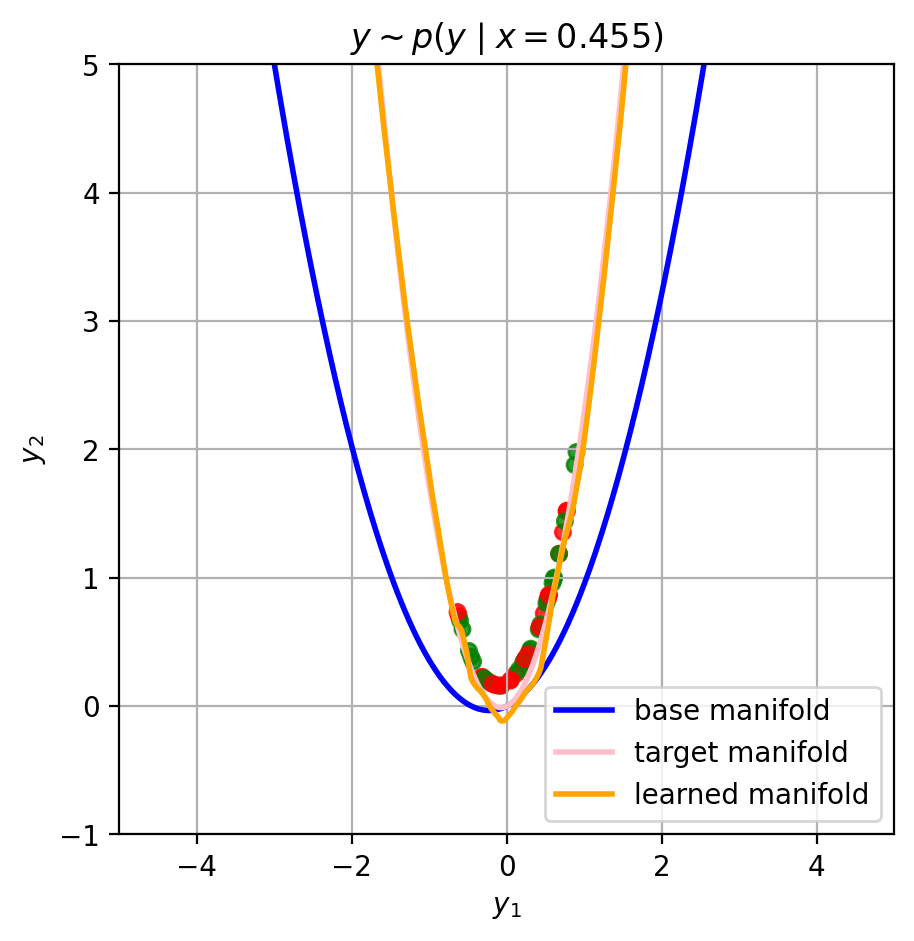

[1/2000] -ELBO = 5.060646057128906
[2/2000] -ELBO = 4.967739105224609
[3/2000] -ELBO = 4.87598991394043
[4/2000] -ELBO = 4.7855987548828125
[5/2000] -ELBO = 4.6966657638549805
[6/2000] -ELBO = 4.608906269073486
[7/2000] -ELBO = 4.52247953414917
[8/2000] -ELBO = 4.437582969665527
[9/2000] -ELBO = 4.354198932647705
[10/2000] -ELBO = 4.272660255432129
[11/2000] -ELBO = 4.192665100097656
[12/2000] -ELBO = 4.115044593811035
[13/2000] -ELBO = 4.038984298706055
[14/2000] -ELBO = 3.965704917907715
[15/2000] -ELBO = 3.894227981567383
[16/2000] -ELBO = 3.824997663497925
[17/2000] -ELBO = 3.7591800689697266
[18/2000] -ELBO = 3.6965956687927246
[19/2000] -ELBO = 3.6367812156677246
[20/2000] -ELBO = 3.5811288356781006
[21/2000] -ELBO = 3.5282561779022217
[22/2000] -ELBO = 3.479849100112915
[23/2000] -ELBO = 3.4357261657714844
[24/2000] -ELBO = 3.394544839859009
[25/2000] -ELBO = 3.3582656383514404
[26/2000] -ELBO = 3.323852300643921
[27/2000] -ELBO = 3.293764352798462
[28/2000] -ELBO = 3.2642791271

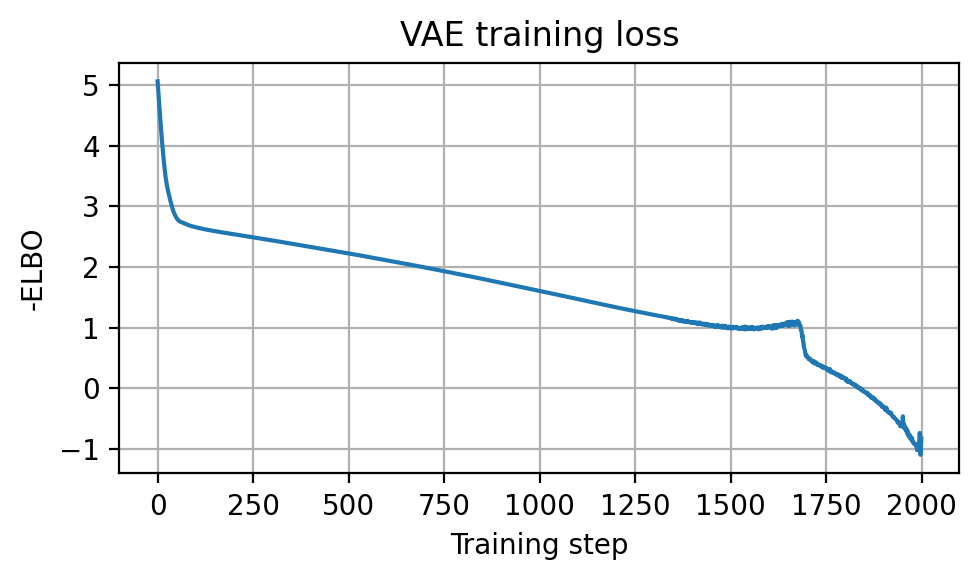

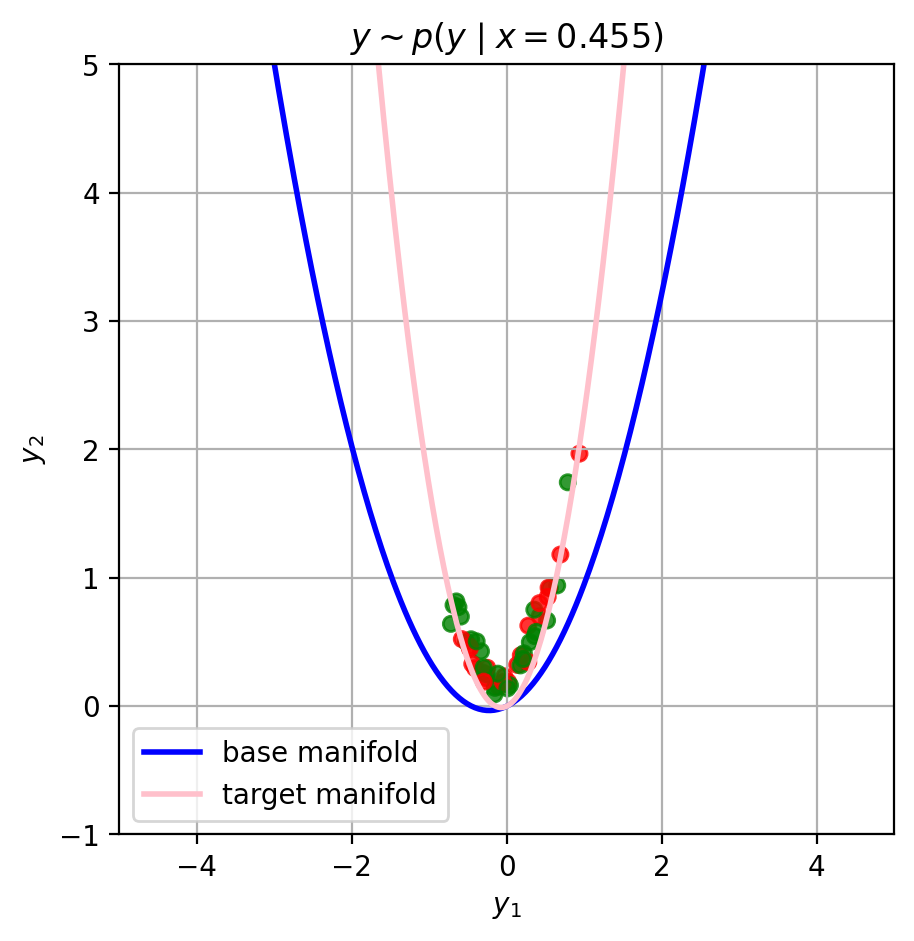

[1/1000] NLL = 0.6147
[2/1000] NLL = 0.6029
[3/1000] NLL = 0.5855
[4/1000] NLL = 0.5983
[5/1000] NLL = 0.6176
[6/1000] NLL = 0.6179
[7/1000] NLL = 0.6176
[8/1000] NLL = 0.6052
[9/1000] NLL = 0.5974
[10/1000] NLL = 0.6222
[11/1000] NLL = 0.6001
[12/1000] NLL = 0.6070
[13/1000] NLL = 0.6062
[14/1000] NLL = 0.6050
[15/1000] NLL = 0.6282
[16/1000] NLL = 0.6087
[17/1000] NLL = 0.6146
[18/1000] NLL = 0.6146
[19/1000] NLL = 0.6030
[20/1000] NLL = 0.6323
[21/1000] NLL = 0.6169
[22/1000] NLL = 0.6002
[23/1000] NLL = 0.5941
[24/1000] NLL = 0.5843
[25/1000] NLL = 0.6017
[26/1000] NLL = 0.6097
[27/1000] NLL = 0.6098
[28/1000] NLL = 0.6073
[29/1000] NLL = 0.5952
[30/1000] NLL = 0.6016
[31/1000] NLL = 0.5933
[32/1000] NLL = 0.6082
[33/1000] NLL = 0.5733
[34/1000] NLL = 0.6023
[35/1000] NLL = 0.6117
[36/1000] NLL = 0.6090
[37/1000] NLL = 0.6061
[38/1000] NLL = 0.6026
[39/1000] NLL = 0.6196
[40/1000] NLL = 0.6212
[41/1000] NLL = 0.6172
[42/1000] NLL = 0.6289
[43/1000] NLL = 0.6130
[44/1000] NLL = 0.60

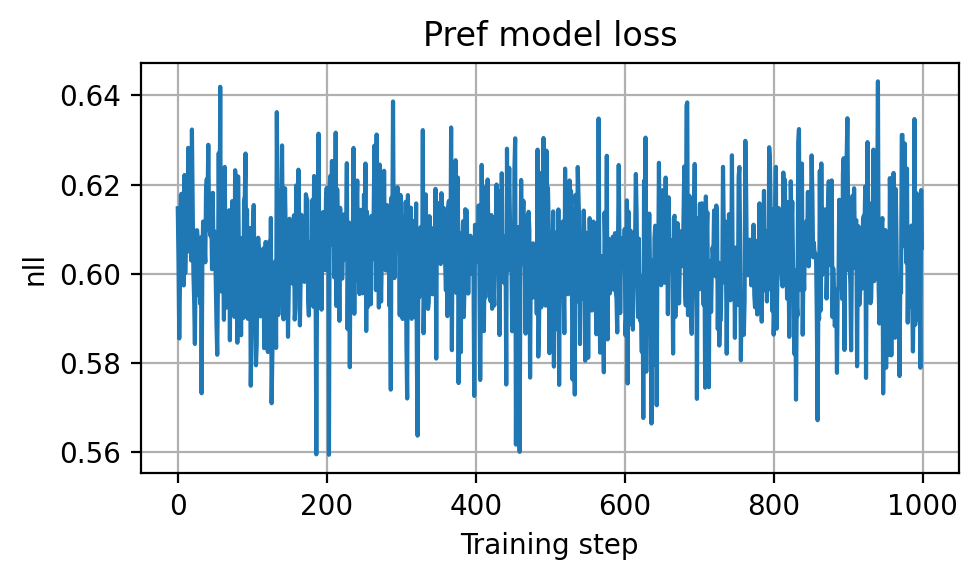

Dataset composition (likes/dislikes):   0.5009279847145081 / 0.49907201528549194
ACC(learned vs GT):   0.9894999861717224 / 0.5126619935035706
y2_learned.shape =  (400,)
y2_learned[190:210] =  [-0.00554564 -0.02490821 -0.04248561 -0.05855586 -0.0705125  -0.0804231
 -0.10088028 -0.10461089 -0.10341306 -0.0961788  -0.08353518 -0.07082812
 -0.05736518 -0.04508997 -0.03535806 -0.02968015 -0.02339134 -0.01214404
  0.00282308  0.01522574]


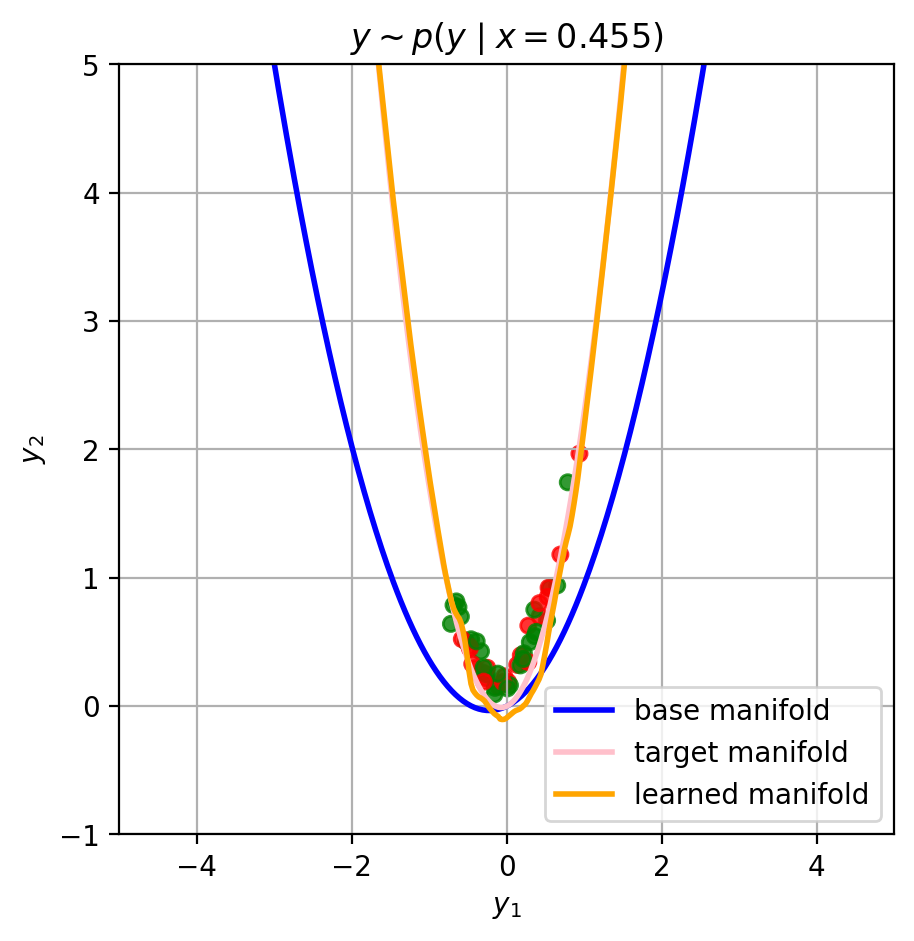

[1/1000] loss = 0.0186
[2/1000] loss = 0.0188
[3/1000] loss = 0.0192
[4/1000] loss = 0.0179
[5/1000] loss = 0.0176
[6/1000] loss = 0.0170
[7/1000] loss = 0.0172
[8/1000] loss = 0.0172
[9/1000] loss = 0.0165
[10/1000] loss = 0.0165
[11/1000] loss = 0.0159
[12/1000] loss = 0.0162
[13/1000] loss = 0.0166
[14/1000] loss = 0.0162
[15/1000] loss = 0.0163
[16/1000] loss = 0.0162
[17/1000] loss = 0.0158
[18/1000] loss = 0.0163
[19/1000] loss = 0.0158
[20/1000] loss = 0.0161
[21/1000] loss = 0.0155
[22/1000] loss = 0.0159
[23/1000] loss = 0.0155
[24/1000] loss = 0.0159
[25/1000] loss = 0.0159
[26/1000] loss = 0.0159
[27/1000] loss = 0.0160
[28/1000] loss = 0.0158
[29/1000] loss = 0.0155
[30/1000] loss = 0.0158
[31/1000] loss = 0.0163
[32/1000] loss = 0.0153
[33/1000] loss = 0.0160
[34/1000] loss = 0.0156
[35/1000] loss = 0.0157
[36/1000] loss = 0.0159
[37/1000] loss = 0.0153
[38/1000] loss = 0.0157
[39/1000] loss = 0.0154
[40/1000] loss = 0.0154
[41/1000] loss = 0.0154
[42/1000] loss = 0.0155
[

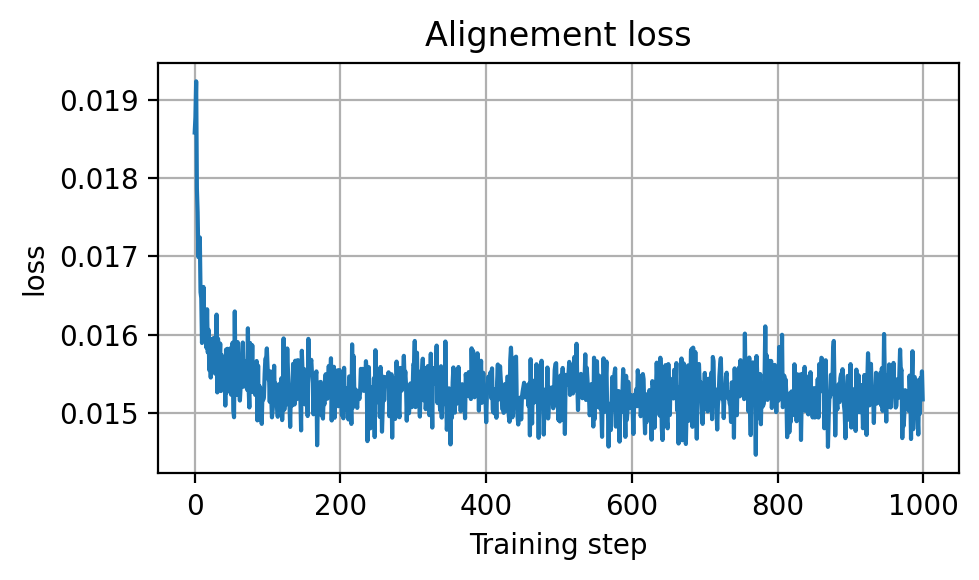

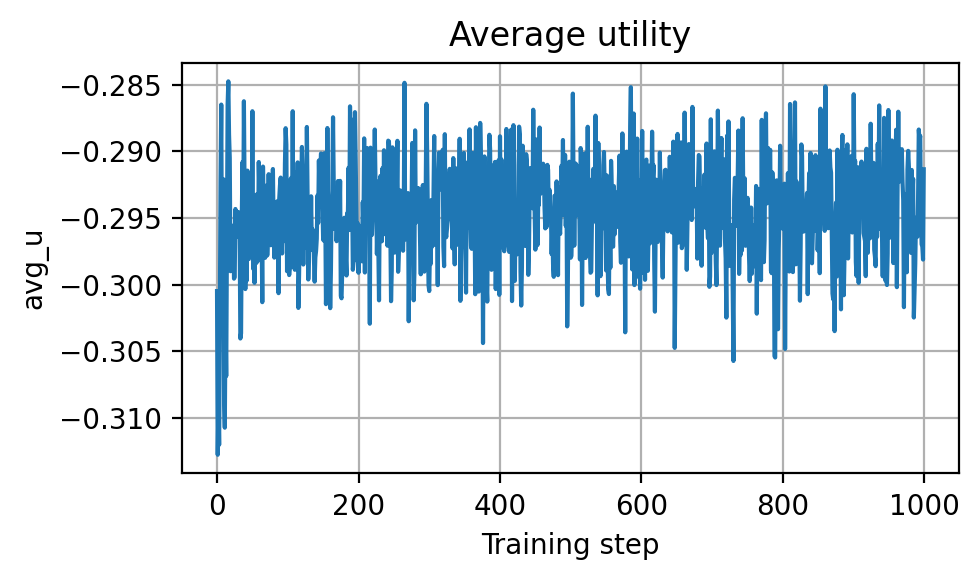

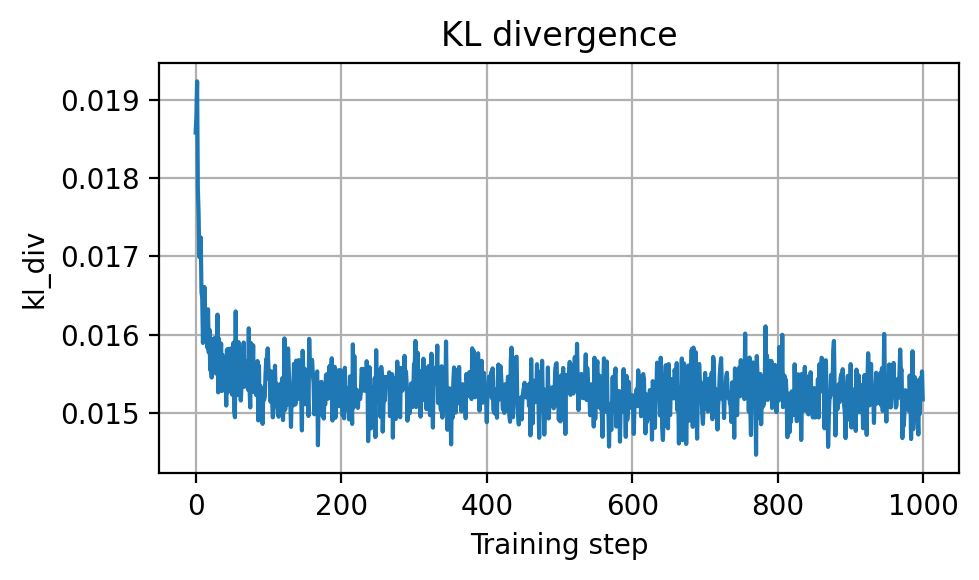

y2_learned.shape =  (400,)
y2_learned[190:210] =  [-0.00554564 -0.02490821 -0.04248561 -0.05855586 -0.0705125  -0.0804231
 -0.10088028 -0.10461089 -0.10341306 -0.0961788  -0.08353518 -0.07082812
 -0.05736518 -0.04508997 -0.03535806 -0.02968015 -0.02339134 -0.01214404
  0.00282308  0.01522574]


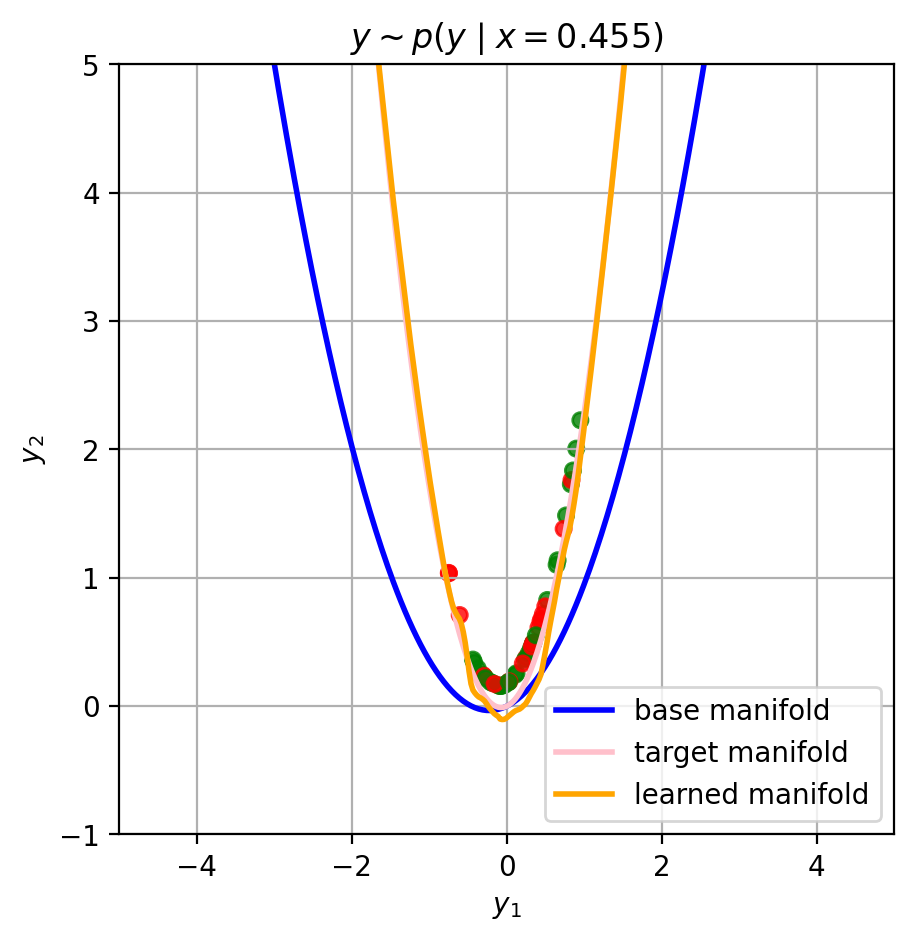

[1/2000] -ELBO = 5.024277687072754
[2/2000] -ELBO = 4.929079055786133
[3/2000] -ELBO = 4.835613250732422
[4/2000] -ELBO = 4.744204521179199
[5/2000] -ELBO = 4.654940128326416
[6/2000] -ELBO = 4.5676984786987305
[7/2000] -ELBO = 4.482446193695068
[8/2000] -ELBO = 4.399414539337158
[9/2000] -ELBO = 4.318521976470947
[10/2000] -ELBO = 4.239726543426514
[11/2000] -ELBO = 4.163149833679199
[12/2000] -ELBO = 4.088367462158203
[13/2000] -ELBO = 4.015674114227295
[14/2000] -ELBO = 3.944955825805664
[15/2000] -ELBO = 3.876296281814575
[16/2000] -ELBO = 3.810091257095337
[17/2000] -ELBO = 3.7457873821258545
[18/2000] -ELBO = 3.6838607788085938
[19/2000] -ELBO = 3.625044345855713
[20/2000] -ELBO = 3.567671775817871
[21/2000] -ELBO = 3.5131304264068604
[22/2000] -ELBO = 3.462031602859497
[23/2000] -ELBO = 3.4133265018463135
[24/2000] -ELBO = 3.367037773132324
[25/2000] -ELBO = 3.3243136405944824
[26/2000] -ELBO = 3.284456968307495
[27/2000] -ELBO = 3.246002674102783
[28/2000] -ELBO = 3.21046400070

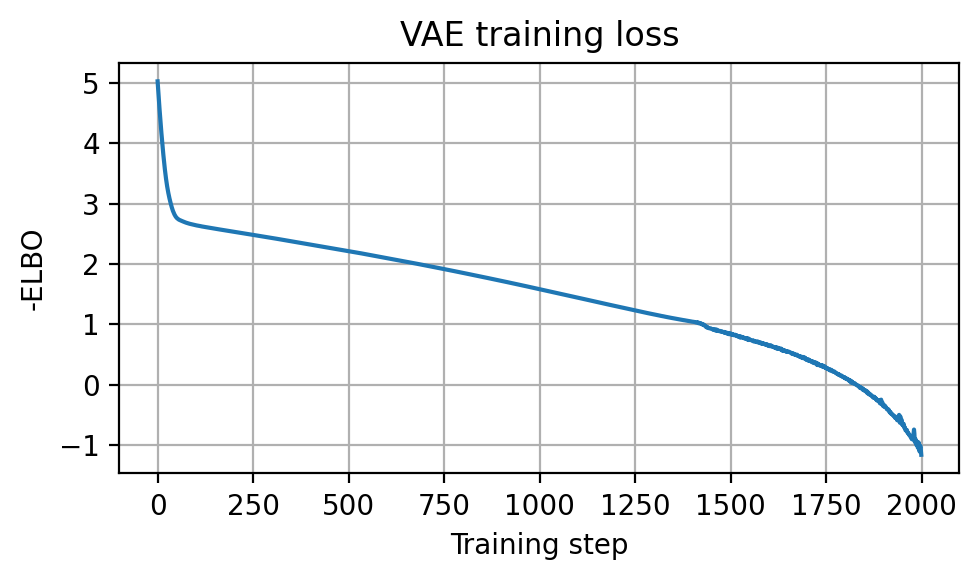

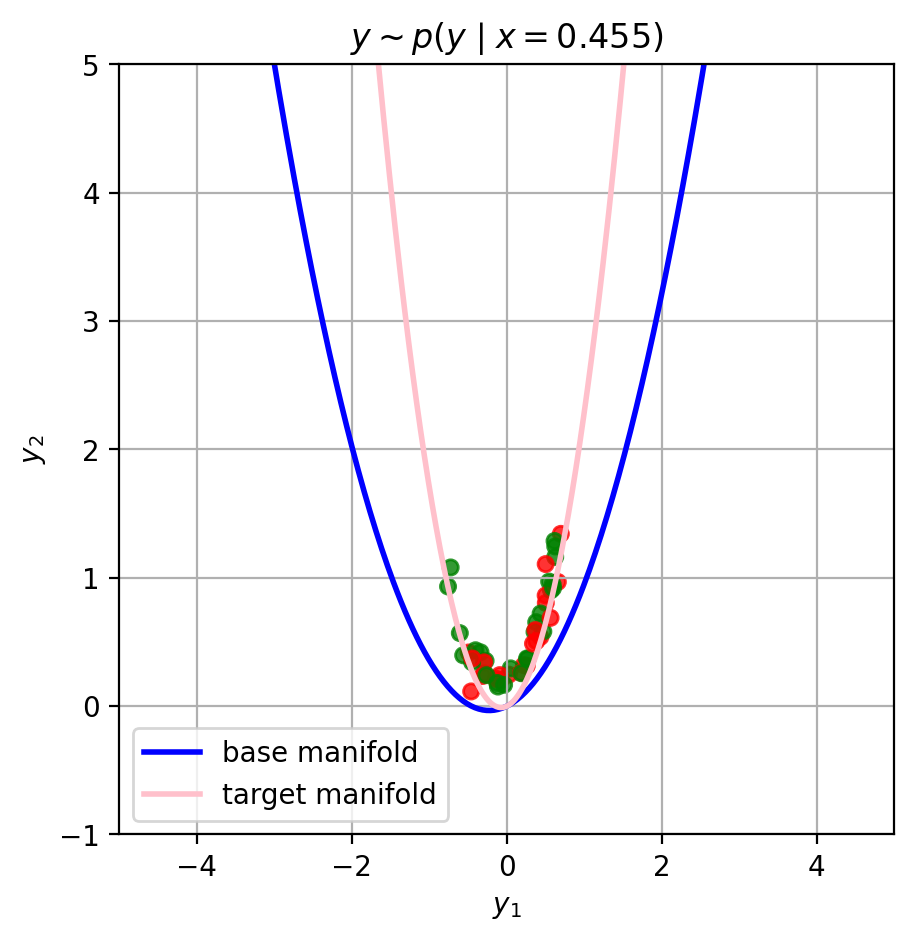

[1/1000] NLL = 0.6272
[2/1000] NLL = 0.5956
[3/1000] NLL = 0.5873
[4/1000] NLL = 0.6361
[5/1000] NLL = 0.5981
[6/1000] NLL = 0.5982
[7/1000] NLL = 0.6400
[8/1000] NLL = 0.6139
[9/1000] NLL = 0.6344
[10/1000] NLL = 0.6107
[11/1000] NLL = 0.6066
[12/1000] NLL = 0.6316
[13/1000] NLL = 0.6135
[14/1000] NLL = 0.5986
[15/1000] NLL = 0.5961
[16/1000] NLL = 0.6459
[17/1000] NLL = 0.6195
[18/1000] NLL = 0.6222
[19/1000] NLL = 0.6169
[20/1000] NLL = 0.6033
[21/1000] NLL = 0.6317
[22/1000] NLL = 0.6461
[23/1000] NLL = 0.6138
[24/1000] NLL = 0.6138
[25/1000] NLL = 0.6116
[26/1000] NLL = 0.6162
[27/1000] NLL = 0.6173
[28/1000] NLL = 0.6153
[29/1000] NLL = 0.5929
[30/1000] NLL = 0.6172
[31/1000] NLL = 0.6175
[32/1000] NLL = 0.6255
[33/1000] NLL = 0.6344
[34/1000] NLL = 0.6153
[35/1000] NLL = 0.6252
[36/1000] NLL = 0.6259
[37/1000] NLL = 0.6239
[38/1000] NLL = 0.6206
[39/1000] NLL = 0.5899
[40/1000] NLL = 0.6299
[41/1000] NLL = 0.6320
[42/1000] NLL = 0.6008
[43/1000] NLL = 0.6233
[44/1000] NLL = 0.59

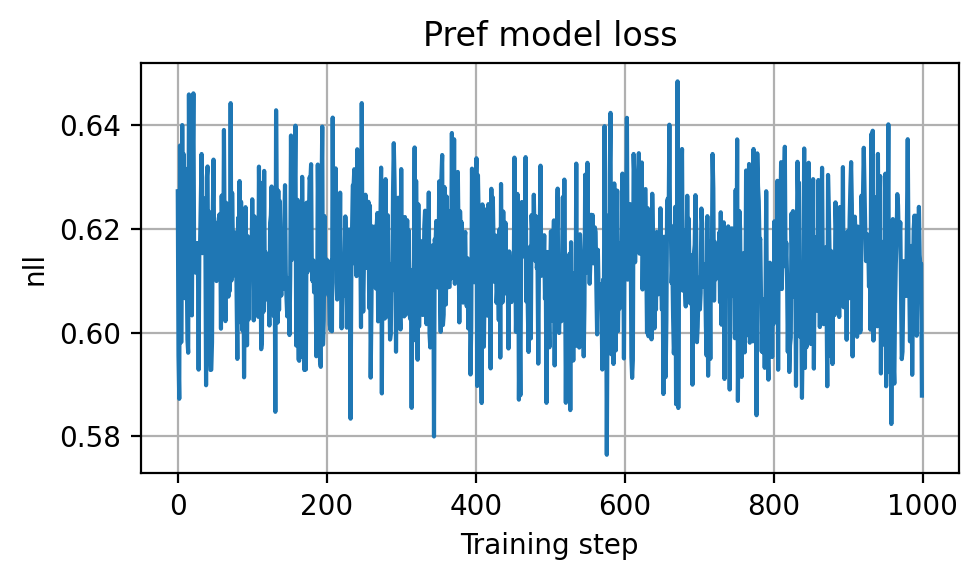

Dataset composition (likes/dislikes):   0.5003520250320435 / 0.49964797496795654
ACC(learned vs GT):   0.9903759956359863 / 0.5130879878997803
y2_learned.shape =  (400,)
y2_learned[190:210] =  [-0.02521491 -0.0382726  -0.05339487 -0.06726365 -0.07613973 -0.08962448
 -0.11970388 -0.13995653 -0.14825204 -0.1526055  -0.14961159 -0.14315061
 -0.13358924 -0.12259775 -0.10805804 -0.09587    -0.08113828 -0.05774074
 -0.03138702 -0.0098355 ]


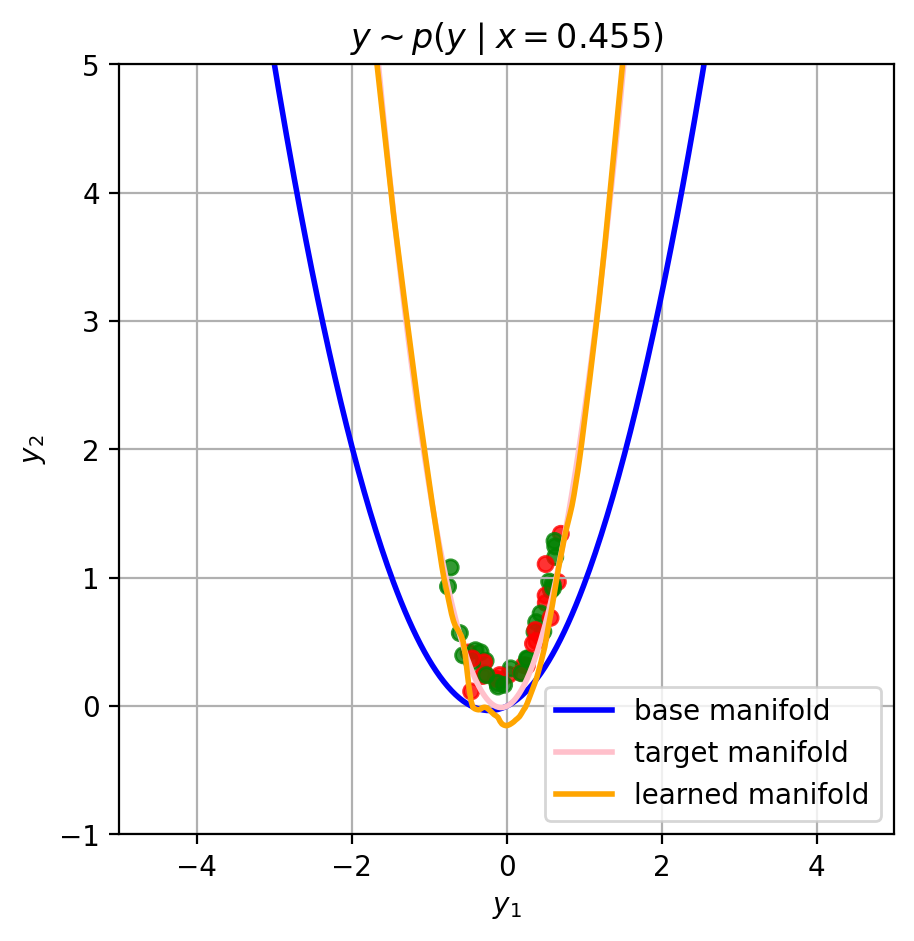

[1/1000] loss = 0.0146
[2/1000] loss = 0.0201
[3/1000] loss = 0.0141
[4/1000] loss = 0.0162
[5/1000] loss = 0.0167
[6/1000] loss = 0.0154
[7/1000] loss = 0.0133
[8/1000] loss = 0.0138
[9/1000] loss = 0.0145
[10/1000] loss = 0.0143
[11/1000] loss = 0.0134
[12/1000] loss = 0.0131
[13/1000] loss = 0.0137
[14/1000] loss = 0.0131
[15/1000] loss = 0.0135
[16/1000] loss = 0.0133
[17/1000] loss = 0.0127
[18/1000] loss = 0.0128
[19/1000] loss = 0.0130
[20/1000] loss = 0.0130
[21/1000] loss = 0.0135
[22/1000] loss = 0.0124
[23/1000] loss = 0.0124
[24/1000] loss = 0.0125
[25/1000] loss = 0.0131
[26/1000] loss = 0.0130
[27/1000] loss = 0.0127
[28/1000] loss = 0.0122
[29/1000] loss = 0.0123
[30/1000] loss = 0.0126
[31/1000] loss = 0.0127
[32/1000] loss = 0.0123
[33/1000] loss = 0.0127
[34/1000] loss = 0.0125
[35/1000] loss = 0.0122
[36/1000] loss = 0.0122
[37/1000] loss = 0.0121
[38/1000] loss = 0.0125
[39/1000] loss = 0.0120
[40/1000] loss = 0.0124
[41/1000] loss = 0.0122
[42/1000] loss = 0.0124
[

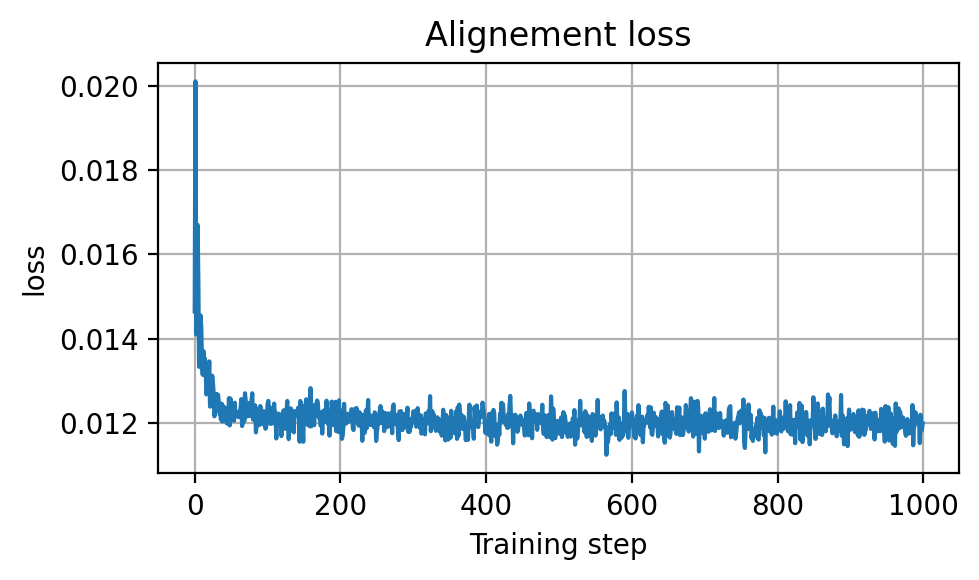

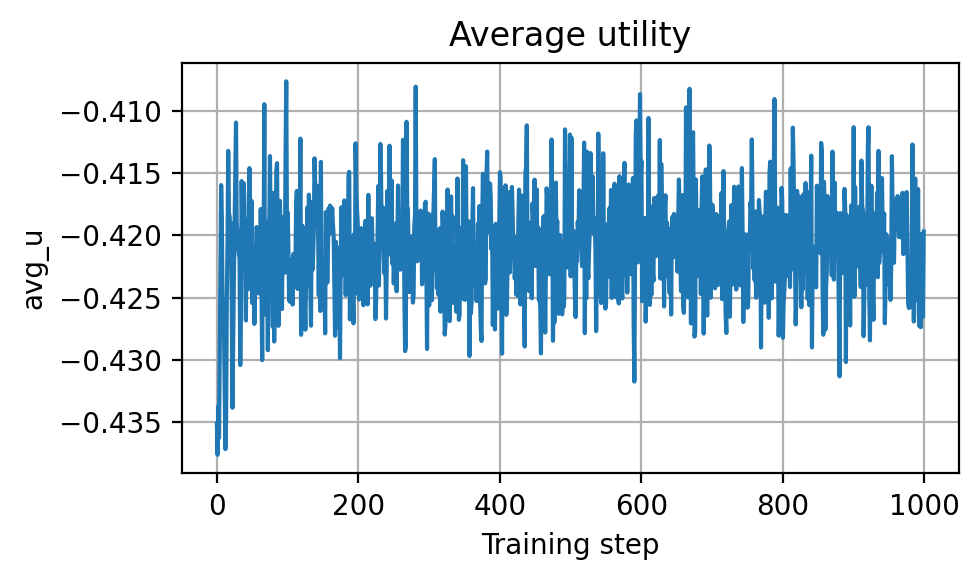

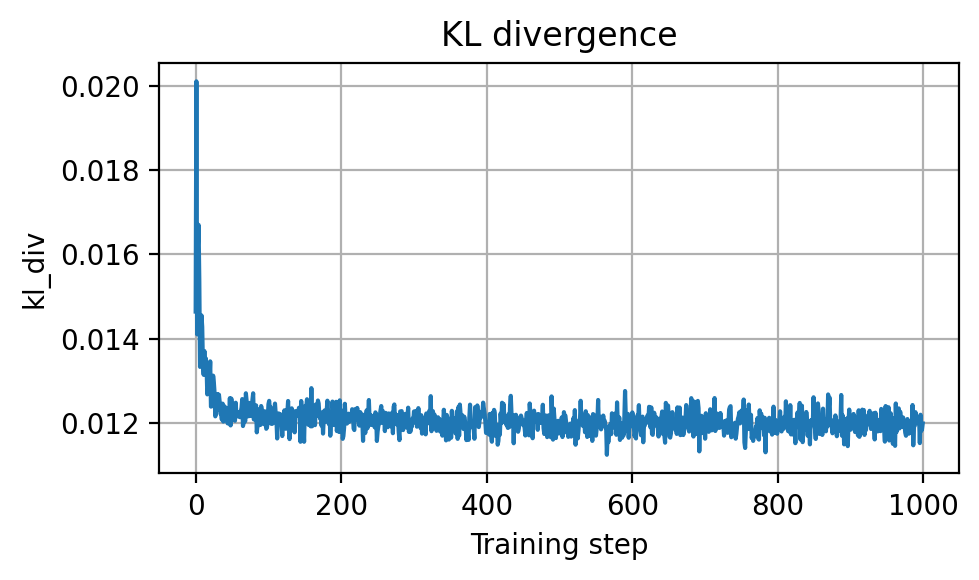

y2_learned.shape =  (400,)
y2_learned[190:210] =  [-0.02521491 -0.0382726  -0.05339487 -0.06726365 -0.07613973 -0.08962448
 -0.11970388 -0.13995653 -0.14825204 -0.1526055  -0.14961159 -0.14315061
 -0.13358924 -0.12259775 -0.10805804 -0.09587    -0.08113828 -0.05774074
 -0.03138702 -0.0098355 ]


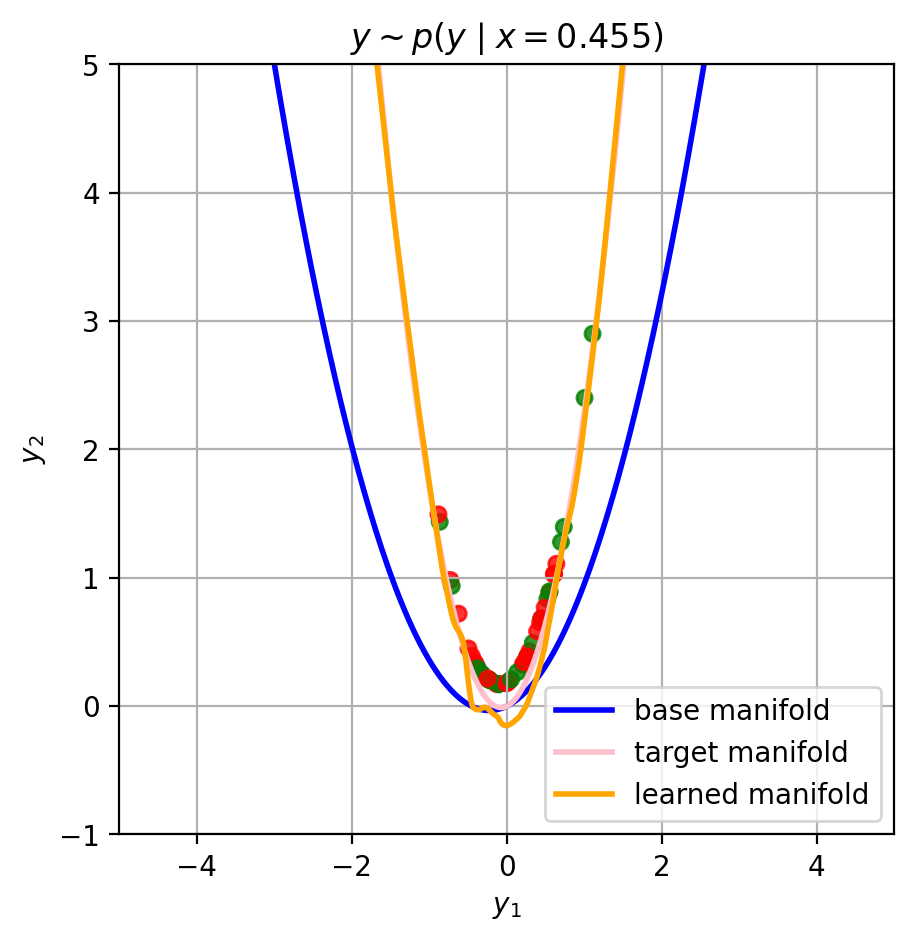

[1/2000] -ELBO = 4.982341766357422
[2/2000] -ELBO = 4.874080181121826
[3/2000] -ELBO = 4.768222808837891
[4/2000] -ELBO = 4.6652936935424805
[5/2000] -ELBO = 4.5653204917907715
[6/2000] -ELBO = 4.468164920806885
[7/2000] -ELBO = 4.373809337615967
[8/2000] -ELBO = 4.282254219055176
[9/2000] -ELBO = 4.193577766418457
[10/2000] -ELBO = 4.107396125793457
[11/2000] -ELBO = 4.023926258087158
[12/2000] -ELBO = 3.9429898262023926
[13/2000] -ELBO = 3.864856481552124
[14/2000] -ELBO = 3.7894365787506104
[15/2000] -ELBO = 3.716535806655884
[16/2000] -ELBO = 3.647327184677124
[17/2000] -ELBO = 3.581371784210205
[18/2000] -ELBO = 3.5182604789733887
[19/2000] -ELBO = 3.458766222000122
[20/2000] -ELBO = 3.40352463722229
[21/2000] -ELBO = 3.350586175918579
[22/2000] -ELBO = 3.301393985748291
[23/2000] -ELBO = 3.2552366256713867
[24/2000] -ELBO = 3.213693141937256
[25/2000] -ELBO = 3.175603151321411
[26/2000] -ELBO = 3.138636589050293
[27/2000] -ELBO = 3.104478120803833
[28/2000] -ELBO = 3.072825670242

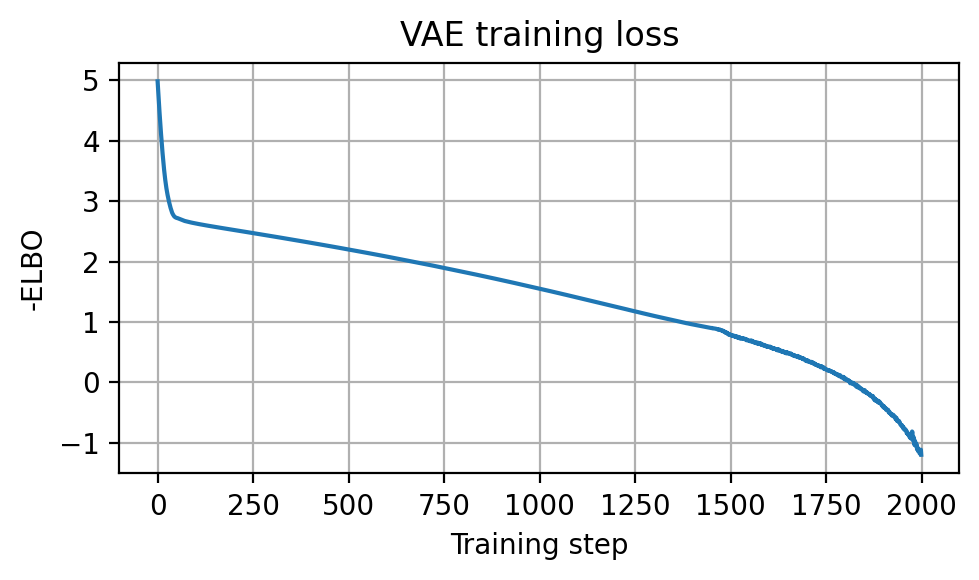

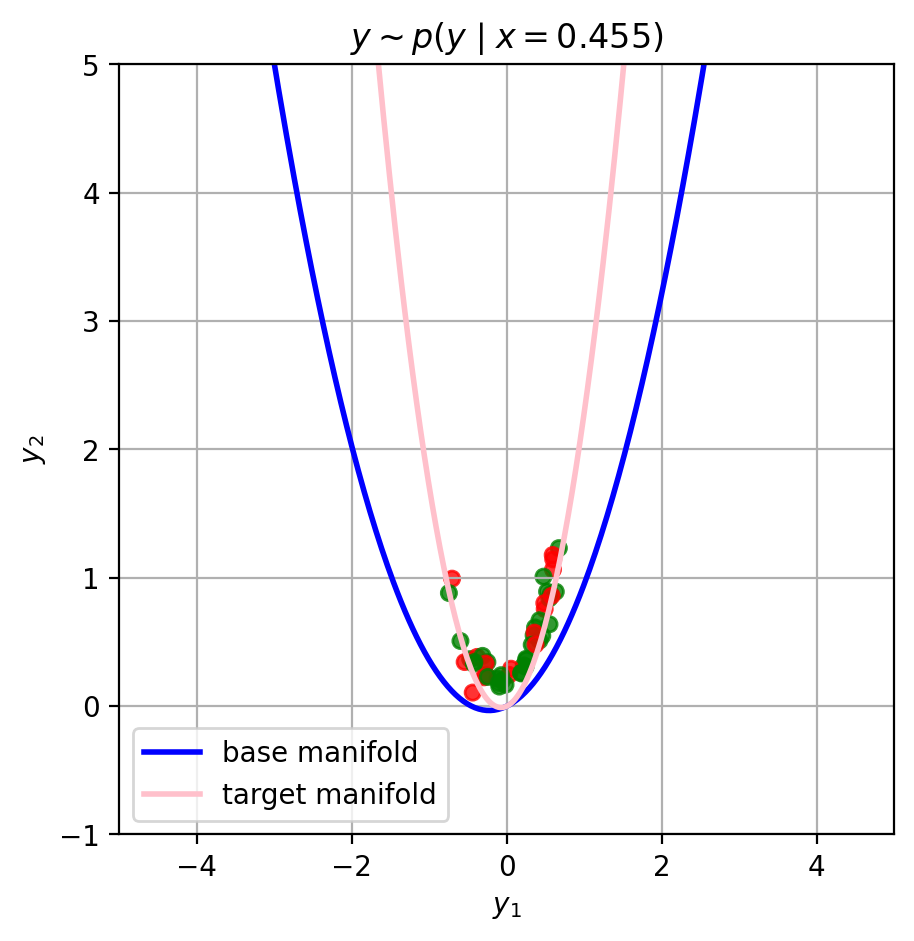

[1/1000] NLL = 0.6075
[2/1000] NLL = 0.6416
[3/1000] NLL = 0.6111
[4/1000] NLL = 0.6168
[5/1000] NLL = 0.6216
[6/1000] NLL = 0.6244
[7/1000] NLL = 0.6276
[8/1000] NLL = 0.5905
[9/1000] NLL = 0.6242
[10/1000] NLL = 0.6100
[11/1000] NLL = 0.6169
[12/1000] NLL = 0.6280
[13/1000] NLL = 0.6220
[14/1000] NLL = 0.6225
[15/1000] NLL = 0.6118
[16/1000] NLL = 0.6085
[17/1000] NLL = 0.6322
[18/1000] NLL = 0.6180
[19/1000] NLL = 0.6255
[20/1000] NLL = 0.6046
[21/1000] NLL = 0.6085
[22/1000] NLL = 0.6184
[23/1000] NLL = 0.6328
[24/1000] NLL = 0.6179
[25/1000] NLL = 0.6198
[26/1000] NLL = 0.6324
[27/1000] NLL = 0.6406
[28/1000] NLL = 0.6332
[29/1000] NLL = 0.6165
[30/1000] NLL = 0.6216
[31/1000] NLL = 0.6326
[32/1000] NLL = 0.6230
[33/1000] NLL = 0.6188
[34/1000] NLL = 0.6224
[35/1000] NLL = 0.6138
[36/1000] NLL = 0.6068
[37/1000] NLL = 0.6010
[38/1000] NLL = 0.6349
[39/1000] NLL = 0.6198
[40/1000] NLL = 0.6283
[41/1000] NLL = 0.6300
[42/1000] NLL = 0.6333
[43/1000] NLL = 0.6207
[44/1000] NLL = 0.63

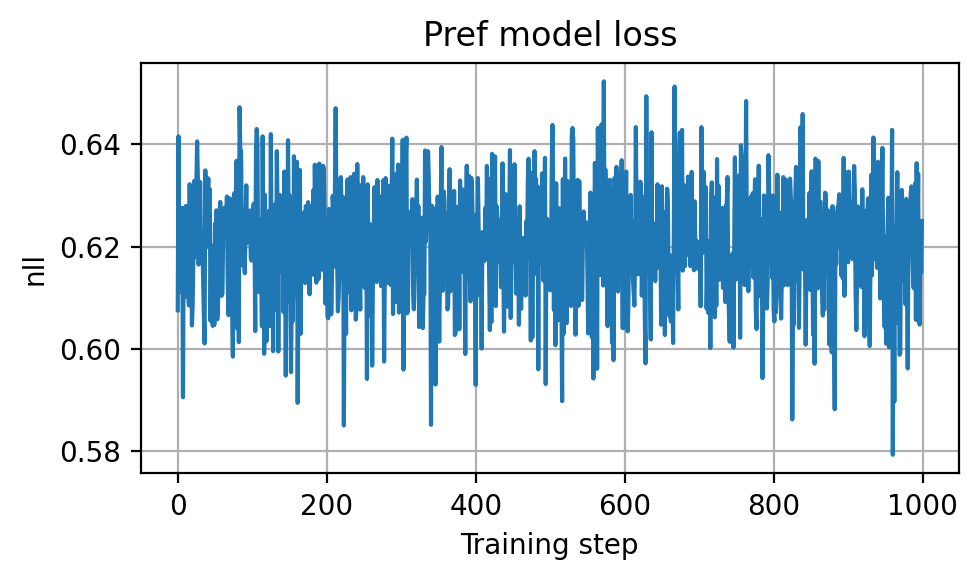

Dataset composition (likes/dislikes):   0.5005059838294983 / 0.4994940161705017
ACC(learned vs GT):   0.9927579760551453 / 0.5118979811668396
y2_learned.shape =  (400,)
y2_learned[190:210] =  [ 0.12860821  0.11586997  0.11040582  0.10361271  0.08804311  0.07082479
  0.03061405  0.00092715 -0.02383541 -0.03860584 -0.04392295 -0.04777172
 -0.05105615 -0.05116858 -0.0461216  -0.04140523 -0.03295316 -0.02078101
 -0.00142242  0.03376833]


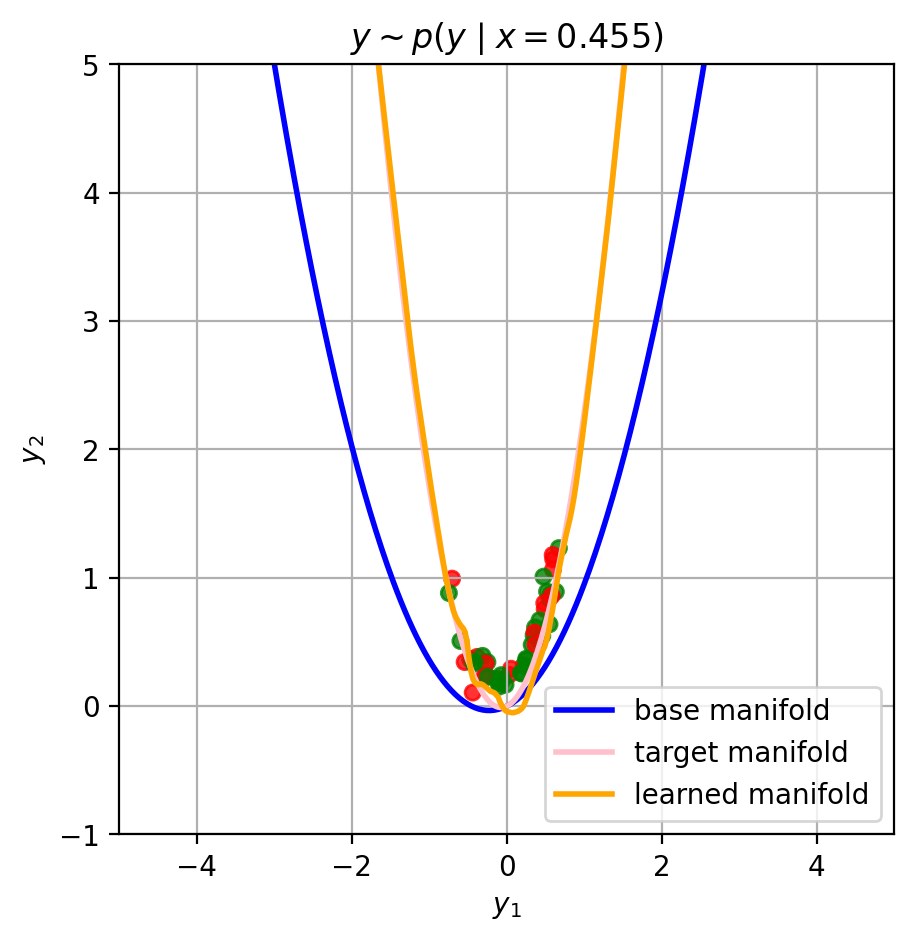

[1/1000] loss = 0.0113
[2/1000] loss = 0.0167
[3/1000] loss = 0.0115
[4/1000] loss = 0.0121
[5/1000] loss = 0.0134
[6/1000] loss = 0.0127
[7/1000] loss = 0.0110
[8/1000] loss = 0.0109
[9/1000] loss = 0.0121
[10/1000] loss = 0.0116
[11/1000] loss = 0.0109
[12/1000] loss = 0.0109
[13/1000] loss = 0.0107
[14/1000] loss = 0.0107
[15/1000] loss = 0.0108
[16/1000] loss = 0.0109
[17/1000] loss = 0.0111
[18/1000] loss = 0.0107
[19/1000] loss = 0.0104
[20/1000] loss = 0.0104
[21/1000] loss = 0.0107
[22/1000] loss = 0.0111
[23/1000] loss = 0.0102
[24/1000] loss = 0.0104
[25/1000] loss = 0.0107
[26/1000] loss = 0.0105
[27/1000] loss = 0.0104
[28/1000] loss = 0.0102
[29/1000] loss = 0.0099
[30/1000] loss = 0.0104
[31/1000] loss = 0.0102
[32/1000] loss = 0.0103
[33/1000] loss = 0.0104
[34/1000] loss = 0.0102
[35/1000] loss = 0.0103
[36/1000] loss = 0.0104
[37/1000] loss = 0.0103
[38/1000] loss = 0.0103
[39/1000] loss = 0.0103
[40/1000] loss = 0.0099
[41/1000] loss = 0.0105
[42/1000] loss = 0.0100
[

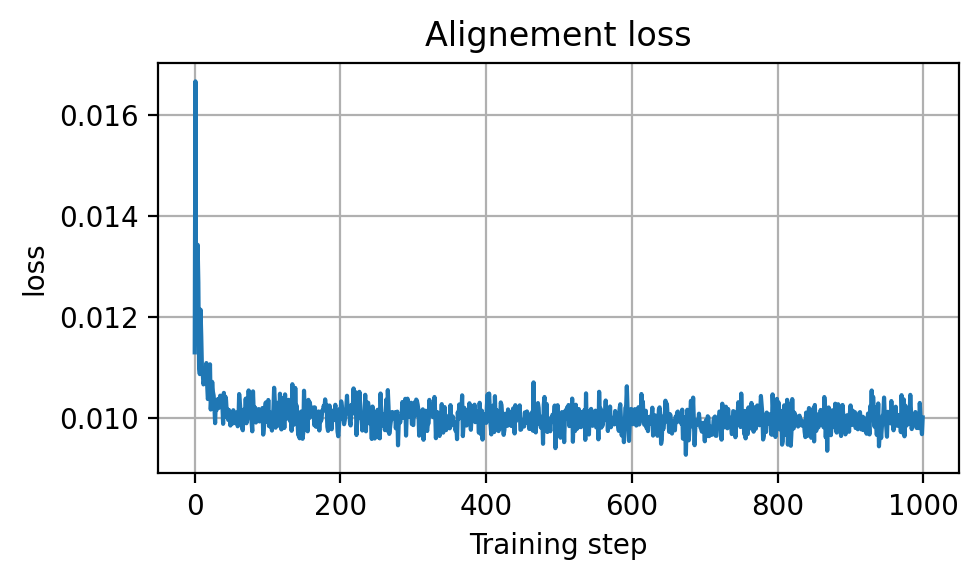

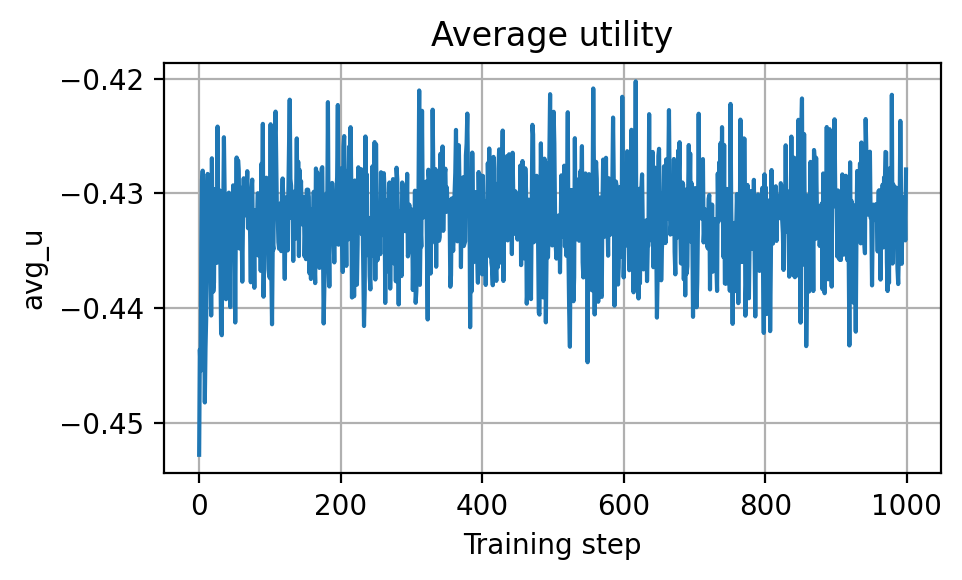

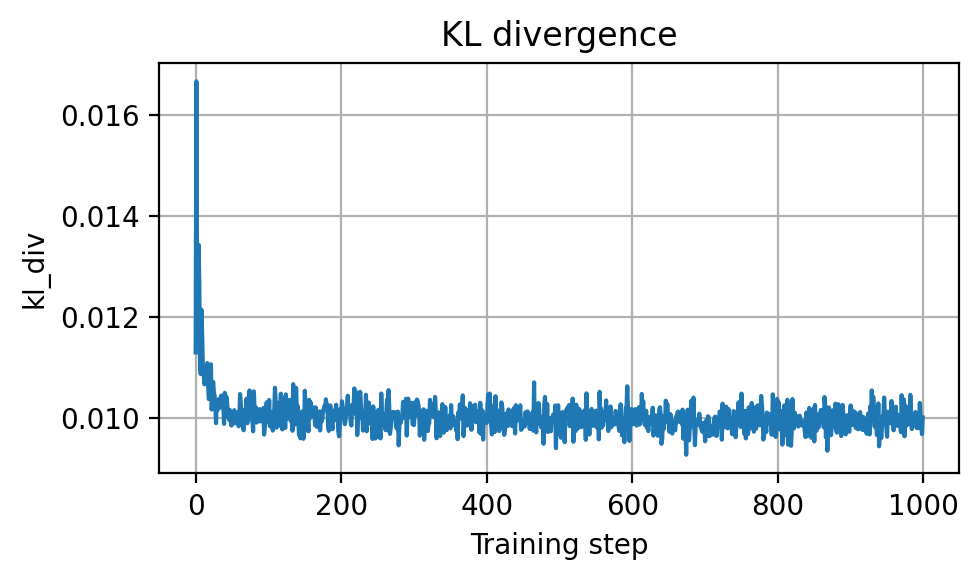

y2_learned.shape =  (400,)
y2_learned[190:210] =  [ 0.12860821  0.11586997  0.11040582  0.10361271  0.08804311  0.07082479
  0.03061405  0.00092715 -0.02383541 -0.03860584 -0.04392295 -0.04777172
 -0.05105615 -0.05116858 -0.0461216  -0.04140523 -0.03295316 -0.02078101
 -0.00142242  0.03376833]


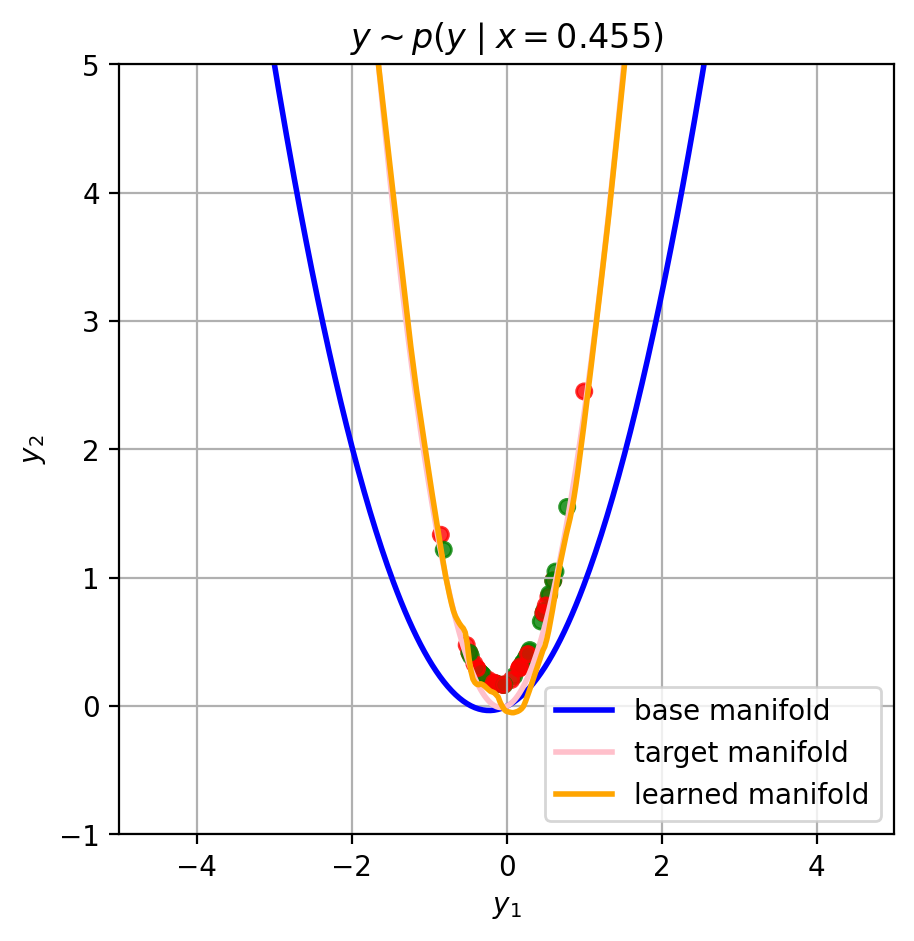

[1/2000] -ELBO = 4.9678497314453125
[2/2000] -ELBO = 4.862703800201416
[3/2000] -ELBO = 4.759573459625244
[4/2000] -ELBO = 4.6592631340026855
[5/2000] -ELBO = 4.5611395835876465
[6/2000] -ELBO = 4.465020179748535
[7/2000] -ELBO = 4.370910167694092
[8/2000] -ELBO = 4.279008865356445
[9/2000] -ELBO = 4.189070701599121
[10/2000] -ELBO = 4.101433277130127
[11/2000] -ELBO = 4.015865325927734
[12/2000] -ELBO = 3.932535409927368
[13/2000] -ELBO = 3.8513741493225098
[14/2000] -ELBO = 3.7727200984954834
[15/2000] -ELBO = 3.6966311931610107
[16/2000] -ELBO = 3.6230599880218506
[17/2000] -ELBO = 3.5525670051574707
[18/2000] -ELBO = 3.4849116802215576
[19/2000] -ELBO = 3.4204046726226807
[20/2000] -ELBO = 3.3579437732696533
[21/2000] -ELBO = 3.2996158599853516
[22/2000] -ELBO = 3.2445144653320312
[23/2000] -ELBO = 3.1927244663238525
[24/2000] -ELBO = 3.1435294151306152
[25/2000] -ELBO = 3.097599983215332
[26/2000] -ELBO = 3.0573763847351074
[27/2000] -ELBO = 3.019113302230835
[28/2000] -ELBO = 2.9

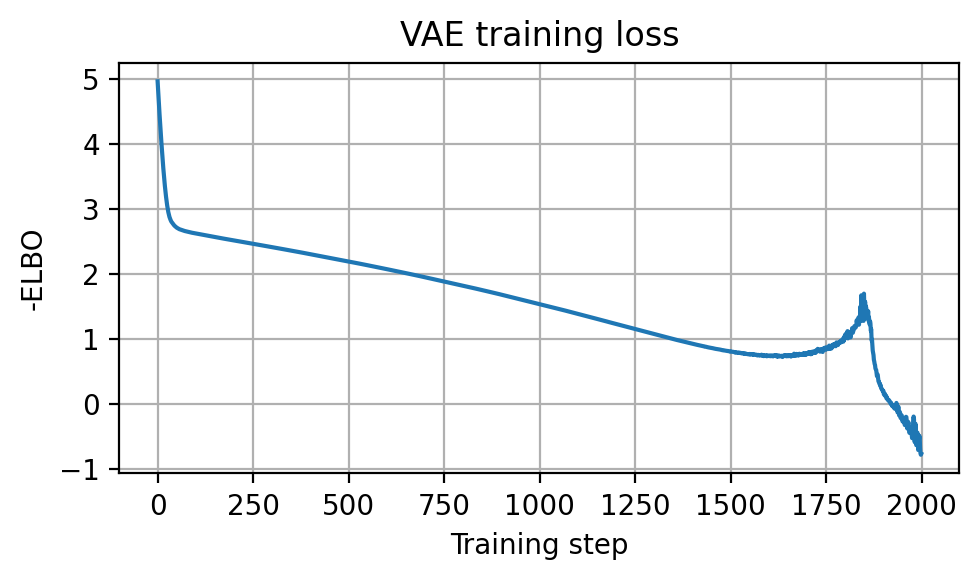

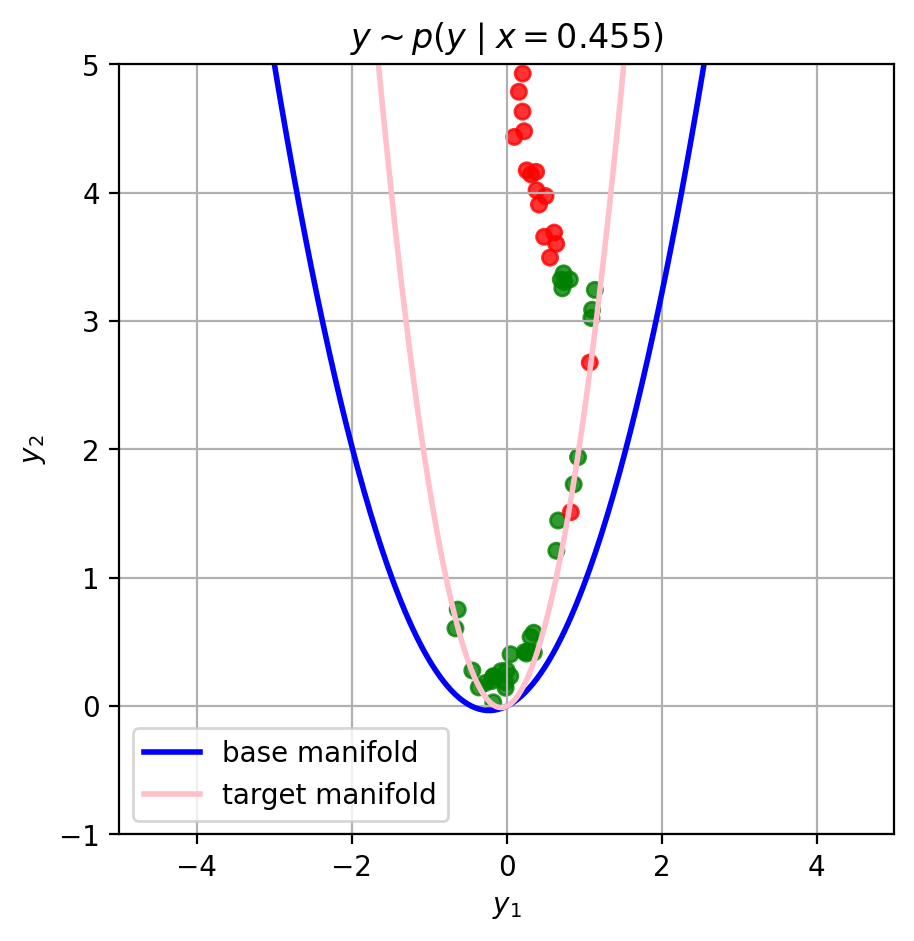

[1/1000] NLL = 0.6004
[2/1000] NLL = 0.5990
[3/1000] NLL = 0.6268
[4/1000] NLL = 0.6116
[5/1000] NLL = 0.6063
[6/1000] NLL = 0.6057
[7/1000] NLL = 0.5891
[8/1000] NLL = 0.6081
[9/1000] NLL = 0.5921
[10/1000] NLL = 0.6012
[11/1000] NLL = 0.5922
[12/1000] NLL = 0.6260
[13/1000] NLL = 0.6191
[14/1000] NLL = 0.5955
[15/1000] NLL = 0.6111
[16/1000] NLL = 0.5954
[17/1000] NLL = 0.6086
[18/1000] NLL = 0.5912
[19/1000] NLL = 0.6072
[20/1000] NLL = 0.6099
[21/1000] NLL = 0.6130
[22/1000] NLL = 0.6123
[23/1000] NLL = 0.6221
[24/1000] NLL = 0.5864
[25/1000] NLL = 0.6097
[26/1000] NLL = 0.5975
[27/1000] NLL = 0.6238
[28/1000] NLL = 0.5855
[29/1000] NLL = 0.5835
[30/1000] NLL = 0.6101
[31/1000] NLL = 0.5973
[32/1000] NLL = 0.5904
[33/1000] NLL = 0.6128
[34/1000] NLL = 0.5780
[35/1000] NLL = 0.6139
[36/1000] NLL = 0.6227
[37/1000] NLL = 0.6049
[38/1000] NLL = 0.6008
[39/1000] NLL = 0.6094
[40/1000] NLL = 0.6185
[41/1000] NLL = 0.6101
[42/1000] NLL = 0.6125
[43/1000] NLL = 0.6038
[44/1000] NLL = 0.60

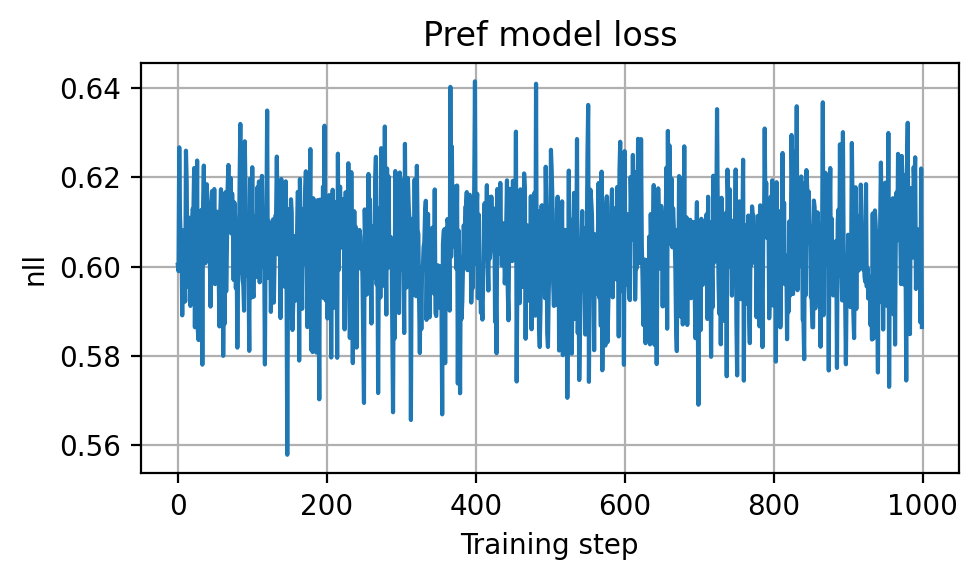

Dataset composition (likes/dislikes):   0.6085460186004639 / 0.39145398139953613
ACC(learned vs GT):   0.9926900267601013 / 0.7075560092926025
y2_learned.shape =  (400,)
y2_learned[190:210] =  [ 0.06553923  0.05195156  0.03880619  0.02053534  0.00348867 -0.01200507
 -0.05040789 -0.07509888 -0.09323496 -0.10737427 -0.10964892 -0.11143845
 -0.11039465 -0.10655966 -0.09986024 -0.09153772 -0.08198234 -0.05848553
 -0.01072281  0.03757773]


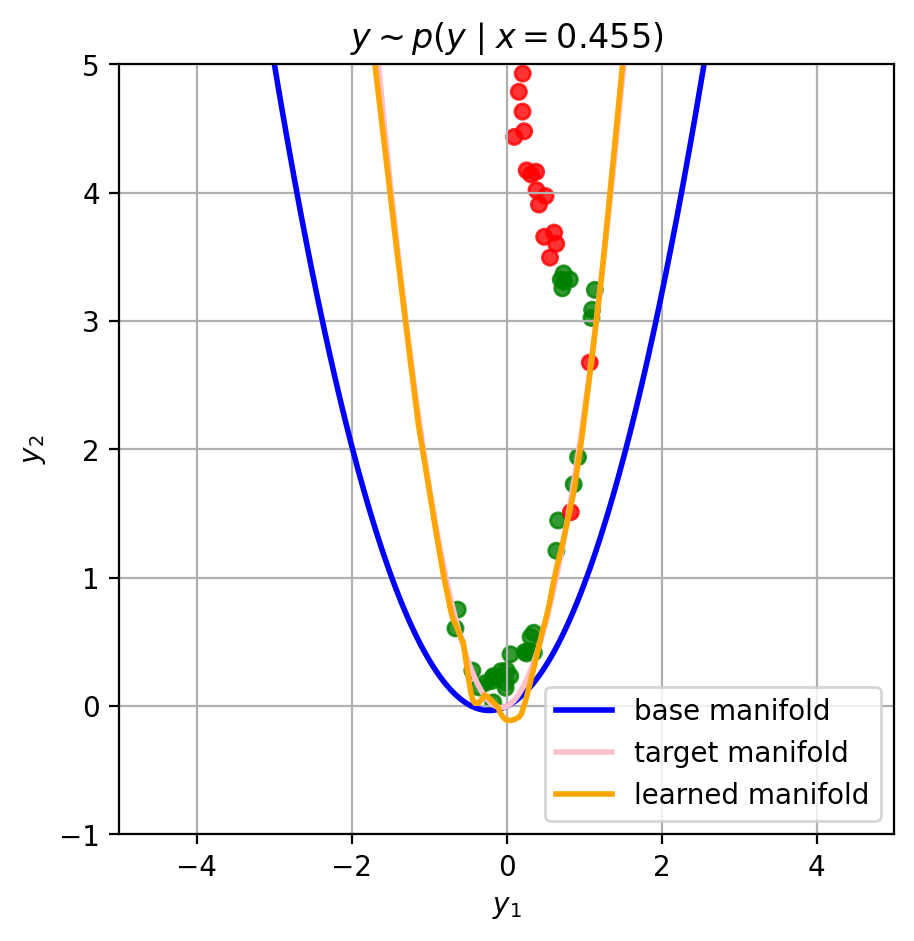

[1/1000] loss = 1.8231
[2/1000] loss = 1.6446
[3/1000] loss = 1.3977
[4/1000] loss = 1.2505
[5/1000] loss = 1.0945
[6/1000] loss = 0.9950
[7/1000] loss = 0.9016
[8/1000] loss = 0.8598
[9/1000] loss = 0.8216
[10/1000] loss = 0.8467
[11/1000] loss = 0.7920
[12/1000] loss = 0.7014
[13/1000] loss = 0.6749
[14/1000] loss = 0.6068
[15/1000] loss = 0.5598
[16/1000] loss = 0.5492
[17/1000] loss = 0.5036
[18/1000] loss = 0.5034
[19/1000] loss = 0.5096
[20/1000] loss = 0.4692
[21/1000] loss = 0.4398
[22/1000] loss = 0.4479
[23/1000] loss = 0.4157
[24/1000] loss = 0.3892
[25/1000] loss = 0.3840
[26/1000] loss = 0.3850
[27/1000] loss = 0.3815
[28/1000] loss = 0.3767
[29/1000] loss = 0.3808
[30/1000] loss = 0.3590
[31/1000] loss = 0.3560
[32/1000] loss = 0.3490
[33/1000] loss = 0.3390
[34/1000] loss = 0.3294
[35/1000] loss = 0.3498
[36/1000] loss = 0.3300
[37/1000] loss = 0.3269
[38/1000] loss = 0.3287
[39/1000] loss = 0.3168
[40/1000] loss = 0.3270
[41/1000] loss = 0.3273
[42/1000] loss = 0.3155
[

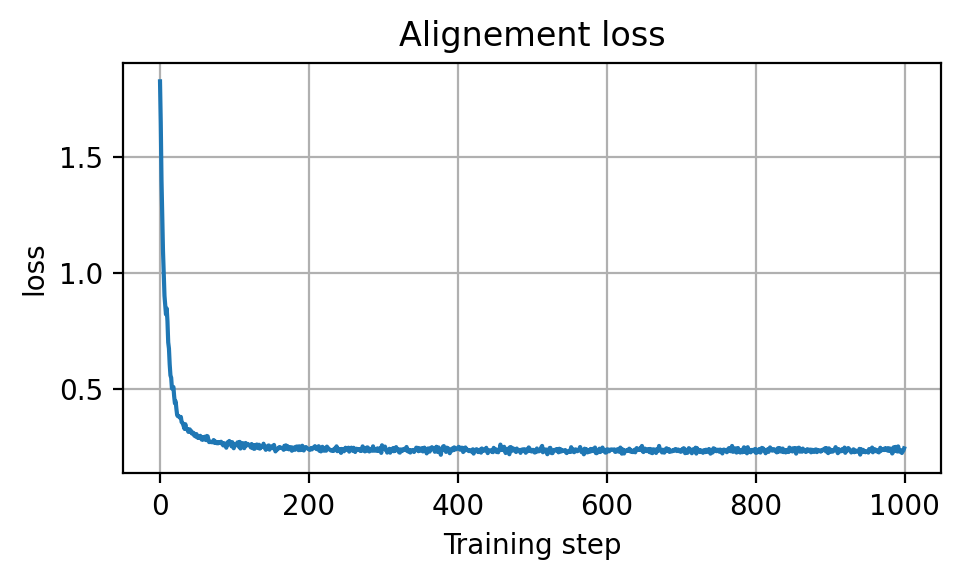

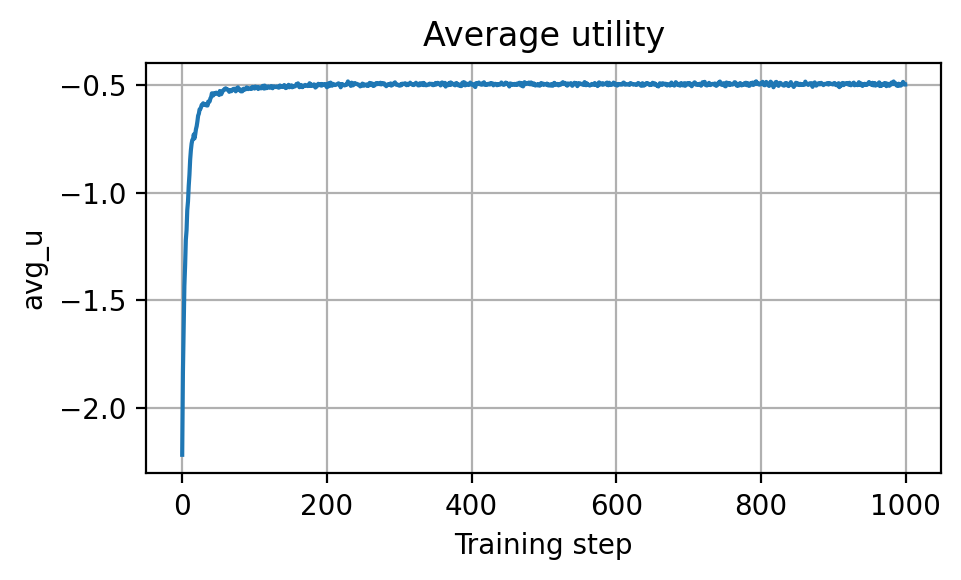

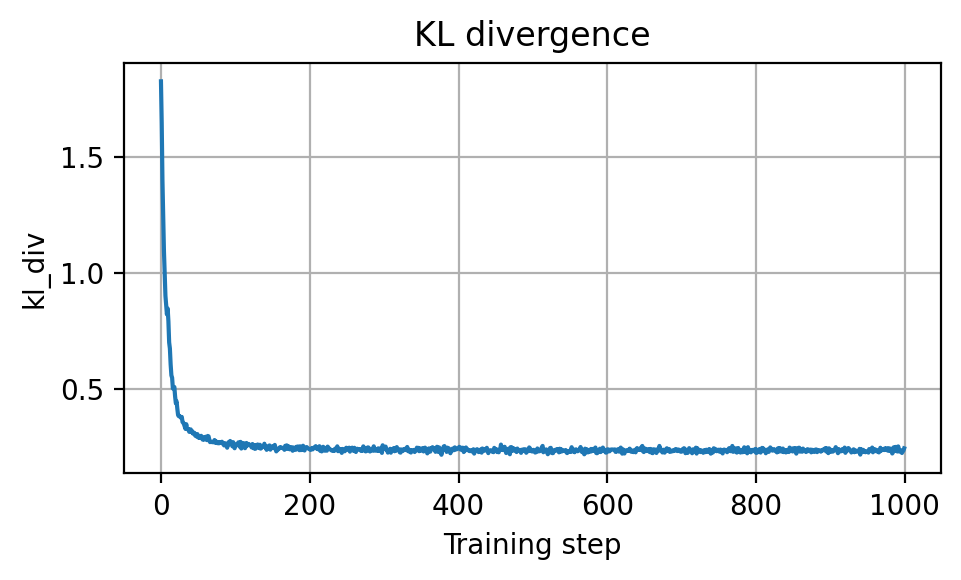

y2_learned.shape =  (400,)
y2_learned[190:210] =  [ 0.06553923  0.05195156  0.03880619  0.02053534  0.00348867 -0.01200507
 -0.05040789 -0.07509888 -0.09323496 -0.10737427 -0.10964892 -0.11143845
 -0.11039465 -0.10655966 -0.09986024 -0.09153772 -0.08198234 -0.05848553
 -0.01072281  0.03757773]


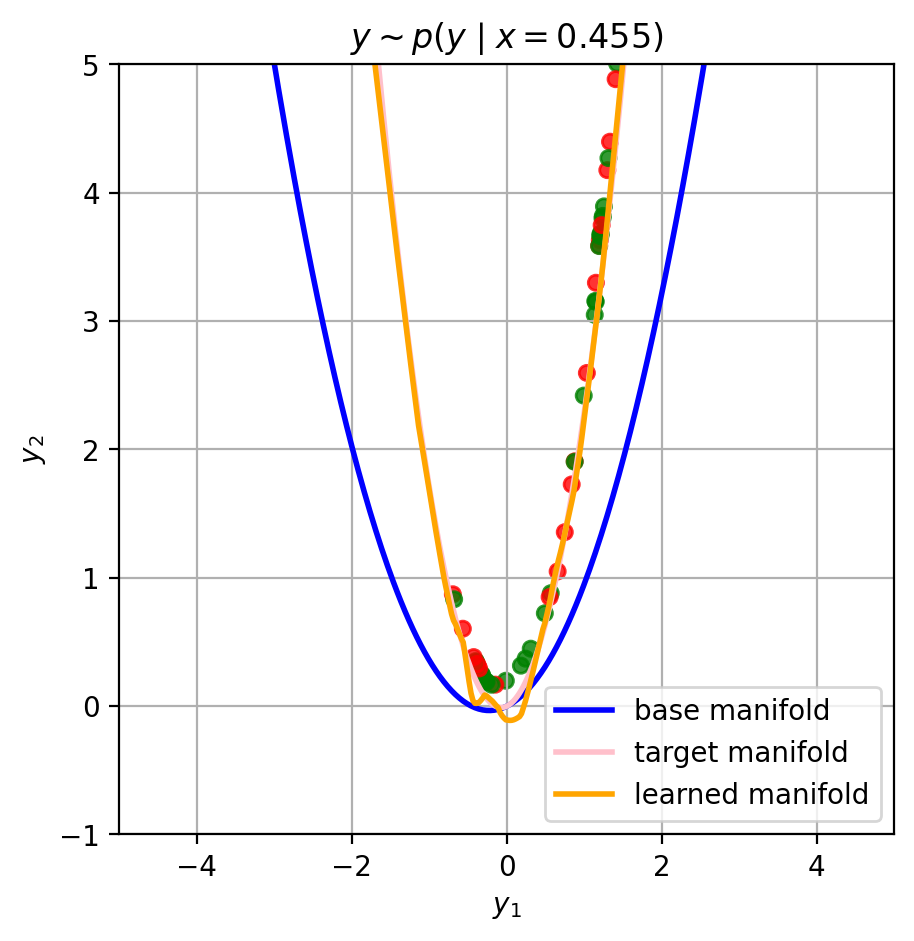

In [ ]:
for iter in range(num_iter):
    # Step 1: Pre-training
    opt = optax.adam(pre_train_lr)
    opt_state = opt.init(vae_params)

    loss_history = []

    for step in range(pre_train_epochs):
        key, subkey = jax.random.split(key)
        vae_params, opt_state, loss = pre_train_step(
            vae_params, step, opt_state, subkey, xs[:,0], ys[:,0]
        )
        loss_val = float(loss)          # convert from JAX scalar
        loss_history.append(loss_val)

        print(f"[{step+1}/{pre_train_epochs}] -ELBO = {loss_val}")

    # Plot loss
    plt.figure(figsize=(5, 3), dpi=200)
    plt.plot(loss_history)
    plt.xlabel("Training step")
    plt.ylabel("-ELBO")
    plt.title("VAE training loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    ys = sample_many(vae_params, ys_key, xs[:,0], m)
    ys_query = ys[:n_queries]
    y_history.append(ys_query)   # ys for queries

    logits = logpdf_labels(
        xs,
        ys,
        alpha=target_p.alpha,
        beta=target_p.beta,
        gamma=target_p.gamma,
        tau=tau,
    )
    gt_labels = jax.random.categorical(
        l_key,
        logits,
        axis=-1,
    )
    ls = gt_labels[:n_queries]
    l_history.append(ls)   # labels used for queries

    if ys_tot is None:
        ys_tot = ys_query
        l_tot = ls
        xs_tot = xs[:n_queries]
    else:
        ys_tot = jnp.concatenate([ys_tot, ys_query], axis=0)
        l_tot = jnp.concatenate([l_tot, ls], axis=0)
        xs_tot = jnp.concatenate([xs_tot, xs[:n_queries]], axis=0)

    u = utility_vmapped(
        xs,
        ys,
        target_p.alpha,
        target_p.beta,
        target_p.gamma,
    )

    mean_u = jnp.mean(u)
    gt_u_history.append(mean_u)

    task_vis.visualize(
        xs[0, 0, 0],
        ys[0],
        base_manifold=base_p,
        target_manifold=target_p,
        labels=gt_labels[0],
    )


    # Step 2: Learn preference model
    opt = optax.adam(pref_lr)
    opt_state = opt.init(pref_params)

    loss_history = []

    n_tot = xs_tot.shape[0]
    for step in range(pref_train_epochs):
        key, subkey = jax.random.split(key)
        idx = jax.random.randint(
            subkey,
            (pref_batch_dim,),
            minval=0,
            maxval=n_tot
        )
        xs_batch = xs_tot[idx]
        ys_batch = ys_tot[idx]
        l_batch = l_tot[idx]
        pref_params, opt_state, loss = pref_train_step(
            pref_params,
            opt_state,
            xs_batch,        # (pref_batch_dim, m, 1)
            ys_batch,        # (pref_batch_dim, m, 2)
            l_batch,   # (pref_batch_dim, m)
        )

        loss_val = float(loss)
        loss_history.append(loss_val)

        print(f"[{step+1}/{pref_train_epochs}] NLL = {loss_val:.4f}")

    # Plot loss
    plt.figure(figsize=(5, 3), dpi=200)
    plt.plot(loss_history)
    plt.xlabel("Training step")
    plt.ylabel("nll")
    plt.title("Pref model loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    pred_logits = pref_model.logpdf(
        pref_params,
        xs,
        ys,
        tau=tau
    )

    pred_labels = jax.random.categorical(
        l_key,
        pred_logits,
        axis=-1,
    )

    gt_logits = logpdf_labels(
        xs,
        ys,
        alpha=target_p.alpha,
        beta=target_p.beta,
        gamma=target_p.gamma,
        tau=tau,
    )

    gt_new_labels = jax.random.categorical(
        gt_l_key,
        gt_logits,
        axis=-1,
    )

    acc_gt = jnp.mean(gt_new_labels == gt_labels)
    acc_learned = jnp.mean(pred_labels == gt_labels)

    perc_likes = jnp.mean(gt_labels == 1)

    print(f"Dataset composition (likes/dislikes):   {perc_likes} / {1 - perc_likes}")

    print(f"ACC(learned vs GT):   {acc_learned} / {acc_gt}")

    #y2_fn = lambda x, y: y2_learned(pref_params["y2_fn"], x, y) / (jax.nn.softplus(pref_params["log_tau"]) + 1e-6)
    y2_fn = lambda x, y: y2_learned(pref_params["y2_fn"], x, y)

    task_vis.visualize(
        xs[0, 0, 0],
        ys[0],
        base_manifold=base_p,
        target_manifold=target_p,
        learned_manifold=y2_fn,
        labels=gt_labels[0],
        #scale="free"
    )


    # Step 3: Improve VAE

    base_vae_params = jax.lax.stop_gradient(vae_params)

    #y2_fn = lambda x, y: y2_learned(pref_params["y2_fn"], x, y) / (jax.nn.softplus(pref_params["log_tau"]) + 1e-6)
    y2_fn = lambda x, y: y2_learned(pref_params["y2_fn"], x, y)
    """ y2_fn = lambda x, y1: manifold(
        x,
        y1,
        target_p.alpha,
        target_p.beta,
        target_p.gamma,
    ) """

    opt = optax.adam(align_lr)
    opt_state = opt.init(vae_params)

    loss_history = []
    u_history = []
    kl_history = []

    for step in range(align_epochs):
        key, subkey = jax.random.split(key, 2)
        vae_params, opt_state, loss = align_train_step(
            vae_params,
            base_vae_params,
            opt_state,
            subkey,
            xs[:,0],        # (B, 1)
            sigma_y_T
        )

        loss_val = float(loss)
        u_val = float(
            avg_u(
                vae_params,
                key,
                xs[:,0],
                sigma_y_T
            )
        )
        kl_val = float(
            kl_div(
                vae_params,
                base_vae_params,
                key,
                xs[:,0],
                sigma_y_T
            )
        )
        loss_history.append(loss_val)
        u_history.append(u_val)
        kl_history.append(kl_val)

        print(f"[{step+1}/{pref_train_epochs}] loss = {loss_val:.4f}")

    # Plot loss
    plt.figure(figsize=(5, 3), dpi=200)
    plt.plot(loss_history)
    plt.xlabel("Training step")
    plt.ylabel("loss")
    plt.title("Alignement loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot utility
    plt.figure(figsize=(5, 3), dpi=200)
    plt.plot(u_history)
    plt.xlabel("Training step")
    plt.ylabel("avg_u")
    plt.title("Average utility")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot KL divergence
    plt.figure(figsize=(5, 3), dpi=200)
    plt.plot(loss_history)
    plt.xlabel("Training step")
    plt.ylabel("kl_div")
    plt.title("KL divergence")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    (
        key,
        y_key,
        l_key,
        gt_l_key
    ) = jax.random.split(key, 4)

    ys = vmapped_vae_sample(
        vae_params,
        xs,
        jax.random.split(y_key, (m,))
    )

    gt_logits = logpdf_labels(
        xs,
        ys,
        alpha=target_p.alpha,
        beta=target_p.beta,
        gamma=target_p.gamma,
        tau=tau,
    )

    gt_new_labels = jax.random.categorical(
        gt_l_key,
        gt_logits,
        axis=-1,
    )

    #y2_fn = lambda x, y: y2_learned(pref_params["y2_fn"], x, y) / (jax.nn.softplus(pref_params["log_tau"]) + 1e-6)
    y2_fn = lambda x, y: y2_learned(pref_params["y2_fn"], x, y)

    task_vis.visualize(
        xs[0, 0, 0],
        ys[0],
        base_manifold=base_p,
        target_manifold=target_p,
        learned_manifold=y2_fn,
        labels=gt_new_labels[0],
        #scale="free"
    )

[1/2000] -ELBO = 6.206371784210205
[2/2000] -ELBO = 6.077821254730225
[3/2000] -ELBO = 5.954900741577148
[4/2000] -ELBO = 5.8334574699401855
[5/2000] -ELBO = 5.713356018066406
[6/2000] -ELBO = 5.59480619430542
[7/2000] -ELBO = 5.478798866271973
[8/2000] -ELBO = 5.365696430206299
[9/2000] -ELBO = 5.254825592041016
[10/2000] -ELBO = 5.14578104019165
[11/2000] -ELBO = 5.038181781768799
[12/2000] -ELBO = 4.933938026428223
[13/2000] -ELBO = 4.831243515014648
[14/2000] -ELBO = 4.731225490570068
[15/2000] -ELBO = 4.631689548492432
[16/2000] -ELBO = 4.534264087677002
[17/2000] -ELBO = 4.439666271209717
[18/2000] -ELBO = 4.34782600402832
[19/2000] -ELBO = 4.258476257324219
[20/2000] -ELBO = 4.171326637268066
[21/2000] -ELBO = 4.086097717285156
[22/2000] -ELBO = 4.005332946777344
[23/2000] -ELBO = 3.92362380027771
[24/2000] -ELBO = 3.850156545639038
[25/2000] -ELBO = 3.77978777885437
[26/2000] -ELBO = 3.7084264755249023
[27/2000] -ELBO = 3.6489241123199463
[28/2000] -ELBO = 3.59539532661438
[29/

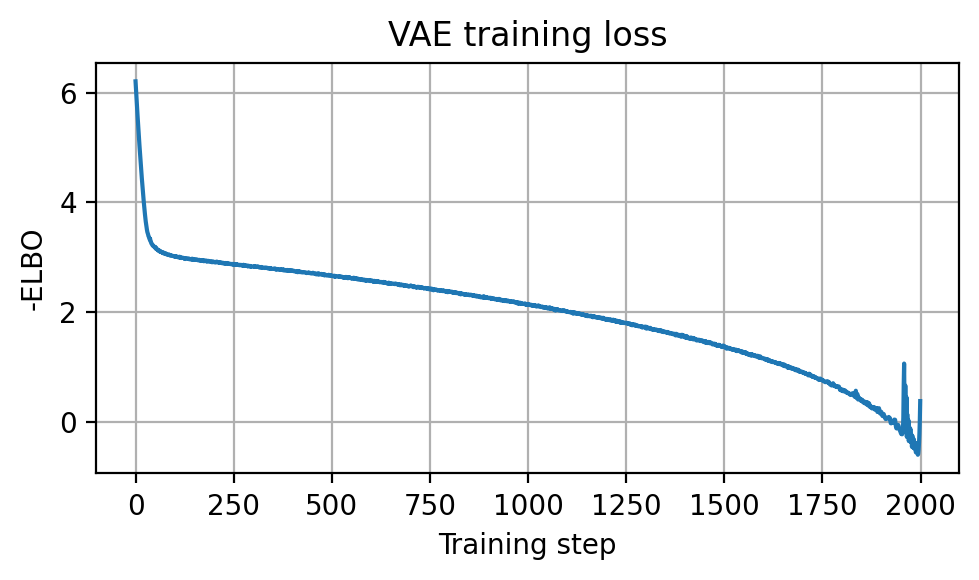

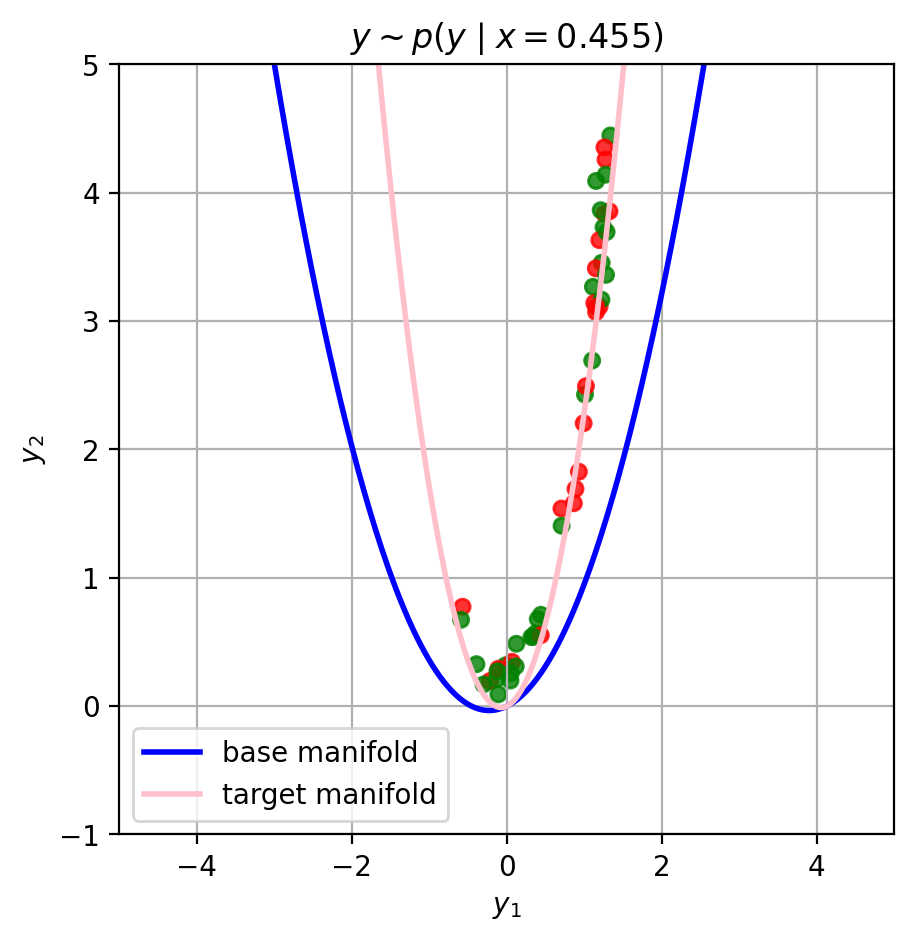

In [ ]:
# Step 1: Pre-training
opt = optax.adam(pre_train_lr)
opt_state = opt.init(vae_params)

loss_history = []

for step in range(pre_train_epochs):
    key, subkey = jax.random.split(key)
    vae_params, opt_state, loss = pre_train_step(
        vae_params, step, opt_state, subkey, xs[:,0], ys[:,0]
    )
    loss_val = float(loss)          # convert from JAX scalar
    loss_history.append(loss_val)

    print(f"[{step+1}/{pre_train_epochs}] -ELBO = {loss_val}")

# Plot loss
plt.figure(figsize=(5, 3), dpi=200)
plt.plot(loss_history)
plt.xlabel("Training step")
plt.ylabel("-ELBO")
plt.title("VAE training loss")
plt.grid(True)
plt.tight_layout()
plt.show()

ys = sample_many(vae_params, ys_key, xs[:,0], m)

u = utility_vmapped(
    xs,
    ys,
    target_p.alpha,
    target_p.beta,
    target_p.gamma,
)

mean_u = jnp.mean(u)
gt_u_history.append(mean_u)

logits = logpdf_labels(
    xs,
    ys,
    alpha=target_p.alpha,
    beta=target_p.beta,
    gamma=target_p.gamma,
    tau=tau,
)

labels = jax.random.categorical(
    l_key,
    logits,
    axis=-1,
)

l_history.append(labels)   # labels used for queries

task_vis.visualize(
    xs[0, 0, 0],
    ys[0],
    base_manifold=base_p,
    target_manifold=target_p,
    labels=labels[0],
)

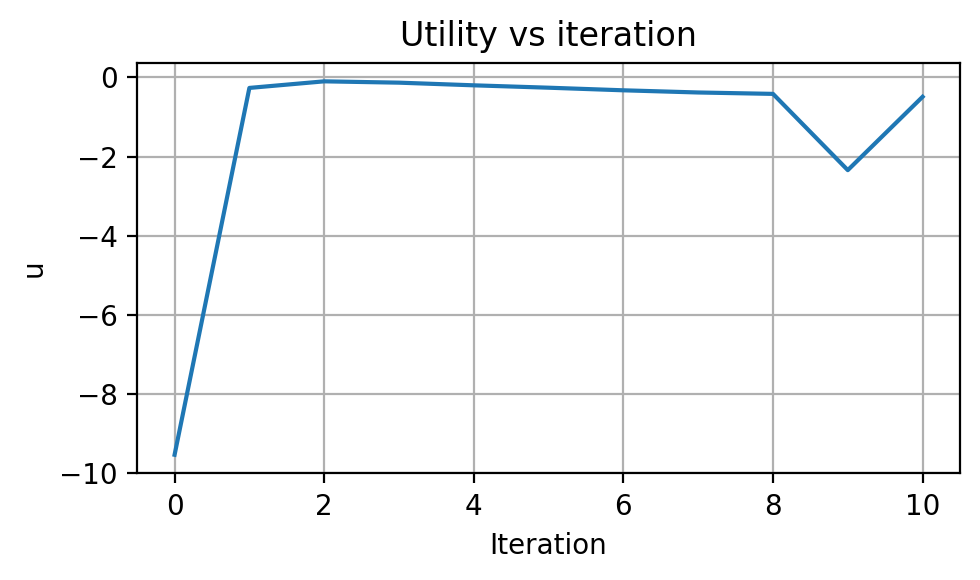

In [ ]:
plt.figure(figsize=(5, 3), dpi=200)
plt.plot(gt_u_history)
plt.xlabel("Iteration")
plt.ylabel("u")
plt.title("Utility vs iteration")
plt.grid(True)
plt.tight_layout()
plt.show()